# Locally-Linear Deep Learner on Synthetic Data
Uses attention_model (v3). Additions:  
    - Batch Normalization to the hidden layer after concat.    
    - Similarity batching (to be implemented)  
    - Softmax layer/Activity Regularizer (?) for Concat layer  
Synth data: (10-dimension with cluster-specific noise) 

In [1]:
%env TMPDIR=/tmp/temp 
#For joblib multi-threading

import os, sys
import numpy as np
import time

code_folder=os.path.join(os.getcwd(), "..", "..", "0_code")
sys.path.append(code_folder)

env: TMPDIR=/tmp/temp


In [2]:
import numpy as np
import pandas as pd
df=pd.read_csv("SynthData_10dim_clusternoise_unbalanced.csv",
               index_col=0
              )
Fweights_df=pd.read_csv("Fweights.csv")
Fweights_test_df=pd.read_csv("Fweights_test.csv")

In [3]:
df.head()

,Type,cluster_labels,Class,feat_000,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009
0,Training,1,1,-1.570480,-1.996704,-0.397339,1.846643,-0.793395,-0.829746,-0.963892,0.834501,-0.820725,-1.208541
1,Training,3,0,-0.309449,1.072087,1.459908,1.203113,-1.836092,0.978916,-0.657411,1.079674,-0.211478,0.908253
2,Training,0,0,1.461055,-0.658874,-0.555268,0.687565,-1.331029,-0.085937,0.481418,-1.790801,-0.505561,-0.318124
3,Training,4,0,1.388434,0.367714,0.326258,0.959787,0.041162,0.116390,-1.591442,-0.317489,1.120463,0.235266
4,Training,3,0,-1.001749,1.787647,-0.143789,1.811552,-0.165524,-0.342146,0.983880,1.737978,-1.236073,1.395462


In [4]:
np.unique(df['Class'], return_counts=True)

(array([0, 1], dtype=int64), array([743, 257], dtype=int64))

In [5]:
Fweights_df.shape

(900, 10)

In [6]:
df.columns

Index(['Type', 'cluster_labels', 'Class', 'feat_000', 'feat_001', 'feat_002',
       'feat_003', 'feat_004', 'feat_005', 'feat_006', 'feat_007', 'feat_008',
       'feat_009'],
      dtype='object')

In [7]:
X_train=df[df['Type']=="Training"].iloc[:, 3:]
X_test=df[df['Type']=="Testing"].iloc[:,3:]
y_train=df[df['Type']=="Training"].iloc[:,2]
y_test=df[df['Type']=="Testing"].iloc[:,2]
Fweights_train=Fweights_df.values
Fweights_test=Fweights_test_df.values

cluster_labels_train=df[df['Type']=='Training']['cluster_labels']
cluster_labels_test=df[df['Type']=='Testing']['cluster_labels']

In [8]:
train_data=X_train.values
train_targets=np.expand_dims(y_train, axis=1).astype(np.float32)
test_data=X_test.values
test_targets=np.expand_dims(y_test, axis=1).astype(np.float32)
train_Fweights=Fweights_train
test_Fweights=Fweights_test

train_tensor=np.hstack([train_data, train_Fweights])
test_tensor=np.hstack([test_data, test_Fweights])

## Train LLDL 

In [10]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.keras.backend.set_floatx('float32')
from tf_helpers import get_weights_dicts, BinaryCrossEntropyIgnoreNan
from tf_helpers import SimilarityBatchingDataset

In [11]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewFW_{}".format("label"),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [12]:
from importlib import reload
reload(attention_model)

NameError: name 'attention_model' is not defined

In [15]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat*2, ))

attentions_layer=attention_model.ConcatAttentionswFeatWeights(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_kernel_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNan(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy', 'AUC']
             )

In [16]:
LSwFW_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
concat_attentionsw_feat_weig (None, 128)               18350     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 30,831
Trainable params: 30,319
Non-trainable params: 512
_________________________________________________________________


In [15]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

# LSwFW_model.fit(train_tensor, 
#                 train_targets, 
#                 epochs=1,
#                 batch_size=n_batch,
#                 shuffle=True,
#                 verbose=2, 
#                )
# #Set feat weights
# # Fweights=cosa_mdl.Fweight
# sampled_Fweights=train_Fweights[np.random.choice(range(len(train_Fweights)), n_attention)]
# for i in range(n_attention):
#     weights=LSwFW_model.layers[1].attention_layers[i].get_weights()
#     weights[0]=np.reshape(sampled_Fweights[i], (1,n_feat))
#     LSwFW_model.layers[1].attention_layers[i].set_weights(weights)


n_epoch=2000


LSwFW_model.fit(train_tensor, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 10s - loss: 0.6339 - accuracy: 0.6878 - auc: 0.7363 - val_loss: 0.4908 - val_accuracy: 0.8300 - val_auc: 0.8534

Epoch 00001: val_auc improved from -inf to 0.85343, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 2/2000
113/113 - 5s - loss: 0.4883 - accuracy: 0.7756 - auc: 0.8494 - val_loss: 0.5046 - val_accuracy: 0.7700 - val_auc: 0.8436

Epoch 00002: val_auc did not improve from 0.85343
Epoch 3/2000
113/113 - 5s - loss: 0.4668 - accuracy: 0.7733 - auc: 0.8610 - val_loss: 0.4717 - val_accuracy: 0.7700 - val_auc: 0.8633

Epoch 00003: val_auc improved from 0.85343 to 0.86331, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 4/2000
113/113 - 5s - loss: 0.4057 - accuracy: 0.8244 - auc: 0.8986 - val_loss: 0.3794 - val_accuracy: 0.8200 - val_auc: 0.9137

Epoch 00004: val_auc improved from 0.86331 to 0.91372, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 5/20

113/113 - 5s - loss: 0.1210 - accuracy: 0.9544 - auc: 0.9908 - val_loss: 0.6062 - val_accuracy: 0.8600 - val_auc: 0.9262

Epoch 00042: val_auc did not improve from 0.92801
Epoch 43/2000
113/113 - 5s - loss: 0.1061 - accuracy: 0.9600 - auc: 0.9935 - val_loss: 0.7086 - val_accuracy: 0.8600 - val_auc: 0.9163

Epoch 00043: val_auc did not improve from 0.92801
Epoch 44/2000
113/113 - 5s - loss: 0.1111 - accuracy: 0.9567 - auc: 0.9916 - val_loss: 0.7416 - val_accuracy: 0.8500 - val_auc: 0.9111

Epoch 00044: val_auc did not improve from 0.92801
Epoch 45/2000
113/113 - 5s - loss: 0.0595 - accuracy: 0.9867 - auc: 0.9983 - val_loss: 0.8721 - val_accuracy: 0.8200 - val_auc: 0.8849

Epoch 00045: val_auc did not improve from 0.92801
Epoch 46/2000
113/113 - 5s - loss: 0.0743 - accuracy: 0.9756 - auc: 0.9960 - val_loss: 0.7898 - val_accuracy: 0.8700 - val_auc: 0.8989

Epoch 00046: val_auc did not improve from 0.92801
Epoch 47/2000
113/113 - 5s - loss: 0.0549 - accuracy: 0.9844 - auc: 0.9976 - val_los


Epoch 00086: val_auc did not improve from 0.92801
Epoch 87/2000
113/113 - 5s - loss: 0.0135 - accuracy: 0.9978 - auc: 1.0000 - val_loss: 0.9524 - val_accuracy: 0.8800 - val_auc: 0.8966

Epoch 00087: val_auc did not improve from 0.92801
Epoch 88/2000
113/113 - 5s - loss: 0.0207 - accuracy: 0.9967 - auc: 0.9991 - val_loss: 1.0742 - val_accuracy: 0.8500 - val_auc: 0.9015

Epoch 00088: val_auc did not improve from 0.92801
Epoch 89/2000
113/113 - 5s - loss: 0.0366 - accuracy: 0.9922 - auc: 0.9980 - val_loss: 1.1928 - val_accuracy: 0.8200 - val_auc: 0.8649

Epoch 00089: val_auc did not improve from 0.92801
Epoch 90/2000
113/113 - 5s - loss: 0.2408 - accuracy: 0.9589 - auc: 0.9791 - val_loss: 1.0548 - val_accuracy: 0.8500 - val_auc: 0.8755

Epoch 00090: val_auc did not improve from 0.92801
Epoch 91/2000
113/113 - 5s - loss: 0.0782 - accuracy: 0.9733 - auc: 0.9957 - val_loss: 1.2091 - val_accuracy: 0.8400 - val_auc: 0.8701

Epoch 00091: val_auc did not improve from 0.92801
Epoch 92/2000
113/1


Epoch 00130: val_auc did not improve from 0.92801
Epoch 131/2000
113/113 - 5s - loss: 0.0050 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3877 - val_accuracy: 0.8500 - val_auc: 0.8446

Epoch 00131: val_auc did not improve from 0.92801
Epoch 132/2000
113/113 - 5s - loss: 0.0050 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3759 - val_accuracy: 0.8500 - val_auc: 0.8615

Epoch 00132: val_auc did not improve from 0.92801
Epoch 133/2000
113/113 - 5s - loss: 0.0050 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3864 - val_accuracy: 0.8600 - val_auc: 0.8446

Epoch 00133: val_auc did not improve from 0.92801
Epoch 134/2000
113/113 - 4s - loss: 0.0049 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3975 - val_accuracy: 0.8700 - val_auc: 0.8446

Epoch 00134: val_auc did not improve from 0.92801
Epoch 135/2000
113/113 - 5s - loss: 0.0049 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4073 - val_accuracy: 0.8500 - val_auc: 0.8446

Epoch 00135: val_auc did not improve from 0.92801
Epoch 136/2000


Epoch 00173: val_auc did not improve from 0.93217
Epoch 174/2000
113/113 - 5s - loss: 0.0054 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0679 - val_accuracy: 0.8800 - val_auc: 0.8958

Epoch 00174: val_auc did not improve from 0.93217
Epoch 175/2000
113/113 - 5s - loss: 0.0053 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0779 - val_accuracy: 0.8800 - val_auc: 0.8963

Epoch 00175: val_auc did not improve from 0.93217
Epoch 176/2000
113/113 - 5s - loss: 0.0052 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0802 - val_accuracy: 0.8800 - val_auc: 0.8968

Epoch 00176: val_auc did not improve from 0.93217
Epoch 177/2000
113/113 - 5s - loss: 0.0052 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0891 - val_accuracy: 0.8800 - val_auc: 0.8963

Epoch 00177: val_auc did not improve from 0.93217
Epoch 178/2000
113/113 - 5s - loss: 0.0051 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1005 - val_accuracy: 0.8800 - val_auc: 0.8919

Epoch 00178: val_auc did not improve from 0.93217
Epoch 179/2000


Epoch 00217: val_auc did not improve from 0.93217
Epoch 218/2000
113/113 - 5s - loss: 0.0064 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0174 - val_accuracy: 0.8700 - val_auc: 0.8851

Epoch 00218: val_auc did not improve from 0.93217
Epoch 219/2000
113/113 - 5s - loss: 0.0062 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0287 - val_accuracy: 0.8800 - val_auc: 0.8859

Epoch 00219: val_auc did not improve from 0.93217
Epoch 220/2000
113/113 - 4s - loss: 0.0060 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0473 - val_accuracy: 0.8700 - val_auc: 0.8849

Epoch 00220: val_auc did not improve from 0.93217
Epoch 221/2000
113/113 - 4s - loss: 0.0059 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0817 - val_accuracy: 0.8800 - val_auc: 0.8703

Epoch 00221: val_auc did not improve from 0.93217
Epoch 222/2000
113/113 - 5s - loss: 0.0058 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0787 - val_accuracy: 0.8800 - val_auc: 0.8542

Epoch 00222: val_auc did not improve from 0.93217
Epoch 223/2000


Epoch 00261: val_auc did not improve from 0.93217
Epoch 262/2000
113/113 - 5s - loss: 0.0041 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3021 - val_accuracy: 0.8800 - val_auc: 0.8810

Epoch 00262: val_auc did not improve from 0.93217
Epoch 263/2000
113/113 - 5s - loss: 0.0040 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2879 - val_accuracy: 0.8700 - val_auc: 0.8815

Epoch 00263: val_auc did not improve from 0.93217
Epoch 264/2000
113/113 - 5s - loss: 0.5187 - accuracy: 0.9289 - auc: 0.9554 - val_loss: 2.0457 - val_accuracy: 0.7100 - val_auc: 0.8004

Epoch 00264: val_auc did not improve from 0.93217
Epoch 265/2000
113/113 - 5s - loss: 0.5071 - accuracy: 0.9156 - auc: 0.9472 - val_loss: 0.7212 - val_accuracy: 0.8500 - val_auc: 0.9020

Epoch 00265: val_auc did not improve from 0.93217
Epoch 266/2000
113/113 - 5s - loss: 0.0994 - accuracy: 0.9611 - auc: 0.9936 - val_loss: 0.7174 - val_accuracy: 0.8400 - val_auc: 0.9010

Epoch 00266: val_auc did not improve from 0.93217
Epoch 267/2000


Epoch 00305: val_auc did not improve from 0.93217
Epoch 306/2000
113/113 - 4s - loss: 0.0045 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0675 - val_accuracy: 0.8800 - val_auc: 0.8875

Epoch 00306: val_auc did not improve from 0.93217
Epoch 307/2000
113/113 - 5s - loss: 0.0045 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0706 - val_accuracy: 0.8800 - val_auc: 0.8875

Epoch 00307: val_auc did not improve from 0.93217
Epoch 308/2000
113/113 - 5s - loss: 0.0044 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0700 - val_accuracy: 0.8800 - val_auc: 0.8875

Epoch 00308: val_auc did not improve from 0.93217
Epoch 309/2000
113/113 - 5s - loss: 0.0044 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0689 - val_accuracy: 0.8800 - val_auc: 0.8880

Epoch 00309: val_auc did not improve from 0.93217
Epoch 310/2000
113/113 - 5s - loss: 0.0044 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0832 - val_accuracy: 0.8800 - val_auc: 0.8875

Epoch 00310: val_auc did not improve from 0.93217
Epoch 311/2000


Epoch 00349: val_auc did not improve from 0.93217
Epoch 350/2000
113/113 - 5s - loss: 0.0046 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0672 - val_accuracy: 0.8700 - val_auc: 0.8950

Epoch 00350: val_auc did not improve from 0.93217
Epoch 351/2000
113/113 - 5s - loss: 0.0045 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0778 - val_accuracy: 0.8700 - val_auc: 0.8950

Epoch 00351: val_auc did not improve from 0.93217
Epoch 352/2000
113/113 - 5s - loss: 0.0045 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0922 - val_accuracy: 0.8700 - val_auc: 0.8953

Epoch 00352: val_auc did not improve from 0.93217
Epoch 353/2000
113/113 - 5s - loss: 0.0045 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0952 - val_accuracy: 0.8700 - val_auc: 0.8948

Epoch 00353: val_auc did not improve from 0.93217
Epoch 354/2000
113/113 - 5s - loss: 0.0044 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0997 - val_accuracy: 0.8700 - val_auc: 0.8953

Epoch 00354: val_auc did not improve from 0.93217
Epoch 355/2000


Epoch 00393: val_auc did not improve from 0.93217
Epoch 394/2000
113/113 - 5s - loss: 0.0080 - accuracy: 0.9989 - auc: 1.0000 - val_loss: 0.8983 - val_accuracy: 0.8700 - val_auc: 0.9036

Epoch 00394: val_auc did not improve from 0.93217
Epoch 395/2000
113/113 - 5s - loss: 0.0069 - accuracy: 0.9989 - auc: 1.0000 - val_loss: 0.8931 - val_accuracy: 0.8700 - val_auc: 0.9049

Epoch 00395: val_auc did not improve from 0.93217
Epoch 396/2000
113/113 - 5s - loss: 0.0064 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.9149 - val_accuracy: 0.8700 - val_auc: 0.8901

Epoch 00396: val_auc did not improve from 0.93217
Epoch 397/2000
113/113 - 4s - loss: 0.0058 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.9255 - val_accuracy: 0.8700 - val_auc: 0.8901

Epoch 00397: val_auc did not improve from 0.93217
Epoch 398/2000
113/113 - 4s - loss: 0.0058 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.9622 - val_accuracy: 0.8700 - val_auc: 0.8893

Epoch 00398: val_auc did not improve from 0.93217
Epoch 399/2000


Epoch 00437: val_auc did not improve from 0.93217
Epoch 438/2000
113/113 - 5s - loss: 0.0035 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2477 - val_accuracy: 0.8700 - val_auc: 0.8883

Epoch 00438: val_auc did not improve from 0.93217
Epoch 439/2000
113/113 - 5s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2578 - val_accuracy: 0.8700 - val_auc: 0.8875

Epoch 00439: val_auc did not improve from 0.93217
Epoch 440/2000
113/113 - 4s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2412 - val_accuracy: 0.8700 - val_auc: 0.8883

Epoch 00440: val_auc did not improve from 0.93217
Epoch 441/2000
113/113 - 4s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2502 - val_accuracy: 0.8700 - val_auc: 0.8877

Epoch 00441: val_auc did not improve from 0.93217
Epoch 442/2000
113/113 - 5s - loss: 0.0033 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2620 - val_accuracy: 0.8700 - val_auc: 0.8877

Epoch 00442: val_auc did not improve from 0.93217
Epoch 443/2000


Epoch 00481: val_auc did not improve from 0.93217
Epoch 482/2000
113/113 - 5s - loss: 0.0035 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1757 - val_accuracy: 0.8800 - val_auc: 0.8851

Epoch 00482: val_auc did not improve from 0.93217
Epoch 483/2000
113/113 - 5s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1835 - val_accuracy: 0.8800 - val_auc: 0.8851

Epoch 00483: val_auc did not improve from 0.93217
Epoch 484/2000
113/113 - 5s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1957 - val_accuracy: 0.8800 - val_auc: 0.8846

Epoch 00484: val_auc did not improve from 0.93217
Epoch 485/2000
113/113 - 5s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2020 - val_accuracy: 0.8800 - val_auc: 0.8851

Epoch 00485: val_auc did not improve from 0.93217
Epoch 486/2000
113/113 - 4s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2096 - val_accuracy: 0.8800 - val_auc: 0.8851

Epoch 00486: val_auc did not improve from 0.93217
Epoch 487/2000


Epoch 00525: val_auc did not improve from 0.93217
Epoch 526/2000
113/113 - 5s - loss: 0.0222 - accuracy: 0.9922 - auc: 0.9997 - val_loss: 0.7584 - val_accuracy: 0.8600 - val_auc: 0.9085

Epoch 00526: val_auc did not improve from 0.93217
Epoch 527/2000
113/113 - 4s - loss: 0.0169 - accuracy: 0.9967 - auc: 0.9998 - val_loss: 0.7780 - val_accuracy: 0.8800 - val_auc: 0.9090

Epoch 00527: val_auc did not improve from 0.93217
Epoch 528/2000
113/113 - 5s - loss: 0.0177 - accuracy: 0.9956 - auc: 0.9999 - val_loss: 0.8075 - val_accuracy: 0.8800 - val_auc: 0.9031

Epoch 00528: val_auc did not improve from 0.93217
Epoch 529/2000
113/113 - 5s - loss: 0.0117 - accuracy: 0.9989 - auc: 0.9999 - val_loss: 0.7834 - val_accuracy: 0.8800 - val_auc: 0.9070

Epoch 00529: val_auc did not improve from 0.93217
Epoch 530/2000
113/113 - 5s - loss: 0.0077 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.8029 - val_accuracy: 0.8800 - val_auc: 0.9054

Epoch 00530: val_auc did not improve from 0.93217
Epoch 531/2000


Epoch 00569: val_auc did not improve from 0.93217
Epoch 570/2000
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2754 - val_accuracy: 0.8700 - val_auc: 0.8560

Epoch 00570: val_auc did not improve from 0.93217
Epoch 571/2000
113/113 - 4s - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2889 - val_accuracy: 0.8700 - val_auc: 0.8555

Epoch 00571: val_auc did not improve from 0.93217
Epoch 572/2000
113/113 - 5s - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3014 - val_accuracy: 0.8700 - val_auc: 0.8552

Epoch 00572: val_auc did not improve from 0.93217
Epoch 573/2000
113/113 - 5s - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3084 - val_accuracy: 0.8700 - val_auc: 0.8558

Epoch 00573: val_auc did not improve from 0.93217
Epoch 574/2000
113/113 - 5s - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3103 - val_accuracy: 0.8700 - val_auc: 0.8560

Epoch 00574: val_auc did not improve from 0.93217
Epoch 575/2000


Epoch 00613: val_auc did not improve from 0.93217
Epoch 614/2000
113/113 - 5s - loss: 0.0035 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.9988 - val_accuracy: 0.8700 - val_auc: 0.8794

Epoch 00614: val_auc did not improve from 0.93217
Epoch 615/2000
113/113 - 5s - loss: 0.0035 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0108 - val_accuracy: 0.8700 - val_auc: 0.8799

Epoch 00615: val_auc did not improve from 0.93217
Epoch 616/2000
113/113 - 5s - loss: 0.0034 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0254 - val_accuracy: 0.8600 - val_auc: 0.8789

Epoch 00616: val_auc did not improve from 0.93217
Epoch 617/2000
113/113 - 5s - loss: 0.0033 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0304 - val_accuracy: 0.8600 - val_auc: 0.8789

Epoch 00617: val_auc did not improve from 0.93217
Epoch 618/2000
113/113 - 5s - loss: 0.0033 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.0388 - val_accuracy: 0.8600 - val_auc: 0.8789

Epoch 00618: val_auc did not improve from 0.93217
Epoch 619/2000


Epoch 00657: val_auc did not improve from 0.93217
Epoch 658/2000
113/113 - 5s - loss: 0.0024 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3176 - val_accuracy: 0.8500 - val_auc: 0.8628

Epoch 00658: val_auc did not improve from 0.93217
Epoch 659/2000
113/113 - 4s - loss: 0.0024 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2932 - val_accuracy: 0.8600 - val_auc: 0.8625

Epoch 00659: val_auc did not improve from 0.93217
Epoch 660/2000
113/113 - 5s - loss: 0.4811 - accuracy: 0.9311 - auc: 0.9571 - val_loss: 1.0706 - val_accuracy: 0.8700 - val_auc: 0.8703

Epoch 00660: val_auc did not improve from 0.93217
Epoch 661/2000
113/113 - 4s - loss: 0.2042 - accuracy: 0.9422 - auc: 0.9820 - val_loss: 0.6853 - val_accuracy: 0.8600 - val_auc: 0.9337

Epoch 00661: val_auc improved from 0.93217 to 0.93373, saving model to 210222_TrainingLocalitySensitivewFW\LocalitySensitivewFW_label
Epoch 662/2000
113/113 - 4s - loss: 0.0526 - accuracy: 0.9822 - auc: 0.9979 - val_loss: 0.7473 - val_accuracy: 0.8800


Epoch 00701: val_auc did not improve from 0.93373
Epoch 702/2000
113/113 - 4s - loss: 0.0028 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1386 - val_accuracy: 0.8500 - val_auc: 0.8729

Epoch 00702: val_auc did not improve from 0.93373
Epoch 703/2000
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1436 - val_accuracy: 0.8500 - val_auc: 0.8721

Epoch 00703: val_auc did not improve from 0.93373
Epoch 704/2000
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1501 - val_accuracy: 0.8600 - val_auc: 0.8721

Epoch 00704: val_auc did not improve from 0.93373
Epoch 705/2000
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1531 - val_accuracy: 0.8600 - val_auc: 0.8727

Epoch 00705: val_auc did not improve from 0.93373
Epoch 706/2000
113/113 - 5s - loss: 0.0027 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1585 - val_accuracy: 0.8600 - val_auc: 0.8721

Epoch 00706: val_auc did not improve from 0.93373
Epoch 707/2000


Epoch 00745: val_auc did not improve from 0.93373
Epoch 746/2000
113/113 - 5s - loss: 0.0032 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1381 - val_accuracy: 0.8700 - val_auc: 0.8495

Epoch 00746: val_auc did not improve from 0.93373
Epoch 747/2000
113/113 - 4s - loss: 0.0031 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1512 - val_accuracy: 0.8700 - val_auc: 0.8495

Epoch 00747: val_auc did not improve from 0.93373
Epoch 748/2000
113/113 - 4s - loss: 0.0031 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1615 - val_accuracy: 0.8700 - val_auc: 0.8495

Epoch 00748: val_auc did not improve from 0.93373
Epoch 749/2000
113/113 - 4s - loss: 0.0031 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1716 - val_accuracy: 0.8800 - val_auc: 0.8446

Epoch 00749: val_auc did not improve from 0.93373
Epoch 750/2000
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1777 - val_accuracy: 0.8800 - val_auc: 0.8443

Epoch 00750: val_auc did not improve from 0.93373
Epoch 751/2000


Epoch 00789: val_auc did not improve from 0.93373
Epoch 790/2000
113/113 - 5s - loss: 0.0022 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4131 - val_accuracy: 0.8700 - val_auc: 0.8506

Epoch 00790: val_auc did not improve from 0.93373
Epoch 791/2000
113/113 - 5s - loss: 0.0022 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4060 - val_accuracy: 0.8800 - val_auc: 0.8456

Epoch 00791: val_auc did not improve from 0.93373
Epoch 792/2000
113/113 - 5s - loss: 0.0022 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4100 - val_accuracy: 0.8700 - val_auc: 0.8506

Epoch 00792: val_auc did not improve from 0.93373
Epoch 793/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4107 - val_accuracy: 0.8700 - val_auc: 0.8501

Epoch 00793: val_auc did not improve from 0.93373
Epoch 794/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4191 - val_accuracy: 0.8700 - val_auc: 0.8436

Epoch 00794: val_auc did not improve from 0.93373
Epoch 795/2000


Epoch 00833: val_auc did not improve from 0.93373
Epoch 834/2000
113/113 - 4s - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2315 - val_accuracy: 0.8900 - val_auc: 0.8568

Epoch 00834: val_auc did not improve from 0.93373
Epoch 835/2000
113/113 - 5s - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2396 - val_accuracy: 0.8900 - val_auc: 0.8568

Epoch 00835: val_auc did not improve from 0.93373
Epoch 836/2000
113/113 - 5s - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2526 - val_accuracy: 0.8900 - val_auc: 0.8568

Epoch 00836: val_auc did not improve from 0.93373
Epoch 837/2000
113/113 - 5s - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2622 - val_accuracy: 0.8900 - val_auc: 0.8568

Epoch 00837: val_auc did not improve from 0.93373
Epoch 838/2000
113/113 - 5s - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2698 - val_accuracy: 0.8900 - val_auc: 0.8568

Epoch 00838: val_auc did not improve from 0.93373
Epoch 839/2000


Epoch 00877: val_auc did not improve from 0.93373
Epoch 878/2000
113/113 - 5s - loss: 0.2552 - accuracy: 0.9433 - auc: 0.9799 - val_loss: 0.9945 - val_accuracy: 0.8700 - val_auc: 0.8786

Epoch 00878: val_auc did not improve from 0.93373
Epoch 879/2000
113/113 - 5s - loss: 0.0969 - accuracy: 0.9711 - auc: 0.9953 - val_loss: 1.2534 - val_accuracy: 0.8300 - val_auc: 0.8352

Epoch 00879: val_auc did not improve from 0.93373
Epoch 880/2000
113/113 - 5s - loss: 0.1308 - accuracy: 0.9800 - auc: 0.9897 - val_loss: 0.8704 - val_accuracy: 0.8800 - val_auc: 0.8797

Epoch 00880: val_auc did not improve from 0.93373
Epoch 881/2000
113/113 - 4s - loss: 0.0161 - accuracy: 0.9944 - auc: 0.9999 - val_loss: 0.8808 - val_accuracy: 0.8700 - val_auc: 0.8727

Epoch 00881: val_auc did not improve from 0.93373
Epoch 882/2000
113/113 - 5s - loss: 0.0069 - accuracy: 0.9978 - auc: 1.0000 - val_loss: 0.9508 - val_accuracy: 0.8600 - val_auc: 0.8706

Epoch 00882: val_auc did not improve from 0.93373
Epoch 883/2000


Epoch 00921: val_auc did not improve from 0.93373
Epoch 922/2000
113/113 - 5s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3468 - val_accuracy: 0.8700 - val_auc: 0.8576

Epoch 00922: val_auc did not improve from 0.93373
Epoch 923/2000
113/113 - 4s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3497 - val_accuracy: 0.8700 - val_auc: 0.8573

Epoch 00923: val_auc did not improve from 0.93373
Epoch 924/2000
113/113 - 5s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3630 - val_accuracy: 0.8600 - val_auc: 0.8578

Epoch 00924: val_auc did not improve from 0.93373
Epoch 925/2000
113/113 - 5s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3626 - val_accuracy: 0.8600 - val_auc: 0.8584

Epoch 00925: val_auc did not improve from 0.93373
Epoch 926/2000
113/113 - 5s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3684 - val_accuracy: 0.8700 - val_auc: 0.8563

Epoch 00926: val_auc did not improve from 0.93373
Epoch 927/2000


Epoch 00965: val_auc did not improve from 0.93373
Epoch 966/2000
113/113 - 5s - loss: 0.0027 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1593 - val_accuracy: 0.8700 - val_auc: 0.8610

Epoch 00966: val_auc did not improve from 0.93373
Epoch 967/2000
113/113 - 4s - loss: 0.0027 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1706 - val_accuracy: 0.8700 - val_auc: 0.8563

Epoch 00967: val_auc did not improve from 0.93373
Epoch 968/2000
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1862 - val_accuracy: 0.8700 - val_auc: 0.8563

Epoch 00968: val_auc did not improve from 0.93373
Epoch 969/2000
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.1998 - val_accuracy: 0.8700 - val_auc: 0.8563

Epoch 00969: val_auc did not improve from 0.93373
Epoch 970/2000
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2107 - val_accuracy: 0.8700 - val_auc: 0.8576

Epoch 00970: val_auc did not improve from 0.93373
Epoch 971/2000


Epoch 01009: val_auc did not improve from 0.93373
Epoch 1010/2000
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5587 - val_accuracy: 0.8600 - val_auc: 0.8508

Epoch 01010: val_auc did not improve from 0.93373
Epoch 1011/2000
113/113 - 5s - loss: 0.0019 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5533 - val_accuracy: 0.8600 - val_auc: 0.8521

Epoch 01011: val_auc did not improve from 0.93373
Epoch 1012/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5565 - val_accuracy: 0.8700 - val_auc: 0.8514

Epoch 01012: val_auc did not improve from 0.93373
Epoch 1013/2000
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5643 - val_accuracy: 0.8600 - val_auc: 0.8527

Epoch 01013: val_auc did not improve from 0.93373
Epoch 1014/2000
113/113 - 5s - loss: 0.0018 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5710 - val_accuracy: 0.8600 - val_auc: 0.8495

Epoch 01014: val_auc did not improve from 0.93373
Epoch 101


Epoch 01053: val_auc did not improve from 0.93373
Epoch 1054/2000
113/113 - 4s - loss: 0.0024 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4110 - val_accuracy: 0.8800 - val_auc: 0.8745

Epoch 01054: val_auc did not improve from 0.93373
Epoch 1055/2000
113/113 - 4s - loss: 0.0024 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4160 - val_accuracy: 0.8800 - val_auc: 0.8750

Epoch 01055: val_auc did not improve from 0.93373
Epoch 1056/2000
113/113 - 5s - loss: 0.0024 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4246 - val_accuracy: 0.8800 - val_auc: 0.8734

Epoch 01056: val_auc did not improve from 0.93373
Epoch 1057/2000
113/113 - 5s - loss: 0.0023 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4376 - val_accuracy: 0.8800 - val_auc: 0.8729

Epoch 01057: val_auc did not improve from 0.93373
Epoch 1058/2000
113/113 - 5s - loss: 0.0023 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4473 - val_accuracy: 0.8800 - val_auc: 0.8732

Epoch 01058: val_auc did not improve from 0.93373
Epoch 105


Epoch 01097: val_auc did not improve from 0.93373
Epoch 1098/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.9842 - val_accuracy: 0.8300 - val_auc: 0.8384

Epoch 01098: val_auc did not improve from 0.93373
Epoch 1099/2000
113/113 - 5s - loss: 0.5468 - accuracy: 0.9322 - auc: 0.9557 - val_loss: 1.7521 - val_accuracy: 0.8400 - val_auc: 0.8254

Epoch 01099: val_auc did not improve from 0.93373
Epoch 1100/2000
113/113 - 5s - loss: 0.1570 - accuracy: 0.9667 - auc: 0.9856 - val_loss: 1.0156 - val_accuracy: 0.8500 - val_auc: 0.8888

Epoch 01100: val_auc did not improve from 0.93373
Epoch 1101/2000
113/113 - 4s - loss: 0.0567 - accuracy: 0.9889 - auc: 0.9964 - val_loss: 0.9794 - val_accuracy: 0.8400 - val_auc: 0.8781

Epoch 01101: val_auc did not improve from 0.93373
Epoch 1102/2000
113/113 - 4s - loss: 0.0479 - accuracy: 0.9889 - auc: 0.9958 - val_loss: 1.0830 - val_accuracy: 0.8800 - val_auc: 0.8857

Epoch 01102: val_auc did not improve from 0.93373
Epoch 110


Epoch 01141: val_auc did not improve from 0.93373
Epoch 1142/2000
113/113 - 5s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5424 - val_accuracy: 0.8700 - val_auc: 0.8441

Epoch 01142: val_auc did not improve from 0.93373
Epoch 1143/2000
113/113 - 5s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5563 - val_accuracy: 0.8700 - val_auc: 0.8441

Epoch 01143: val_auc did not improve from 0.93373
Epoch 1144/2000
113/113 - 5s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5563 - val_accuracy: 0.8700 - val_auc: 0.8441

Epoch 01144: val_auc did not improve from 0.93373
Epoch 1145/2000
113/113 - 5s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5704 - val_accuracy: 0.8700 - val_auc: 0.8441

Epoch 01145: val_auc did not improve from 0.93373
Epoch 1146/2000
113/113 - 5s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5830 - val_accuracy: 0.8600 - val_auc: 0.8441

Epoch 01146: val_auc did not improve from 0.93373
Epoch 114


Epoch 01185: val_auc did not improve from 0.93373
Epoch 1186/2000
113/113 - 4s - loss: 0.0031 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2584 - val_accuracy: 0.8600 - val_auc: 0.8560

Epoch 01186: val_auc did not improve from 0.93373
Epoch 1187/2000
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2716 - val_accuracy: 0.8600 - val_auc: 0.8542

Epoch 01187: val_auc did not improve from 0.93373
Epoch 1188/2000
113/113 - 4s - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2836 - val_accuracy: 0.8600 - val_auc: 0.8514

Epoch 01188: val_auc did not improve from 0.93373
Epoch 1189/2000
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.2938 - val_accuracy: 0.8700 - val_auc: 0.8488

Epoch 01189: val_auc did not improve from 0.93373
Epoch 1190/2000
113/113 - 4s - loss: 0.0027 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3042 - val_accuracy: 0.8700 - val_auc: 0.8498

Epoch 01190: val_auc did not improve from 0.93373
Epoch 119


Epoch 01229: val_auc did not improve from 0.93373
Epoch 1230/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6029 - val_accuracy: 0.8800 - val_auc: 0.8316

Epoch 01230: val_auc did not improve from 0.93373
Epoch 1231/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6035 - val_accuracy: 0.8800 - val_auc: 0.8316

Epoch 01231: val_auc did not improve from 0.93373
Epoch 1232/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6107 - val_accuracy: 0.8800 - val_auc: 0.8316

Epoch 01232: val_auc did not improve from 0.93373
Epoch 1233/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6198 - val_accuracy: 0.8800 - val_auc: 0.8316

Epoch 01233: val_auc did not improve from 0.93373
Epoch 1234/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6230 - val_accuracy: 0.8800 - val_auc: 0.8316

Epoch 01234: val_auc did not improve from 0.93373
Epoch 123


Epoch 01273: val_auc did not improve from 0.93373
Epoch 1274/2000
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5873 - val_accuracy: 0.8400 - val_auc: 0.8339

Epoch 01274: val_auc did not improve from 0.93373
Epoch 1275/2000
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5990 - val_accuracy: 0.8400 - val_auc: 0.8339

Epoch 01275: val_auc did not improve from 0.93373
Epoch 1276/2000
113/113 - 5s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6086 - val_accuracy: 0.8400 - val_auc: 0.8295

Epoch 01276: val_auc did not improve from 0.93373
Epoch 1277/2000
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6193 - val_accuracy: 0.8400 - val_auc: 0.8295

Epoch 01277: val_auc did not improve from 0.93373
Epoch 1278/2000
113/113 - 5s - loss: 0.0019 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6278 - val_accuracy: 0.8400 - val_auc: 0.8295

Epoch 01278: val_auc did not improve from 0.93373
Epoch 127


Epoch 01317: val_auc did not improve from 0.93373
Epoch 1318/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8898 - val_accuracy: 0.8500 - val_auc: 0.8319

Epoch 01318: val_auc did not improve from 0.93373
Epoch 1319/2000
113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8979 - val_accuracy: 0.8500 - val_auc: 0.8316

Epoch 01319: val_auc did not improve from 0.93373
Epoch 1320/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.9091 - val_accuracy: 0.8500 - val_auc: 0.8316

Epoch 01320: val_auc did not improve from 0.93373
Epoch 1321/2000
113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.9055 - val_accuracy: 0.8500 - val_auc: 0.8324

Epoch 01321: val_auc did not improve from 0.93373
Epoch 1322/2000
113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8866 - val_accuracy: 0.8500 - val_auc: 0.8332

Epoch 01322: val_auc did not improve from 0.93373
Epoch 132


Epoch 01361: val_auc did not improve from 0.93373
Epoch 1362/2000
113/113 - 5s - loss: 0.0018 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5636 - val_accuracy: 0.8600 - val_auc: 0.8282

Epoch 01362: val_auc did not improve from 0.93373
Epoch 1363/2000
113/113 - 5s - loss: 0.0018 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5644 - val_accuracy: 0.8600 - val_auc: 0.8293

Epoch 01363: val_auc did not improve from 0.93373
Epoch 1364/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5778 - val_accuracy: 0.8600 - val_auc: 0.8282

Epoch 01364: val_auc did not improve from 0.93373
Epoch 1365/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5865 - val_accuracy: 0.8600 - val_auc: 0.8282

Epoch 01365: val_auc did not improve from 0.93373
Epoch 1366/2000
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.5884 - val_accuracy: 0.8600 - val_auc: 0.8287

Epoch 01366: val_auc did not improve from 0.93373
Epoch 136


Epoch 01405: val_auc did not improve from 0.93373
Epoch 1406/2000
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7297 - val_accuracy: 0.8600 - val_auc: 0.8277

Epoch 01406: val_auc did not improve from 0.93373
Epoch 1407/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7524 - val_accuracy: 0.8600 - val_auc: 0.8251

Epoch 01407: val_auc did not improve from 0.93373
Epoch 1408/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7490 - val_accuracy: 0.8600 - val_auc: 0.8290

Epoch 01408: val_auc did not improve from 0.93373
Epoch 1409/2000
113/113 - 4s - loss: 0.3770 - accuracy: 0.9456 - auc: 0.9657 - val_loss: 1.2400 - val_accuracy: 0.8000 - val_auc: 0.8547

Epoch 01409: val_auc did not improve from 0.93373
Epoch 1410/2000
113/113 - 5s - loss: 0.2730 - accuracy: 0.9389 - auc: 0.9739 - val_loss: 1.1137 - val_accuracy: 0.8300 - val_auc: 0.8272

Epoch 01410: val_auc did not improve from 0.93373
Epoch 141


Epoch 01449: val_auc did not improve from 0.93373
Epoch 1450/2000
113/113 - 5s - loss: 0.0016 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6072 - val_accuracy: 0.8300 - val_auc: 0.8316

Epoch 01450: val_auc did not improve from 0.93373
Epoch 1451/2000
113/113 - 5s - loss: 0.0016 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6127 - val_accuracy: 0.8300 - val_auc: 0.8316

Epoch 01451: val_auc did not improve from 0.93373
Epoch 1452/2000
113/113 - 5s - loss: 0.0016 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6210 - val_accuracy: 0.8400 - val_auc: 0.8316

Epoch 01452: val_auc did not improve from 0.93373
Epoch 1453/2000
113/113 - 5s - loss: 0.0016 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6301 - val_accuracy: 0.8300 - val_auc: 0.8316

Epoch 01453: val_auc did not improve from 0.93373
Epoch 1454/2000
113/113 - 5s - loss: 0.0016 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6390 - val_accuracy: 0.8400 - val_auc: 0.8316

Epoch 01454: val_auc did not improve from 0.93373
Epoch 145


Epoch 01493: val_auc did not improve from 0.93373
Epoch 1494/2000
113/113 - 4s - loss: 0.0714 - accuracy: 0.9944 - auc: 0.9935 - val_loss: 1.7896 - val_accuracy: 0.8000 - val_auc: 0.8277

Epoch 01494: val_auc did not improve from 0.93373
Epoch 1495/2000
113/113 - 4s - loss: 0.4127 - accuracy: 0.9344 - auc: 0.9634 - val_loss: 2.5953 - val_accuracy: 0.8100 - val_auc: 0.7474

Epoch 01495: val_auc did not improve from 0.93373
Epoch 1496/2000
113/113 - 4s - loss: 0.2512 - accuracy: 0.9622 - auc: 0.9780 - val_loss: 1.2430 - val_accuracy: 0.8400 - val_auc: 0.8586

Epoch 01496: val_auc did not improve from 0.93373
Epoch 1497/2000
113/113 - 4s - loss: 0.0779 - accuracy: 0.9789 - auc: 0.9943 - val_loss: 1.5825 - val_accuracy: 0.8200 - val_auc: 0.8087

Epoch 01497: val_auc did not improve from 0.93373
Epoch 1498/2000
113/113 - 4s - loss: 0.0122 - accuracy: 0.9956 - auc: 0.9999 - val_loss: 1.5874 - val_accuracy: 0.8300 - val_auc: 0.8108

Epoch 01498: val_auc did not improve from 0.93373
Epoch 149


Epoch 01537: val_auc did not improve from 0.93373
Epoch 1538/2000
113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6653 - val_accuracy: 0.8200 - val_auc: 0.8212

Epoch 01538: val_auc did not improve from 0.93373
Epoch 1539/2000
113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6623 - val_accuracy: 0.8200 - val_auc: 0.8217

Epoch 01539: val_auc did not improve from 0.93373
Epoch 1540/2000
113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6607 - val_accuracy: 0.8200 - val_auc: 0.8215

Epoch 01540: val_auc did not improve from 0.93373
Epoch 1541/2000
113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6639 - val_accuracy: 0.8200 - val_auc: 0.8217

Epoch 01541: val_auc did not improve from 0.93373
Epoch 1542/2000
113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6679 - val_accuracy: 0.8200 - val_auc: 0.8220

Epoch 01542: val_auc did not improve from 0.93373
Epoch 154


Epoch 01581: val_auc did not improve from 0.93373
Epoch 1582/2000
113/113 - 5s - loss: 0.0010 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8376 - val_accuracy: 0.8100 - val_auc: 0.8181

Epoch 01582: val_auc did not improve from 0.93373
Epoch 1583/2000
113/113 - 5s - loss: 0.0010 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8125 - val_accuracy: 0.8100 - val_auc: 0.8186

Epoch 01583: val_auc did not improve from 0.93373
Epoch 1584/2000
113/113 - 5s - loss: 0.0010 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7857 - val_accuracy: 0.8100 - val_auc: 0.8202

Epoch 01584: val_auc did not improve from 0.93373
Epoch 1585/2000
113/113 - 5s - loss: 0.1634 - accuracy: 0.9733 - auc: 0.9874 - val_loss: 1.5874 - val_accuracy: 0.8300 - val_auc: 0.8423

Epoch 01585: val_auc did not improve from 0.93373
Epoch 1586/2000
113/113 - 5s - loss: 0.4412 - accuracy: 0.9311 - auc: 0.9631 - val_loss: 1.3868 - val_accuracy: 0.8400 - val_auc: 0.8532

Epoch 01586: val_auc did not improve from 0.93373
Epoch 158


Epoch 01625: val_auc did not improve from 0.93373
Epoch 1626/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3948 - val_accuracy: 0.8400 - val_auc: 0.8584

Epoch 01626: val_auc did not improve from 0.93373
Epoch 1627/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4046 - val_accuracy: 0.8400 - val_auc: 0.8584

Epoch 01627: val_auc did not improve from 0.93373
Epoch 1628/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4060 - val_accuracy: 0.8400 - val_auc: 0.8576

Epoch 01628: val_auc did not improve from 0.93373
Epoch 1629/2000
113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4196 - val_accuracy: 0.8400 - val_auc: 0.8584

Epoch 01629: val_auc did not improve from 0.93373
Epoch 1630/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.4264 - val_accuracy: 0.8400 - val_auc: 0.8581

Epoch 01630: val_auc did not improve from 0.93373
Epoch 163


Epoch 01669: val_auc did not improve from 0.93373
Epoch 1670/2000
113/113 - 5s - loss: 9.9650e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6910 - val_accuracy: 0.8500 - val_auc: 0.8209

Epoch 01670: val_auc did not improve from 0.93373
Epoch 1671/2000
113/113 - 5s - loss: 9.8643e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6919 - val_accuracy: 0.8400 - val_auc: 0.8352

Epoch 01671: val_auc did not improve from 0.93373
Epoch 1672/2000
113/113 - 5s - loss: 9.7698e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6565 - val_accuracy: 0.8400 - val_auc: 0.8352

Epoch 01672: val_auc did not improve from 0.93373
Epoch 1673/2000
113/113 - 5s - loss: 9.6325e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7288 - val_accuracy: 0.8200 - val_auc: 0.8186

Epoch 01673: val_auc did not improve from 0.93373
Epoch 1674/2000
113/113 - 5s - loss: 0.1675 - accuracy: 0.9722 - auc: 0.9858 - val_loss: 1.6477 - val_accuracy: 0.8200 - val_auc: 0.8397

Epoch 01674: val_auc did not improve from 0


Epoch 01713: val_auc did not improve from 0.93373
Epoch 1714/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7091 - val_accuracy: 0.8400 - val_auc: 0.8150

Epoch 01714: val_auc did not improve from 0.93373
Epoch 1715/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7078 - val_accuracy: 0.8400 - val_auc: 0.8163

Epoch 01715: val_auc did not improve from 0.93373
Epoch 1716/2000
113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7178 - val_accuracy: 0.8400 - val_auc: 0.8163

Epoch 01716: val_auc did not improve from 0.93373
Epoch 1717/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7191 - val_accuracy: 0.8400 - val_auc: 0.8163

Epoch 01717: val_auc did not improve from 0.93373
Epoch 1718/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7263 - val_accuracy: 0.8400 - val_auc: 0.8155

Epoch 01718: val_auc did not improve from 0.93373
Epoch 171


Epoch 01757: val_auc did not improve from 0.93373
Epoch 1758/2000
113/113 - 5s - loss: 9.9014e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.9363 - val_accuracy: 0.8400 - val_auc: 0.8020

Epoch 01758: val_auc did not improve from 0.93373
Epoch 1759/2000
113/113 - 5s - loss: 9.7633e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8794 - val_accuracy: 0.8400 - val_auc: 0.8199

Epoch 01759: val_auc did not improve from 0.93373
Epoch 1760/2000
113/113 - 5s - loss: 9.6920e-04 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8760 - val_accuracy: 0.8300 - val_auc: 0.8181

Epoch 01760: val_auc did not improve from 0.93373
Epoch 1761/2000
113/113 - 5s - loss: 0.2694 - accuracy: 0.9756 - auc: 0.9790 - val_loss: 2.2137 - val_accuracy: 0.7900 - val_auc: 0.8129

Epoch 01761: val_auc did not improve from 0.93373
Epoch 1762/2000
113/113 - 5s - loss: 0.4687 - accuracy: 0.9178 - auc: 0.9578 - val_loss: 1.3593 - val_accuracy: 0.8200 - val_auc: 0.8552

Epoch 01762: val_auc did not improve from 0.933


Epoch 01801: val_auc did not improve from 0.93373
Epoch 1802/2000
113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7582 - val_accuracy: 0.8500 - val_auc: 0.8410

Epoch 01802: val_auc did not improve from 0.93373
Epoch 1803/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7629 - val_accuracy: 0.8500 - val_auc: 0.8363

Epoch 01803: val_auc did not improve from 0.93373
Epoch 1804/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7690 - val_accuracy: 0.8500 - val_auc: 0.8363

Epoch 01804: val_auc did not improve from 0.93373
Epoch 1805/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7741 - val_accuracy: 0.8500 - val_auc: 0.8363

Epoch 01805: val_auc did not improve from 0.93373
Epoch 1806/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7782 - val_accuracy: 0.8500 - val_auc: 0.8381

Epoch 01806: val_auc did not improve from 0.93373
Epoch 180


Epoch 01845: val_auc did not improve from 0.93373
Epoch 1846/2000
113/113 - 5s - loss: 0.0137 - accuracy: 0.9944 - auc: 0.9998 - val_loss: 1.4484 - val_accuracy: 0.8300 - val_auc: 0.8506

Epoch 01846: val_auc did not improve from 0.93373
Epoch 1847/2000
113/113 - 5s - loss: 0.0057 - accuracy: 0.9989 - auc: 1.0000 - val_loss: 1.4056 - val_accuracy: 0.8300 - val_auc: 0.8472

Epoch 01847: val_auc did not improve from 0.93373
Epoch 1848/2000
113/113 - 5s - loss: 0.0205 - accuracy: 0.9956 - auc: 0.9984 - val_loss: 1.3460 - val_accuracy: 0.8400 - val_auc: 0.8456

Epoch 01848: val_auc did not improve from 0.93373
Epoch 1849/2000
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3747 - val_accuracy: 0.8400 - val_auc: 0.8490

Epoch 01849: val_auc did not improve from 0.93373
Epoch 1850/2000
113/113 - 4s - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.3685 - val_accuracy: 0.8400 - val_auc: 0.8498

Epoch 01850: val_auc did not improve from 0.93373
Epoch 185


Epoch 01889: val_auc did not improve from 0.93373
Epoch 1890/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6130 - val_accuracy: 0.8500 - val_auc: 0.8324

Epoch 01890: val_auc did not improve from 0.93373
Epoch 1891/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6162 - val_accuracy: 0.8500 - val_auc: 0.8285

Epoch 01891: val_auc did not improve from 0.93373
Epoch 1892/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6202 - val_accuracy: 0.8500 - val_auc: 0.8334

Epoch 01892: val_auc did not improve from 0.93373
Epoch 1893/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6250 - val_accuracy: 0.8500 - val_auc: 0.8235

Epoch 01893: val_auc did not improve from 0.93373
Epoch 1894/2000
113/113 - 5s - loss: 0.0014 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6294 - val_accuracy: 0.8500 - val_auc: 0.8233

Epoch 01894: val_auc did not improve from 0.93373
Epoch 189


Epoch 01933: val_auc did not improve from 0.93373
Epoch 1934/2000
113/113 - 5s - loss: 0.1124 - accuracy: 0.9767 - auc: 0.9927 - val_loss: 1.7959 - val_accuracy: 0.7800 - val_auc: 0.8326

Epoch 01934: val_auc did not improve from 0.93373
Epoch 1935/2000
113/113 - 5s - loss: 0.0358 - accuracy: 0.9867 - auc: 0.9989 - val_loss: 1.6193 - val_accuracy: 0.8100 - val_auc: 0.8604

Epoch 01935: val_auc did not improve from 0.93373
Epoch 1936/2000
113/113 - 5s - loss: 0.0210 - accuracy: 0.9922 - auc: 0.9990 - val_loss: 1.6325 - val_accuracy: 0.8400 - val_auc: 0.8311

Epoch 01936: val_auc did not improve from 0.93373
Epoch 1937/2000
113/113 - 5s - loss: 0.0032 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6029 - val_accuracy: 0.8500 - val_auc: 0.8464

Epoch 01937: val_auc did not improve from 0.93373
Epoch 1938/2000
113/113 - 5s - loss: 0.0021 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.6036 - val_accuracy: 0.8500 - val_auc: 0.8464

Epoch 01938: val_auc did not improve from 0.93373
Epoch 193


Epoch 01977: val_auc did not improve from 0.93373
Epoch 1978/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7151 - val_accuracy: 0.8500 - val_auc: 0.8264

Epoch 01978: val_auc did not improve from 0.93373
Epoch 1979/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7169 - val_accuracy: 0.8500 - val_auc: 0.8264

Epoch 01979: val_auc did not improve from 0.93373
Epoch 1980/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7225 - val_accuracy: 0.8500 - val_auc: 0.8264

Epoch 01980: val_auc did not improve from 0.93373
Epoch 1981/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7253 - val_accuracy: 0.8500 - val_auc: 0.8264

Epoch 01981: val_auc did not improve from 0.93373
Epoch 1982/2000
113/113 - 5s - loss: 0.0012 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.7278 - val_accuracy: 0.8500 - val_auc: 0.8264

Epoch 01982: val_auc did not improve from 0.93373
Epoch 198

In [19]:
LSwFW_model.load_weights(os.path.join("210222_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" ))

In [23]:
# attentions=[LSwFW_model.layers[1].attention_layers[i](train_tensor).numpy() for i in range(10)]
# attentions=np.reshape(attentions, (900,10))

attentions=LSwFW_model.layers[1](
    np.vstack([train_tensor, test_tensor])
).numpy()

In [24]:
attentions=pd.DataFrame(attentions)
attentions.to_csv("SynthData_10dim_clusternoise_unbalanced_attentions.csv")

In [16]:
from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(attentions)

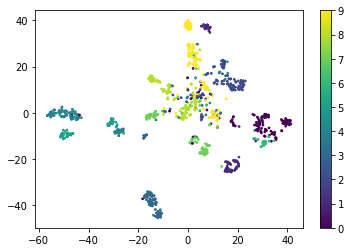

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

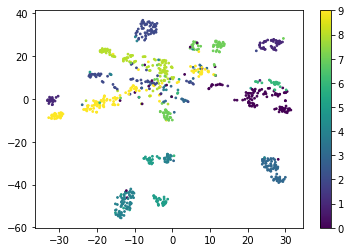

In [18]:
from umap import UMAP
mapper=UMAP()
embed_attentions=dr.fit_transform(attentions)

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## LLDL without Feature weighting

In [16]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
# learning_rate=0.001
learning_rate=0.01

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingLocalitySensitivewoFW",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "LocalitySensitivewoFW_{}".format("label"),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

In [17]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))

attentions_layer=attention_model.ConcatAttentions(
    n_attention=n_attention,
    n_attention_hidden=n_attention_hidden,
    n_attention_out=n_attention_out,
    n_feat=n_feat,
    n_hidden=n_concat_hidden,
    activation=concat_activation, 
    kernel_initializer=kernel_initializer,
    kernel_regularizer=l2(1E-5),
    bias_regularizer=l2(1E-5),
    attention_initializer=kernel_initializer,
    attention_hidden_activation=attention_hidden_activation,
    attention_output_activation=attention_output_activation,
    batch_norm_kwargs={"trainable":False, "renorm":False},
)(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(attentions_layer)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

LSwoFW_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

LSwoFW_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy','AUC']
             )

In [20]:
LSwoFW_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
concat_attentions (ConcatAtt (None, 128)               6730      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 19,211
Trainable params: 18,699
Non-trainable params: 512
_________________________________________________________________


In [18]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

n_epoch=2000


LSwoFW_model.fit(train_data, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_data, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 6s - loss: 0.8776 - accuracy: 0.5278 - auc: 0.5188 - val_loss: 0.7327 - val_accuracy: 0.5200 - val_auc: 0.4363

Epoch 00001: val_auc improved from -inf to 0.43633, saving model to 210222_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_label
Epoch 2/2000
113/113 - 3s - loss: 0.7350 - accuracy: 0.5167 - auc: 0.5141 - val_loss: 0.7022 - val_accuracy: 0.6700 - val_auc: 0.5613

Epoch 00002: val_auc improved from 0.43633 to 0.56133, saving model to 210222_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_label
Epoch 3/2000
113/113 - 3s - loss: 0.7327 - accuracy: 0.5600 - auc: 0.5714 - val_loss: 0.7429 - val_accuracy: 0.6500 - val_auc: 0.5351

Epoch 00003: val_auc did not improve from 0.56133
Epoch 4/2000
113/113 - 3s - loss: 0.7633 - accuracy: 0.5267 - auc: 0.5238 - val_loss: 0.9285 - val_accuracy: 0.3300 - val_auc: 0.6063

Epoch 00004: val_auc improved from 0.56133 to 0.60629, saving model to 210222_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_label
Epoch

113/113 - 3s - loss: 0.6560 - accuracy: 0.6789 - auc: 0.6749 - val_loss: 0.7193 - val_accuracy: 0.6600 - val_auc: 0.6414

Epoch 00042: val_auc did not improve from 0.68841
Epoch 43/2000
113/113 - 3s - loss: 0.6416 - accuracy: 0.7256 - auc: 0.7133 - val_loss: 0.6742 - val_accuracy: 0.6500 - val_auc: 0.6193

Epoch 00043: val_auc did not improve from 0.68841
Epoch 44/2000
113/113 - 3s - loss: 0.6909 - accuracy: 0.6511 - auc: 0.6700 - val_loss: 0.6641 - val_accuracy: 0.7000 - val_auc: 0.6442

Epoch 00044: val_auc did not improve from 0.68841
Epoch 45/2000
113/113 - 3s - loss: 0.6517 - accuracy: 0.6833 - auc: 0.6947 - val_loss: 0.6764 - val_accuracy: 0.2600 - val_auc: 0.6720

Epoch 00045: val_auc did not improve from 0.68841
Epoch 46/2000
113/113 - 3s - loss: 0.6472 - accuracy: 0.7222 - auc: 0.6950 - val_loss: 0.7174 - val_accuracy: 0.7600 - val_auc: 0.7009

Epoch 00046: val_auc improved from 0.68841 to 0.70088, saving model to 210222_TrainingLocalitySensitivewoFW\LocalitySensitivewoFW_labe


Epoch 00085: val_auc did not improve from 0.70374
Epoch 86/2000
113/113 - 3s - loss: 0.5595 - accuracy: 0.8067 - auc: 0.7861 - val_loss: 0.8496 - val_accuracy: 0.7400 - val_auc: 0.7001

Epoch 00086: val_auc did not improve from 0.70374
Epoch 87/2000
113/113 - 3s - loss: 0.6083 - accuracy: 0.7122 - auc: 0.7572 - val_loss: 1.2690 - val_accuracy: 0.7600 - val_auc: 0.6338

Epoch 00087: val_auc did not improve from 0.70374
Epoch 88/2000
113/113 - 3s - loss: 0.6512 - accuracy: 0.7533 - auc: 0.7621 - val_loss: 0.9032 - val_accuracy: 0.7500 - val_auc: 0.6905

Epoch 00088: val_auc did not improve from 0.70374
Epoch 89/2000
113/113 - 3s - loss: 0.6347 - accuracy: 0.6778 - auc: 0.7402 - val_loss: 0.7929 - val_accuracy: 0.7500 - val_auc: 0.6744

Epoch 00089: val_auc did not improve from 0.70374
Epoch 90/2000
113/113 - 3s - loss: 0.5950 - accuracy: 0.7711 - auc: 0.7318 - val_loss: 0.7117 - val_accuracy: 0.7300 - val_auc: 0.6770

Epoch 00090: val_auc did not improve from 0.70374
Epoch 91/2000
113/1


Epoch 00128: val_auc did not improve from 0.73259
Epoch 129/2000
113/113 - 3s - loss: 0.5433 - accuracy: 0.8167 - auc: 0.8064 - val_loss: 0.7198 - val_accuracy: 0.6900 - val_auc: 0.6076

Epoch 00129: val_auc did not improve from 0.73259
Epoch 130/2000
113/113 - 3s - loss: 0.5217 - accuracy: 0.8167 - auc: 0.8219 - val_loss: 0.7720 - val_accuracy: 0.7000 - val_auc: 0.6001

Epoch 00130: val_auc did not improve from 0.73259
Epoch 131/2000
113/113 - 3s - loss: 0.5262 - accuracy: 0.8000 - auc: 0.8237 - val_loss: 0.6841 - val_accuracy: 0.7200 - val_auc: 0.6928

Epoch 00131: val_auc did not improve from 0.73259
Epoch 132/2000
113/113 - 3s - loss: 0.5545 - accuracy: 0.7944 - auc: 0.8047 - val_loss: 0.9469 - val_accuracy: 0.7000 - val_auc: 0.6440

Epoch 00132: val_auc did not improve from 0.73259
Epoch 133/2000
113/113 - 3s - loss: 0.5317 - accuracy: 0.7956 - auc: 0.8173 - val_loss: 0.8699 - val_accuracy: 0.2600 - val_auc: 0.6476

Epoch 00133: val_auc did not improve from 0.73259
Epoch 134/2000


Epoch 00172: val_auc did not improve from 0.73259
Epoch 173/2000
113/113 - 3s - loss: 0.5608 - accuracy: 0.8211 - auc: 0.7985 - val_loss: 0.9058 - val_accuracy: 0.7200 - val_auc: 0.6577

Epoch 00173: val_auc did not improve from 0.73259
Epoch 174/2000
113/113 - 3s - loss: 0.5551 - accuracy: 0.7856 - auc: 0.7981 - val_loss: 1.0246 - val_accuracy: 0.7400 - val_auc: 0.6762

Epoch 00174: val_auc did not improve from 0.73259
Epoch 175/2000
113/113 - 3s - loss: 0.5063 - accuracy: 0.8356 - auc: 0.8270 - val_loss: 1.0207 - val_accuracy: 0.7200 - val_auc: 0.6492

Epoch 00175: val_auc did not improve from 0.73259
Epoch 176/2000
113/113 - 3s - loss: 0.5676 - accuracy: 0.8189 - auc: 0.8252 - val_loss: 0.9274 - val_accuracy: 0.7100 - val_auc: 0.6887

Epoch 00176: val_auc did not improve from 0.73259
Epoch 177/2000
113/113 - 3s - loss: 0.5510 - accuracy: 0.8233 - auc: 0.8171 - val_loss: 0.9596 - val_accuracy: 0.6900 - val_auc: 0.6473

Epoch 00177: val_auc did not improve from 0.73259
Epoch 178/2000


Epoch 00216: val_auc did not improve from 0.73259
Epoch 217/2000
113/113 - 3s - loss: 0.4799 - accuracy: 0.8433 - auc: 0.8509 - val_loss: 0.8783 - val_accuracy: 0.7100 - val_auc: 0.6351

Epoch 00217: val_auc did not improve from 0.73259
Epoch 218/2000
113/113 - 3s - loss: 0.4509 - accuracy: 0.8511 - auc: 0.8512 - val_loss: 0.8800 - val_accuracy: 0.7400 - val_auc: 0.6536

Epoch 00218: val_auc did not improve from 0.73259
Epoch 219/2000
113/113 - 3s - loss: 0.4631 - accuracy: 0.8678 - auc: 0.8415 - val_loss: 0.9479 - val_accuracy: 0.7100 - val_auc: 0.6429

Epoch 00219: val_auc did not improve from 0.73259
Epoch 220/2000
113/113 - 3s - loss: 0.4857 - accuracy: 0.8722 - auc: 0.8395 - val_loss: 0.9800 - val_accuracy: 0.6900 - val_auc: 0.6450

Epoch 00220: val_auc did not improve from 0.73259
Epoch 221/2000
113/113 - 3s - loss: 0.4419 - accuracy: 0.8867 - auc: 0.8557 - val_loss: 1.1276 - val_accuracy: 0.7200 - val_auc: 0.6128

Epoch 00221: val_auc did not improve from 0.73259
Epoch 222/2000


Epoch 00260: val_auc did not improve from 0.73259
Epoch 261/2000
113/113 - 3s - loss: 0.4076 - accuracy: 0.8722 - auc: 0.8762 - val_loss: 0.9435 - val_accuracy: 0.7400 - val_auc: 0.6754

Epoch 00261: val_auc did not improve from 0.73259
Epoch 262/2000
113/113 - 3s - loss: 0.4247 - accuracy: 0.8978 - auc: 0.8606 - val_loss: 1.0863 - val_accuracy: 0.7000 - val_auc: 0.6167

Epoch 00262: val_auc did not improve from 0.73259
Epoch 263/2000
113/113 - 3s - loss: 0.4815 - accuracy: 0.8478 - auc: 0.8598 - val_loss: 1.5448 - val_accuracy: 0.7000 - val_auc: 0.6466

Epoch 00263: val_auc did not improve from 0.73259
Epoch 264/2000
113/113 - 3s - loss: 0.4593 - accuracy: 0.8922 - auc: 0.8420 - val_loss: 0.9479 - val_accuracy: 0.7200 - val_auc: 0.6214

Epoch 00264: val_auc did not improve from 0.73259
Epoch 265/2000
113/113 - 3s - loss: 0.4357 - accuracy: 0.8722 - auc: 0.8604 - val_loss: 0.8373 - val_accuracy: 0.7000 - val_auc: 0.6229

Epoch 00265: val_auc did not improve from 0.73259
Epoch 266/2000


Epoch 00304: val_auc did not improve from 0.73259
Epoch 305/2000
113/113 - 3s - loss: 0.4753 - accuracy: 0.8833 - auc: 0.8352 - val_loss: 0.8362 - val_accuracy: 0.7500 - val_auc: 0.6765

Epoch 00305: val_auc did not improve from 0.73259
Epoch 306/2000
113/113 - 3s - loss: 0.4890 - accuracy: 0.8278 - auc: 0.8247 - val_loss: 0.8430 - val_accuracy: 0.7400 - val_auc: 0.6242

Epoch 00306: val_auc did not improve from 0.73259
Epoch 307/2000
113/113 - 3s - loss: 0.4931 - accuracy: 0.8522 - auc: 0.8432 - val_loss: 0.7285 - val_accuracy: 0.7600 - val_auc: 0.6341

Epoch 00307: val_auc did not improve from 0.73259
Epoch 308/2000
113/113 - 3s - loss: 0.4782 - accuracy: 0.8789 - auc: 0.8223 - val_loss: 0.8893 - val_accuracy: 0.7400 - val_auc: 0.6299

Epoch 00308: val_auc did not improve from 0.73259
Epoch 309/2000
113/113 - 3s - loss: 0.4574 - accuracy: 0.8833 - auc: 0.8326 - val_loss: 0.7576 - val_accuracy: 0.7400 - val_auc: 0.6749

Epoch 00309: val_auc did not improve from 0.73259
Epoch 310/2000


Epoch 00348: val_auc did not improve from 0.73259
Epoch 349/2000
113/113 - 3s - loss: 0.5669 - accuracy: 0.7622 - auc: 0.7887 - val_loss: 0.9540 - val_accuracy: 0.7500 - val_auc: 0.6585

Epoch 00349: val_auc did not improve from 0.73259
Epoch 350/2000
113/113 - 3s - loss: 0.4834 - accuracy: 0.8644 - auc: 0.8380 - val_loss: 0.6943 - val_accuracy: 0.7500 - val_auc: 0.6554

Epoch 00350: val_auc did not improve from 0.73259
Epoch 351/2000
113/113 - 3s - loss: 0.4808 - accuracy: 0.8600 - auc: 0.8120 - val_loss: 0.9252 - val_accuracy: 0.7300 - val_auc: 0.6707

Epoch 00351: val_auc did not improve from 0.73259
Epoch 352/2000
113/113 - 3s - loss: 0.5493 - accuracy: 0.7533 - auc: 0.7874 - val_loss: 0.8833 - val_accuracy: 0.7600 - val_auc: 0.6364

Epoch 00352: val_auc did not improve from 0.73259
Epoch 353/2000
113/113 - 3s - loss: 0.5057 - accuracy: 0.8244 - auc: 0.7986 - val_loss: 0.8388 - val_accuracy: 0.7500 - val_auc: 0.6562

Epoch 00353: val_auc did not improve from 0.73259
Epoch 354/2000


Epoch 00392: val_auc did not improve from 0.73259
Epoch 393/2000
113/113 - 3s - loss: 0.5522 - accuracy: 0.8022 - auc: 0.7856 - val_loss: 0.7943 - val_accuracy: 0.7400 - val_auc: 0.6130

Epoch 00393: val_auc did not improve from 0.73259
Epoch 394/2000
113/113 - 2s - loss: 0.5909 - accuracy: 0.7789 - auc: 0.7747 - val_loss: 1.0613 - val_accuracy: 0.7500 - val_auc: 0.6130

Epoch 00394: val_auc did not improve from 0.73259
Epoch 395/2000
113/113 - 3s - loss: 0.5553 - accuracy: 0.7767 - auc: 0.7789 - val_loss: 0.7994 - val_accuracy: 0.7400 - val_auc: 0.5995

Epoch 00395: val_auc did not improve from 0.73259
Epoch 396/2000
113/113 - 3s - loss: 0.5607 - accuracy: 0.7911 - auc: 0.7528 - val_loss: 0.7339 - val_accuracy: 0.7600 - val_auc: 0.5881

Epoch 00396: val_auc did not improve from 0.73259
Epoch 397/2000
113/113 - 3s - loss: 0.5713 - accuracy: 0.7867 - auc: 0.7700 - val_loss: 0.9292 - val_accuracy: 0.2600 - val_auc: 0.5826

Epoch 00397: val_auc did not improve from 0.73259
Epoch 398/2000


Epoch 00435: val_auc did not improve from 0.76637
Epoch 436/2000
113/113 - 3s - loss: 0.5602 - accuracy: 0.7900 - auc: 0.7694 - val_loss: 1.3672 - val_accuracy: 0.7600 - val_auc: 0.6601

Epoch 00436: val_auc did not improve from 0.76637
Epoch 437/2000
113/113 - 3s - loss: 0.5563 - accuracy: 0.7922 - auc: 0.7971 - val_loss: 0.8696 - val_accuracy: 0.2600 - val_auc: 0.6398

Epoch 00437: val_auc did not improve from 0.76637
Epoch 438/2000
113/113 - 3s - loss: 0.5325 - accuracy: 0.7922 - auc: 0.7816 - val_loss: 0.7866 - val_accuracy: 0.7800 - val_auc: 0.6650

Epoch 00438: val_auc did not improve from 0.76637
Epoch 439/2000
113/113 - 3s - loss: 0.5420 - accuracy: 0.7789 - auc: 0.7918 - val_loss: 0.9549 - val_accuracy: 0.7700 - val_auc: 0.6741

Epoch 00439: val_auc did not improve from 0.76637
Epoch 440/2000
113/113 - 3s - loss: 0.4994 - accuracy: 0.8367 - auc: 0.8092 - val_loss: 0.7551 - val_accuracy: 0.7700 - val_auc: 0.6762

Epoch 00440: val_auc did not improve from 0.76637
Epoch 441/2000


Epoch 00479: val_auc did not improve from 0.76637
Epoch 480/2000
113/113 - 3s - loss: 0.5196 - accuracy: 0.8333 - auc: 0.8065 - val_loss: 0.9759 - val_accuracy: 0.7600 - val_auc: 0.6367

Epoch 00480: val_auc did not improve from 0.76637
Epoch 481/2000
113/113 - 3s - loss: 0.5305 - accuracy: 0.8511 - auc: 0.7751 - val_loss: 0.6960 - val_accuracy: 0.7600 - val_auc: 0.6448

Epoch 00481: val_auc did not improve from 0.76637
Epoch 482/2000
113/113 - 3s - loss: 0.5638 - accuracy: 0.7800 - auc: 0.8007 - val_loss: 0.8372 - val_accuracy: 0.7600 - val_auc: 0.6242

Epoch 00482: val_auc did not improve from 0.76637
Epoch 483/2000
113/113 - 3s - loss: 0.5375 - accuracy: 0.8033 - auc: 0.7745 - val_loss: 0.7532 - val_accuracy: 0.7600 - val_auc: 0.6255

Epoch 00483: val_auc did not improve from 0.76637
Epoch 484/2000
113/113 - 3s - loss: 0.5060 - accuracy: 0.8467 - auc: 0.8013 - val_loss: 0.7051 - val_accuracy: 0.7500 - val_auc: 0.6195

Epoch 00484: val_auc did not improve from 0.76637
Epoch 485/2000


Epoch 00523: val_auc did not improve from 0.76637
Epoch 524/2000
113/113 - 3s - loss: 0.4706 - accuracy: 0.8822 - auc: 0.8100 - val_loss: 0.8269 - val_accuracy: 0.7400 - val_auc: 0.6242

Epoch 00524: val_auc did not improve from 0.76637
Epoch 525/2000
113/113 - 3s - loss: 0.4584 - accuracy: 0.8356 - auc: 0.8407 - val_loss: 1.0085 - val_accuracy: 0.7300 - val_auc: 0.6318

Epoch 00525: val_auc did not improve from 0.76637
Epoch 526/2000
113/113 - 3s - loss: 0.4677 - accuracy: 0.8700 - auc: 0.8191 - val_loss: 0.9604 - val_accuracy: 0.7600 - val_auc: 0.6195

Epoch 00526: val_auc did not improve from 0.76637
Epoch 527/2000
113/113 - 3s - loss: 0.4696 - accuracy: 0.8733 - auc: 0.8212 - val_loss: 0.9184 - val_accuracy: 0.2600 - val_auc: 0.6273

Epoch 00527: val_auc did not improve from 0.76637
Epoch 528/2000
113/113 - 3s - loss: 0.4967 - accuracy: 0.8444 - auc: 0.8153 - val_loss: 1.0883 - val_accuracy: 0.7400 - val_auc: 0.6341

Epoch 00528: val_auc did not improve from 0.76637
Epoch 529/2000


Epoch 00567: val_auc did not improve from 0.76637
Epoch 568/2000
113/113 - 3s - loss: 0.5483 - accuracy: 0.7822 - auc: 0.7812 - val_loss: 0.7789 - val_accuracy: 0.7600 - val_auc: 0.6757

Epoch 00568: val_auc did not improve from 0.76637
Epoch 569/2000
113/113 - 3s - loss: 0.5414 - accuracy: 0.8422 - auc: 0.7801 - val_loss: 0.7325 - val_accuracy: 0.7600 - val_auc: 0.6377

Epoch 00569: val_auc did not improve from 0.76637
Epoch 570/2000
113/113 - 3s - loss: 0.5316 - accuracy: 0.7989 - auc: 0.7887 - val_loss: 0.7605 - val_accuracy: 0.7800 - val_auc: 0.6674

Epoch 00570: val_auc did not improve from 0.76637
Epoch 571/2000
113/113 - 3s - loss: 0.5556 - accuracy: 0.8078 - auc: 0.7638 - val_loss: 0.7071 - val_accuracy: 0.7700 - val_auc: 0.6523

Epoch 00571: val_auc did not improve from 0.76637
Epoch 572/2000
113/113 - 3s - loss: 0.5628 - accuracy: 0.8000 - auc: 0.7686 - val_loss: 0.7185 - val_accuracy: 0.7800 - val_auc: 0.6694

Epoch 00572: val_auc did not improve from 0.76637
Epoch 573/2000


Epoch 00611: val_auc did not improve from 0.76637
Epoch 612/2000
113/113 - 3s - loss: 0.5419 - accuracy: 0.8011 - auc: 0.7868 - val_loss: 0.8327 - val_accuracy: 0.7700 - val_auc: 0.6572

Epoch 00612: val_auc did not improve from 0.76637
Epoch 613/2000
113/113 - 3s - loss: 0.5038 - accuracy: 0.8267 - auc: 0.7954 - val_loss: 0.8702 - val_accuracy: 0.8000 - val_auc: 0.6525

Epoch 00613: val_auc did not improve from 0.76637
Epoch 614/2000
113/113 - 3s - loss: 0.5570 - accuracy: 0.8300 - auc: 0.7936 - val_loss: 0.9871 - val_accuracy: 0.7800 - val_auc: 0.6645

Epoch 00614: val_auc did not improve from 0.76637
Epoch 615/2000
113/113 - 3s - loss: 0.5807 - accuracy: 0.7467 - auc: 0.7872 - val_loss: 0.8483 - val_accuracy: 0.7500 - val_auc: 0.6297

Epoch 00615: val_auc did not improve from 0.76637
Epoch 616/2000
113/113 - 3s - loss: 0.5436 - accuracy: 0.8256 - auc: 0.8030 - val_loss: 0.7725 - val_accuracy: 0.7400 - val_auc: 0.6460

Epoch 00616: val_auc did not improve from 0.76637
Epoch 617/2000


Epoch 00655: val_auc did not improve from 0.76637
Epoch 656/2000
113/113 - 3s - loss: 0.5657 - accuracy: 0.7867 - auc: 0.7601 - val_loss: 0.7099 - val_accuracy: 0.7800 - val_auc: 0.6848

Epoch 00656: val_auc did not improve from 0.76637
Epoch 657/2000
113/113 - 3s - loss: 0.5472 - accuracy: 0.8067 - auc: 0.7576 - val_loss: 0.7336 - val_accuracy: 0.7900 - val_auc: 0.6936

Epoch 00657: val_auc did not improve from 0.76637
Epoch 658/2000
113/113 - 3s - loss: 0.5411 - accuracy: 0.8133 - auc: 0.7785 - val_loss: 0.7850 - val_accuracy: 0.7500 - val_auc: 0.6731

Epoch 00658: val_auc did not improve from 0.76637
Epoch 659/2000
113/113 - 3s - loss: 0.5722 - accuracy: 0.7800 - auc: 0.7408 - val_loss: 0.8293 - val_accuracy: 0.7500 - val_auc: 0.6614

Epoch 00659: val_auc did not improve from 0.76637
Epoch 660/2000
113/113 - 3s - loss: 0.6098 - accuracy: 0.7333 - auc: 0.7556 - val_loss: 0.7819 - val_accuracy: 0.7700 - val_auc: 0.6650

Epoch 00660: val_auc did not improve from 0.76637
Epoch 661/2000

113/113 - 3s - loss: 0.5002 - accuracy: 0.8411 - auc: 0.8194 - val_loss: 0.7696 - val_accuracy: 0.7200 - val_auc: 0.6273

Epoch 00699: val_auc did not improve from 0.76897
Epoch 700/2000
113/113 - 3s - loss: 0.5509 - accuracy: 0.7811 - auc: 0.7884 - val_loss: 0.8344 - val_accuracy: 0.2600 - val_auc: 0.5561

Epoch 00700: val_auc did not improve from 0.76897
Epoch 701/2000
113/113 - 3s - loss: 0.5291 - accuracy: 0.8033 - auc: 0.7933 - val_loss: 0.8339 - val_accuracy: 0.2600 - val_auc: 0.6060

Epoch 00701: val_auc did not improve from 0.76897
Epoch 702/2000
113/113 - 3s - loss: 0.5582 - accuracy: 0.8033 - auc: 0.7829 - val_loss: 0.8404 - val_accuracy: 0.7200 - val_auc: 0.6055

Epoch 00702: val_auc did not improve from 0.76897
Epoch 703/2000
113/113 - 3s - loss: 0.5177 - accuracy: 0.8589 - auc: 0.7867 - val_loss: 0.7734 - val_accuracy: 0.7200 - val_auc: 0.5881

Epoch 00703: val_auc did not improve from 0.76897
Epoch 704/2000
113/113 - 3s - loss: 0.5552 - accuracy: 0.7833 - auc: 0.7792 - va

113/113 - 3s - loss: 0.5473 - accuracy: 0.8100 - auc: 0.7946 - val_loss: 0.8845 - val_accuracy: 0.7400 - val_auc: 0.6242

Epoch 00743: val_auc did not improve from 0.76897
Epoch 744/2000
113/113 - 3s - loss: 0.5120 - accuracy: 0.8300 - auc: 0.8073 - val_loss: 0.8237 - val_accuracy: 0.7300 - val_auc: 0.6219

Epoch 00744: val_auc did not improve from 0.76897
Epoch 745/2000
113/113 - 3s - loss: 0.5302 - accuracy: 0.8233 - auc: 0.8178 - val_loss: 0.9633 - val_accuracy: 0.2600 - val_auc: 0.5798

Epoch 00745: val_auc did not improve from 0.76897
Epoch 746/2000
113/113 - 3s - loss: 0.5111 - accuracy: 0.8122 - auc: 0.8199 - val_loss: 0.7982 - val_accuracy: 0.7200 - val_auc: 0.5993

Epoch 00746: val_auc did not improve from 0.76897
Epoch 747/2000
113/113 - 3s - loss: 0.5232 - accuracy: 0.8167 - auc: 0.8147 - val_loss: 0.8017 - val_accuracy: 0.7300 - val_auc: 0.4938

Epoch 00747: val_auc did not improve from 0.76897
Epoch 748/2000
113/113 - 3s - loss: 0.4888 - accuracy: 0.8500 - auc: 0.8120 - va

113/113 - 3s - loss: 0.4690 - accuracy: 0.8644 - auc: 0.8419 - val_loss: 1.0098 - val_accuracy: 0.7700 - val_auc: 0.6593

Epoch 00787: val_auc did not improve from 0.76897
Epoch 788/2000
113/113 - 3s - loss: 0.4867 - accuracy: 0.8456 - auc: 0.8397 - val_loss: 0.7267 - val_accuracy: 0.7700 - val_auc: 0.6705

Epoch 00788: val_auc did not improve from 0.76897
Epoch 789/2000
113/113 - 3s - loss: 0.4519 - accuracy: 0.8633 - auc: 0.8504 - val_loss: 0.6794 - val_accuracy: 0.7700 - val_auc: 0.6806

Epoch 00789: val_auc did not improve from 0.76897
Epoch 790/2000
113/113 - 3s - loss: 0.4546 - accuracy: 0.8778 - auc: 0.8374 - val_loss: 0.7845 - val_accuracy: 0.7400 - val_auc: 0.6759

Epoch 00790: val_auc did not improve from 0.76897
Epoch 791/2000
113/113 - 3s - loss: 0.4737 - accuracy: 0.8589 - auc: 0.8559 - val_loss: 0.8865 - val_accuracy: 0.7600 - val_auc: 0.6583

Epoch 00791: val_auc did not improve from 0.76897
Epoch 792/2000
113/113 - 3s - loss: 0.5094 - accuracy: 0.8178 - auc: 0.8348 - va

113/113 - 3s - loss: 0.4656 - accuracy: 0.8656 - auc: 0.8430 - val_loss: 0.9011 - val_accuracy: 0.7300 - val_auc: 0.6367

Epoch 00831: val_auc did not improve from 0.76897
Epoch 832/2000
113/113 - 3s - loss: 0.4545 - accuracy: 0.8767 - auc: 0.8620 - val_loss: 0.7851 - val_accuracy: 0.7600 - val_auc: 0.6110

Epoch 00832: val_auc did not improve from 0.76897
Epoch 833/2000
113/113 - 3s - loss: 0.4801 - accuracy: 0.8256 - auc: 0.8355 - val_loss: 0.8923 - val_accuracy: 0.7300 - val_auc: 0.6505

Epoch 00833: val_auc did not improve from 0.76897
Epoch 834/2000
113/113 - 3s - loss: 0.5162 - accuracy: 0.8356 - auc: 0.8214 - val_loss: 0.7210 - val_accuracy: 0.7500 - val_auc: 0.6453

Epoch 00834: val_auc did not improve from 0.76897
Epoch 835/2000
113/113 - 3s - loss: 0.4638 - accuracy: 0.8722 - auc: 0.8316 - val_loss: 0.7352 - val_accuracy: 0.7300 - val_auc: 0.6575

Epoch 00835: val_auc did not improve from 0.76897
Epoch 836/2000
113/113 - 3s - loss: 0.4704 - accuracy: 0.8667 - auc: 0.8395 - va

113/113 - 3s - loss: 0.4592 - accuracy: 0.8511 - auc: 0.8521 - val_loss: 0.8101 - val_accuracy: 0.7200 - val_auc: 0.6029

Epoch 00875: val_auc did not improve from 0.76897
Epoch 876/2000
113/113 - 3s - loss: 0.4569 - accuracy: 0.8622 - auc: 0.8541 - val_loss: 0.9424 - val_accuracy: 0.7000 - val_auc: 0.6188

Epoch 00876: val_auc did not improve from 0.76897
Epoch 877/2000
113/113 - 3s - loss: 0.4657 - accuracy: 0.8578 - auc: 0.8482 - val_loss: 0.8730 - val_accuracy: 0.7400 - val_auc: 0.5930

Epoch 00877: val_auc did not improve from 0.76897
Epoch 878/2000
113/113 - 3s - loss: 0.4384 - accuracy: 0.8811 - auc: 0.8368 - val_loss: 1.0428 - val_accuracy: 0.7400 - val_auc: 0.6063

Epoch 00878: val_auc did not improve from 0.76897
Epoch 879/2000
113/113 - 3s - loss: 0.4667 - accuracy: 0.8533 - auc: 0.8478 - val_loss: 0.9051 - val_accuracy: 0.7300 - val_auc: 0.5951

Epoch 00879: val_auc did not improve from 0.76897
Epoch 880/2000
113/113 - 3s - loss: 0.4557 - accuracy: 0.8511 - auc: 0.8485 - va

113/113 - 3s - loss: 0.5110 - accuracy: 0.8156 - auc: 0.7952 - val_loss: 1.0938 - val_accuracy: 0.7500 - val_auc: 0.6107

Epoch 00919: val_auc did not improve from 0.76897
Epoch 920/2000
113/113 - 3s - loss: 0.5145 - accuracy: 0.8400 - auc: 0.7868 - val_loss: 0.9854 - val_accuracy: 0.7500 - val_auc: 0.6195

Epoch 00920: val_auc did not improve from 0.76897
Epoch 921/2000
113/113 - 3s - loss: 0.5453 - accuracy: 0.8078 - auc: 0.7797 - val_loss: 0.9303 - val_accuracy: 0.2600 - val_auc: 0.6084

Epoch 00921: val_auc did not improve from 0.76897
Epoch 922/2000
113/113 - 3s - loss: 0.5708 - accuracy: 0.7800 - auc: 0.7884 - val_loss: 1.0927 - val_accuracy: 0.7500 - val_auc: 0.6123

Epoch 00922: val_auc did not improve from 0.76897
Epoch 923/2000
113/113 - 3s - loss: 0.5060 - accuracy: 0.8222 - auc: 0.7948 - val_loss: 1.0075 - val_accuracy: 0.7500 - val_auc: 0.6310

Epoch 00923: val_auc did not improve from 0.76897
Epoch 924/2000
113/113 - 3s - loss: 0.5034 - accuracy: 0.8467 - auc: 0.7986 - va

113/113 - 3s - loss: 0.4948 - accuracy: 0.8467 - auc: 0.8008 - val_loss: 0.7705 - val_accuracy: 0.7600 - val_auc: 0.6177

Epoch 00963: val_auc did not improve from 0.76897
Epoch 964/2000
113/113 - 3s - loss: 0.4960 - accuracy: 0.8633 - auc: 0.8173 - val_loss: 1.0619 - val_accuracy: 0.7700 - val_auc: 0.6190

Epoch 00964: val_auc did not improve from 0.76897
Epoch 965/2000
113/113 - 3s - loss: 0.4868 - accuracy: 0.8400 - auc: 0.8238 - val_loss: 0.8866 - val_accuracy: 0.7500 - val_auc: 0.6172

Epoch 00965: val_auc did not improve from 0.76897
Epoch 966/2000
113/113 - 3s - loss: 0.4783 - accuracy: 0.8633 - auc: 0.8253 - val_loss: 0.8383 - val_accuracy: 0.7700 - val_auc: 0.6188

Epoch 00966: val_auc did not improve from 0.76897
Epoch 967/2000
113/113 - 3s - loss: 0.5087 - accuracy: 0.8256 - auc: 0.8047 - val_loss: 1.2641 - val_accuracy: 0.7700 - val_auc: 0.6149

Epoch 00967: val_auc did not improve from 0.76897
Epoch 968/2000
113/113 - 3s - loss: 0.5060 - accuracy: 0.8011 - auc: 0.8239 - va

113/113 - 3s - loss: 0.4925 - accuracy: 0.8456 - auc: 0.8153 - val_loss: 0.9645 - val_accuracy: 0.6800 - val_auc: 0.6718

Epoch 01007: val_auc did not improve from 0.76897
Epoch 1008/2000
113/113 - 3s - loss: 0.5388 - accuracy: 0.8078 - auc: 0.8038 - val_loss: 1.1848 - val_accuracy: 0.7500 - val_auc: 0.6759

Epoch 01008: val_auc did not improve from 0.76897
Epoch 1009/2000
113/113 - 3s - loss: 0.5181 - accuracy: 0.8333 - auc: 0.8069 - val_loss: 1.0331 - val_accuracy: 0.7600 - val_auc: 0.6346

Epoch 01009: val_auc did not improve from 0.76897
Epoch 1010/2000
113/113 - 3s - loss: 0.4935 - accuracy: 0.8478 - auc: 0.8109 - val_loss: 0.9536 - val_accuracy: 0.2600 - val_auc: 0.6520

Epoch 01010: val_auc did not improve from 0.76897
Epoch 1011/2000
113/113 - 3s - loss: 0.5355 - accuracy: 0.8100 - auc: 0.7946 - val_loss: 0.9812 - val_accuracy: 0.7500 - val_auc: 0.6505

Epoch 01011: val_auc did not improve from 0.76897
Epoch 1012/2000
113/113 - 3s - loss: 0.5078 - accuracy: 0.8033 - auc: 0.8220


Epoch 01050: val_auc did not improve from 0.76897
Epoch 1051/2000
113/113 - 3s - loss: 0.5995 - accuracy: 0.8100 - auc: 0.7853 - val_loss: 1.1159 - val_accuracy: 0.7100 - val_auc: 0.6180

Epoch 01051: val_auc did not improve from 0.76897
Epoch 1052/2000
113/113 - 3s - loss: 0.5227 - accuracy: 0.8178 - auc: 0.8021 - val_loss: 0.9706 - val_accuracy: 0.7200 - val_auc: 0.6427

Epoch 01052: val_auc did not improve from 0.76897
Epoch 1053/2000
113/113 - 3s - loss: 0.4823 - accuracy: 0.8556 - auc: 0.8164 - val_loss: 0.9663 - val_accuracy: 0.7500 - val_auc: 0.6219

Epoch 01053: val_auc did not improve from 0.76897
Epoch 1054/2000
113/113 - 3s - loss: 0.4994 - accuracy: 0.8367 - auc: 0.8170 - val_loss: 0.9753 - val_accuracy: 0.7200 - val_auc: 0.6151

Epoch 01054: val_auc did not improve from 0.76897
Epoch 1055/2000
113/113 - 3s - loss: 0.5032 - accuracy: 0.8389 - auc: 0.8078 - val_loss: 1.0709 - val_accuracy: 0.7200 - val_auc: 0.6255

Epoch 01055: val_auc did not improve from 0.76897
Epoch 105


Epoch 01094: val_auc did not improve from 0.76897
Epoch 1095/2000
113/113 - 3s - loss: 0.4918 - accuracy: 0.8344 - auc: 0.8107 - val_loss: 1.1009 - val_accuracy: 0.7300 - val_auc: 0.5951

Epoch 01095: val_auc did not improve from 0.76897
Epoch 1096/2000
113/113 - 3s - loss: 0.4977 - accuracy: 0.8733 - auc: 0.8257 - val_loss: 0.8372 - val_accuracy: 0.7100 - val_auc: 0.5819

Epoch 01096: val_auc did not improve from 0.76897
Epoch 1097/2000
113/113 - 3s - loss: 0.5272 - accuracy: 0.8378 - auc: 0.7987 - val_loss: 1.0804 - val_accuracy: 0.7000 - val_auc: 0.5943

Epoch 01097: val_auc did not improve from 0.76897
Epoch 1098/2000
113/113 - 3s - loss: 0.5116 - accuracy: 0.8511 - auc: 0.8080 - val_loss: 0.9182 - val_accuracy: 0.6800 - val_auc: 0.5541

Epoch 01098: val_auc did not improve from 0.76897
Epoch 1099/2000
113/113 - 3s - loss: 0.5680 - accuracy: 0.7878 - auc: 0.7950 - val_loss: 0.9077 - val_accuracy: 0.2600 - val_auc: 0.5741

Epoch 01099: val_auc did not improve from 0.76897
Epoch 110


Epoch 01138: val_auc did not improve from 0.76897
Epoch 1139/2000
113/113 - 3s - loss: 0.5381 - accuracy: 0.8189 - auc: 0.7963 - val_loss: 1.1454 - val_accuracy: 0.7000 - val_auc: 0.5556

Epoch 01139: val_auc did not improve from 0.76897
Epoch 1140/2000
113/113 - 3s - loss: 0.5231 - accuracy: 0.8133 - auc: 0.8106 - val_loss: 0.9419 - val_accuracy: 0.7000 - val_auc: 0.5512

Epoch 01140: val_auc did not improve from 0.76897
Epoch 1141/2000
113/113 - 3s - loss: 0.4911 - accuracy: 0.8678 - auc: 0.8099 - val_loss: 0.9146 - val_accuracy: 0.7000 - val_auc: 0.5535

Epoch 01141: val_auc did not improve from 0.76897
Epoch 1142/2000
113/113 - 3s - loss: 0.4949 - accuracy: 0.8333 - auc: 0.8108 - val_loss: 0.9589 - val_accuracy: 0.6700 - val_auc: 0.5655

Epoch 01142: val_auc did not improve from 0.76897
Epoch 1143/2000
113/113 - 3s - loss: 0.4856 - accuracy: 0.8533 - auc: 0.8265 - val_loss: 1.2072 - val_accuracy: 0.6600 - val_auc: 0.5619

Epoch 01143: val_auc did not improve from 0.76897
Epoch 114


Epoch 01182: val_auc did not improve from 0.76897
Epoch 1183/2000
113/113 - 3s - loss: 0.5316 - accuracy: 0.8033 - auc: 0.8216 - val_loss: 1.0860 - val_accuracy: 0.6500 - val_auc: 0.5478

Epoch 01183: val_auc did not improve from 0.76897
Epoch 1184/2000
113/113 - 3s - loss: 0.4852 - accuracy: 0.8422 - auc: 0.8358 - val_loss: 1.1546 - val_accuracy: 0.6500 - val_auc: 0.5564

Epoch 01184: val_auc did not improve from 0.76897
Epoch 1185/2000
113/113 - 3s - loss: 0.5243 - accuracy: 0.8178 - auc: 0.8212 - val_loss: 0.9120 - val_accuracy: 0.7200 - val_auc: 0.5741

Epoch 01185: val_auc did not improve from 0.76897
Epoch 1186/2000
113/113 - 3s - loss: 0.5479 - accuracy: 0.8000 - auc: 0.8170 - val_loss: 1.0608 - val_accuracy: 0.7100 - val_auc: 0.5689

Epoch 01186: val_auc did not improve from 0.76897
Epoch 1187/2000
113/113 - 3s - loss: 0.5280 - accuracy: 0.8367 - auc: 0.8024 - val_loss: 1.0906 - val_accuracy: 0.6900 - val_auc: 0.5707

Epoch 01187: val_auc did not improve from 0.76897
Epoch 118


Epoch 01226: val_auc did not improve from 0.76897
Epoch 1227/2000
113/113 - 3s - loss: 0.5014 - accuracy: 0.8411 - auc: 0.8104 - val_loss: 1.1637 - val_accuracy: 0.6600 - val_auc: 0.5252

Epoch 01227: val_auc did not improve from 0.76897
Epoch 1228/2000
113/113 - 3s - loss: 0.4725 - accuracy: 0.8667 - auc: 0.8239 - val_loss: 0.9470 - val_accuracy: 0.6700 - val_auc: 0.5382

Epoch 01228: val_auc did not improve from 0.76897
Epoch 1229/2000
113/113 - 3s - loss: 0.5065 - accuracy: 0.8356 - auc: 0.8149 - val_loss: 1.1705 - val_accuracy: 0.6800 - val_auc: 0.5533

Epoch 01229: val_auc did not improve from 0.76897
Epoch 1230/2000
113/113 - 3s - loss: 0.4695 - accuracy: 0.8378 - auc: 0.8450 - val_loss: 1.0538 - val_accuracy: 0.6800 - val_auc: 0.5322

Epoch 01230: val_auc did not improve from 0.76897
Epoch 1231/2000
113/113 - 3s - loss: 0.4896 - accuracy: 0.8511 - auc: 0.8221 - val_loss: 1.2426 - val_accuracy: 0.6400 - val_auc: 0.5304

Epoch 01231: val_auc did not improve from 0.76897
Epoch 123


Epoch 01270: val_auc did not improve from 0.76897
Epoch 1271/2000
113/113 - 3s - loss: 0.4822 - accuracy: 0.8733 - auc: 0.8374 - val_loss: 1.0438 - val_accuracy: 0.6500 - val_auc: 0.5743

Epoch 01271: val_auc did not improve from 0.76897
Epoch 1272/2000
113/113 - 3s - loss: 0.4791 - accuracy: 0.8411 - auc: 0.8354 - val_loss: 1.0691 - val_accuracy: 0.7000 - val_auc: 0.5959

Epoch 01272: val_auc did not improve from 0.76897
Epoch 1273/2000
113/113 - 3s - loss: 0.4979 - accuracy: 0.8222 - auc: 0.8485 - val_loss: 1.0784 - val_accuracy: 0.6800 - val_auc: 0.6006

Epoch 01273: val_auc did not improve from 0.76897
Epoch 1274/2000
113/113 - 3s - loss: 0.4742 - accuracy: 0.8600 - auc: 0.8311 - val_loss: 1.3812 - val_accuracy: 0.7300 - val_auc: 0.5850

Epoch 01274: val_auc did not improve from 0.76897
Epoch 1275/2000
113/113 - 3s - loss: 0.4812 - accuracy: 0.8700 - auc: 0.8339 - val_loss: 0.9754 - val_accuracy: 0.6800 - val_auc: 0.5782

Epoch 01275: val_auc did not improve from 0.76897
Epoch 127


Epoch 01314: val_auc did not improve from 0.76897
Epoch 1315/2000
113/113 - 2s - loss: 0.4885 - accuracy: 0.8589 - auc: 0.8313 - val_loss: 0.9448 - val_accuracy: 0.7400 - val_auc: 0.6266

Epoch 01315: val_auc did not improve from 0.76897
Epoch 1316/2000
113/113 - 3s - loss: 0.5126 - accuracy: 0.8289 - auc: 0.8215 - val_loss: 0.9259 - val_accuracy: 0.7100 - val_auc: 0.5868

Epoch 01316: val_auc did not improve from 0.76897
Epoch 1317/2000
113/113 - 3s - loss: 0.4873 - accuracy: 0.8400 - auc: 0.8279 - val_loss: 0.9284 - val_accuracy: 0.7100 - val_auc: 0.5954

Epoch 01317: val_auc did not improve from 0.76897
Epoch 1318/2000
113/113 - 3s - loss: 0.4662 - accuracy: 0.8489 - auc: 0.8305 - val_loss: 0.9435 - val_accuracy: 0.2700 - val_auc: 0.5613

Epoch 01318: val_auc did not improve from 0.76897
Epoch 1319/2000
113/113 - 3s - loss: 0.4571 - accuracy: 0.8456 - auc: 0.8532 - val_loss: 1.0260 - val_accuracy: 0.7100 - val_auc: 0.5845

Epoch 01319: val_auc did not improve from 0.76897
Epoch 132


Epoch 01358: val_auc did not improve from 0.76897
Epoch 1359/2000
113/113 - 3s - loss: 0.4454 - accuracy: 0.8822 - auc: 0.8579 - val_loss: 1.2477 - val_accuracy: 0.2600 - val_auc: 0.6258

Epoch 01359: val_auc did not improve from 0.76897
Epoch 1360/2000
113/113 - 3s - loss: 0.4936 - accuracy: 0.8356 - auc: 0.8331 - val_loss: 1.0502 - val_accuracy: 0.7100 - val_auc: 0.5868

Epoch 01360: val_auc did not improve from 0.76897
Epoch 1361/2000
113/113 - 3s - loss: 0.4802 - accuracy: 0.8733 - auc: 0.8363 - val_loss: 0.9616 - val_accuracy: 0.7100 - val_auc: 0.6367

Epoch 01361: val_auc did not improve from 0.76897
Epoch 1362/2000
113/113 - 3s - loss: 0.4580 - accuracy: 0.8589 - auc: 0.8433 - val_loss: 1.0213 - val_accuracy: 0.7100 - val_auc: 0.6341

Epoch 01362: val_auc did not improve from 0.76897
Epoch 1363/2000
113/113 - 3s - loss: 0.4538 - accuracy: 0.8956 - auc: 0.8255 - val_loss: 0.9717 - val_accuracy: 0.7200 - val_auc: 0.6460

Epoch 01363: val_auc did not improve from 0.76897
Epoch 136


Epoch 01402: val_auc did not improve from 0.76897
Epoch 1403/2000
113/113 - 3s - loss: 0.4964 - accuracy: 0.8322 - auc: 0.8336 - val_loss: 1.0682 - val_accuracy: 0.6600 - val_auc: 0.5626

Epoch 01403: val_auc did not improve from 0.76897
Epoch 1404/2000
113/113 - 3s - loss: 0.5096 - accuracy: 0.7844 - auc: 0.8308 - val_loss: 0.7983 - val_accuracy: 0.7000 - val_auc: 0.6081

Epoch 01404: val_auc did not improve from 0.76897
Epoch 1405/2000
113/113 - 3s - loss: 0.5174 - accuracy: 0.8122 - auc: 0.8182 - val_loss: 0.9773 - val_accuracy: 0.7000 - val_auc: 0.6097

Epoch 01405: val_auc did not improve from 0.76897
Epoch 1406/2000
113/113 - 3s - loss: 0.5156 - accuracy: 0.8189 - auc: 0.8113 - val_loss: 1.1900 - val_accuracy: 0.6800 - val_auc: 0.5590

Epoch 01406: val_auc did not improve from 0.76897
Epoch 1407/2000
113/113 - 3s - loss: 0.5027 - accuracy: 0.8600 - auc: 0.8018 - val_loss: 0.9980 - val_accuracy: 0.6800 - val_auc: 0.5787

Epoch 01407: val_auc did not improve from 0.76897
Epoch 140


Epoch 01446: val_auc did not improve from 0.76897
Epoch 1447/2000
113/113 - 3s - loss: 0.4698 - accuracy: 0.8500 - auc: 0.8325 - val_loss: 1.2309 - val_accuracy: 0.7100 - val_auc: 0.5483

Epoch 01447: val_auc did not improve from 0.76897
Epoch 1448/2000
113/113 - 3s - loss: 0.4789 - accuracy: 0.8289 - auc: 0.8383 - val_loss: 1.1098 - val_accuracy: 0.7100 - val_auc: 0.6115

Epoch 01448: val_auc did not improve from 0.76897
Epoch 1449/2000
113/113 - 3s - loss: 0.4588 - accuracy: 0.8767 - auc: 0.8402 - val_loss: 0.9027 - val_accuracy: 0.7200 - val_auc: 0.6182

Epoch 01449: val_auc did not improve from 0.76897
Epoch 1450/2000
113/113 - 3s - loss: 0.4310 - accuracy: 0.8733 - auc: 0.8615 - val_loss: 0.9700 - val_accuracy: 0.6900 - val_auc: 0.6180

Epoch 01450: val_auc did not improve from 0.76897
Epoch 1451/2000
113/113 - 3s - loss: 0.4360 - accuracy: 0.8644 - auc: 0.8515 - val_loss: 1.0271 - val_accuracy: 0.7000 - val_auc: 0.6052

Epoch 01451: val_auc did not improve from 0.76897
Epoch 145


Epoch 01490: val_auc did not improve from 0.76897
Epoch 1491/2000
113/113 - 3s - loss: 0.4374 - accuracy: 0.8622 - auc: 0.8745 - val_loss: 1.7761 - val_accuracy: 0.7500 - val_auc: 0.6557

Epoch 01491: val_auc did not improve from 0.76897
Epoch 1492/2000
113/113 - 3s - loss: 0.4570 - accuracy: 0.8667 - auc: 0.8654 - val_loss: 1.3492 - val_accuracy: 0.7300 - val_auc: 0.6034

Epoch 01492: val_auc did not improve from 0.76897
Epoch 1493/2000
113/113 - 3s - loss: 0.4521 - accuracy: 0.8544 - auc: 0.8686 - val_loss: 1.0444 - val_accuracy: 0.7600 - val_auc: 0.6268

Epoch 01493: val_auc did not improve from 0.76897
Epoch 1494/2000
113/113 - 3s - loss: 0.4119 - accuracy: 0.8644 - auc: 0.8853 - val_loss: 0.8807 - val_accuracy: 0.7300 - val_auc: 0.6668

Epoch 01494: val_auc did not improve from 0.76897
Epoch 1495/2000
113/113 - 3s - loss: 0.4130 - accuracy: 0.8800 - auc: 0.8716 - val_loss: 1.1746 - val_accuracy: 0.7300 - val_auc: 0.6320

Epoch 01495: val_auc did not improve from 0.76897
Epoch 149


Epoch 01534: val_auc did not improve from 0.76897
Epoch 1535/2000
113/113 - 3s - loss: 0.4697 - accuracy: 0.8411 - auc: 0.8616 - val_loss: 0.8242 - val_accuracy: 0.6900 - val_auc: 0.6133

Epoch 01535: val_auc did not improve from 0.76897
Epoch 1536/2000
113/113 - 3s - loss: 0.4065 - accuracy: 0.8667 - auc: 0.8844 - val_loss: 0.9154 - val_accuracy: 0.7100 - val_auc: 0.5761

Epoch 01536: val_auc did not improve from 0.76897
Epoch 1537/2000
113/113 - 3s - loss: 0.4439 - accuracy: 0.8444 - auc: 0.8601 - val_loss: 0.9428 - val_accuracy: 0.7000 - val_auc: 0.5722

Epoch 01537: val_auc did not improve from 0.76897
Epoch 1538/2000
113/113 - 3s - loss: 0.4679 - accuracy: 0.8622 - auc: 0.8554 - val_loss: 0.9664 - val_accuracy: 0.6800 - val_auc: 0.5663

Epoch 01538: val_auc did not improve from 0.76897
Epoch 1539/2000
113/113 - 3s - loss: 0.4169 - accuracy: 0.8933 - auc: 0.8670 - val_loss: 1.1337 - val_accuracy: 0.6800 - val_auc: 0.5567

Epoch 01539: val_auc did not improve from 0.76897
Epoch 154


Epoch 01578: val_auc did not improve from 0.76897
Epoch 1579/2000
113/113 - 3s - loss: 0.4576 - accuracy: 0.8400 - auc: 0.8798 - val_loss: 0.8908 - val_accuracy: 0.6200 - val_auc: 0.6585

Epoch 01579: val_auc did not improve from 0.76897
Epoch 1580/2000
113/113 - 2s - loss: 0.4489 - accuracy: 0.8467 - auc: 0.8719 - val_loss: 0.9691 - val_accuracy: 0.6800 - val_auc: 0.6689

Epoch 01580: val_auc did not improve from 0.76897
Epoch 1581/2000
113/113 - 3s - loss: 0.4478 - accuracy: 0.8556 - auc: 0.8632 - val_loss: 0.8753 - val_accuracy: 0.6800 - val_auc: 0.5782

Epoch 01581: val_auc did not improve from 0.76897
Epoch 1582/2000
113/113 - 3s - loss: 0.4552 - accuracy: 0.8711 - auc: 0.8434 - val_loss: 1.0557 - val_accuracy: 0.6700 - val_auc: 0.5850

Epoch 01582: val_auc did not improve from 0.76897
Epoch 1583/2000
113/113 - 3s - loss: 0.4739 - accuracy: 0.8667 - auc: 0.8612 - val_loss: 0.8481 - val_accuracy: 0.6500 - val_auc: 0.5582

Epoch 01583: val_auc did not improve from 0.76897
Epoch 158


Epoch 01622: val_auc did not improve from 0.76897
Epoch 1623/2000
113/113 - 3s - loss: 0.4379 - accuracy: 0.8778 - auc: 0.8610 - val_loss: 0.8951 - val_accuracy: 0.7100 - val_auc: 0.6414

Epoch 01623: val_auc did not improve from 0.76897
Epoch 1624/2000
113/113 - 3s - loss: 0.4801 - accuracy: 0.8533 - auc: 0.8524 - val_loss: 0.8391 - val_accuracy: 0.7400 - val_auc: 0.6159

Epoch 01624: val_auc did not improve from 0.76897
Epoch 1625/2000
113/113 - 3s - loss: 0.4451 - accuracy: 0.8778 - auc: 0.8620 - val_loss: 0.9015 - val_accuracy: 0.7200 - val_auc: 0.6110

Epoch 01625: val_auc did not improve from 0.76897
Epoch 1626/2000
113/113 - 3s - loss: 0.4286 - accuracy: 0.8867 - auc: 0.8641 - val_loss: 1.7023 - val_accuracy: 0.7600 - val_auc: 0.6390

Epoch 01626: val_auc did not improve from 0.76897
Epoch 1627/2000
113/113 - 2s - loss: 0.4551 - accuracy: 0.8767 - auc: 0.8667 - val_loss: 0.8700 - val_accuracy: 0.7200 - val_auc: 0.6008

Epoch 01627: val_auc did not improve from 0.76897
Epoch 162


Epoch 01666: val_auc did not improve from 0.76897
Epoch 1667/2000
113/113 - 3s - loss: 0.4847 - accuracy: 0.8556 - auc: 0.8576 - val_loss: 1.0274 - val_accuracy: 0.7100 - val_auc: 0.5683

Epoch 01667: val_auc did not improve from 0.76897
Epoch 1668/2000
113/113 - 3s - loss: 0.5589 - accuracy: 0.8200 - auc: 0.8386 - val_loss: 1.3611 - val_accuracy: 0.7200 - val_auc: 0.6346

Epoch 01668: val_auc did not improve from 0.76897
Epoch 1669/2000
113/113 - 3s - loss: 0.5109 - accuracy: 0.8378 - auc: 0.8397 - val_loss: 0.8273 - val_accuracy: 0.7300 - val_auc: 0.6164

Epoch 01669: val_auc did not improve from 0.76897
Epoch 1670/2000
113/113 - 3s - loss: 0.4407 - accuracy: 0.8956 - auc: 0.8680 - val_loss: 0.8661 - val_accuracy: 0.2600 - val_auc: 0.6206

Epoch 01670: val_auc did not improve from 0.76897
Epoch 1671/2000
113/113 - 3s - loss: 0.4662 - accuracy: 0.8544 - auc: 0.8491 - val_loss: 0.9753 - val_accuracy: 0.7300 - val_auc: 0.6398

Epoch 01671: val_auc did not improve from 0.76897
Epoch 167


Epoch 01710: val_auc did not improve from 0.76897
Epoch 1711/2000
113/113 - 3s - loss: 0.4776 - accuracy: 0.8300 - auc: 0.8610 - val_loss: 1.0205 - val_accuracy: 0.7400 - val_auc: 0.6151

Epoch 01711: val_auc did not improve from 0.76897
Epoch 1712/2000
113/113 - 3s - loss: 0.4507 - accuracy: 0.8889 - auc: 0.8539 - val_loss: 1.1182 - val_accuracy: 0.7400 - val_auc: 0.6188

Epoch 01712: val_auc did not improve from 0.76897
Epoch 1713/2000
113/113 - 3s - loss: 0.4367 - accuracy: 0.8778 - auc: 0.8697 - val_loss: 0.9173 - val_accuracy: 0.7100 - val_auc: 0.5567

Epoch 01713: val_auc did not improve from 0.76897
Epoch 1714/2000
113/113 - 3s - loss: 0.4678 - accuracy: 0.8478 - auc: 0.8611 - val_loss: 1.4112 - val_accuracy: 0.7100 - val_auc: 0.6507

Epoch 01714: val_auc did not improve from 0.76897
Epoch 1715/2000
113/113 - 3s - loss: 0.4848 - accuracy: 0.8267 - auc: 0.8454 - val_loss: 1.0053 - val_accuracy: 0.7500 - val_auc: 0.6289

Epoch 01715: val_auc did not improve from 0.76897
Epoch 171


Epoch 01754: val_auc did not improve from 0.76897
Epoch 1755/2000
113/113 - 3s - loss: 0.4901 - accuracy: 0.8367 - auc: 0.8545 - val_loss: 1.0411 - val_accuracy: 0.7400 - val_auc: 0.6460

Epoch 01755: val_auc did not improve from 0.76897
Epoch 1756/2000
113/113 - 3s - loss: 0.4147 - accuracy: 0.8833 - auc: 0.8792 - val_loss: 1.0066 - val_accuracy: 0.7400 - val_auc: 0.6032

Epoch 01756: val_auc did not improve from 0.76897
Epoch 1757/2000
113/113 - 3s - loss: 0.4813 - accuracy: 0.8256 - auc: 0.8621 - val_loss: 1.1176 - val_accuracy: 0.7500 - val_auc: 0.6689

Epoch 01757: val_auc did not improve from 0.76897
Epoch 1758/2000
113/113 - 3s - loss: 0.4376 - accuracy: 0.8878 - auc: 0.8633 - val_loss: 1.0418 - val_accuracy: 0.7500 - val_auc: 0.6344

Epoch 01758: val_auc did not improve from 0.76897
Epoch 1759/2000
113/113 - 3s - loss: 0.4202 - accuracy: 0.8822 - auc: 0.8701 - val_loss: 0.9435 - val_accuracy: 0.7500 - val_auc: 0.6473

Epoch 01759: val_auc did not improve from 0.76897
Epoch 176


Epoch 01798: val_auc did not improve from 0.76897
Epoch 1799/2000
113/113 - 3s - loss: 0.4354 - accuracy: 0.8978 - auc: 0.8600 - val_loss: 0.7813 - val_accuracy: 0.7500 - val_auc: 0.6409

Epoch 01799: val_auc did not improve from 0.76897
Epoch 1800/2000
113/113 - 3s - loss: 0.4032 - accuracy: 0.8922 - auc: 0.8830 - val_loss: 0.9768 - val_accuracy: 0.7500 - val_auc: 0.6260

Epoch 01800: val_auc did not improve from 0.76897
Epoch 1801/2000
113/113 - 3s - loss: 0.4159 - accuracy: 0.8922 - auc: 0.8645 - val_loss: 0.8416 - val_accuracy: 0.7400 - val_auc: 0.5668

Epoch 01801: val_auc did not improve from 0.76897
Epoch 1802/2000
113/113 - 3s - loss: 0.4505 - accuracy: 0.8978 - auc: 0.8586 - val_loss: 0.9341 - val_accuracy: 0.7400 - val_auc: 0.6497

Epoch 01802: val_auc did not improve from 0.76897
Epoch 1803/2000
113/113 - 3s - loss: 0.4546 - accuracy: 0.8478 - auc: 0.8703 - val_loss: 0.7708 - val_accuracy: 0.7200 - val_auc: 0.6364

Epoch 01803: val_auc did not improve from 0.76897
Epoch 180


Epoch 01842: val_auc did not improve from 0.76897
Epoch 1843/2000
113/113 - 3s - loss: 0.4233 - accuracy: 0.8989 - auc: 0.8694 - val_loss: 0.8818 - val_accuracy: 0.7100 - val_auc: 0.6198

Epoch 01843: val_auc did not improve from 0.76897
Epoch 1844/2000
113/113 - 3s - loss: 0.3862 - accuracy: 0.9133 - auc: 0.8838 - val_loss: 0.9621 - val_accuracy: 0.6700 - val_auc: 0.6450

Epoch 01844: val_auc did not improve from 0.76897
Epoch 1845/2000
113/113 - 3s - loss: 0.3892 - accuracy: 0.9033 - auc: 0.8904 - val_loss: 1.0060 - val_accuracy: 0.7100 - val_auc: 0.7014

Epoch 01845: val_auc did not improve from 0.76897
Epoch 1846/2000
113/113 - 3s - loss: 0.4475 - accuracy: 0.8944 - auc: 0.8703 - val_loss: 1.1274 - val_accuracy: 0.7400 - val_auc: 0.7373

Epoch 01846: val_auc did not improve from 0.76897
Epoch 1847/2000
113/113 - 3s - loss: 0.4574 - accuracy: 0.8722 - auc: 0.8588 - val_loss: 1.0741 - val_accuracy: 0.7500 - val_auc: 0.6094

Epoch 01847: val_auc did not improve from 0.76897
Epoch 184


Epoch 01886: val_auc did not improve from 0.76897
Epoch 1887/2000
113/113 - 3s - loss: 0.3819 - accuracy: 0.9078 - auc: 0.9013 - val_loss: 0.9884 - val_accuracy: 0.7000 - val_auc: 0.6279

Epoch 01887: val_auc did not improve from 0.76897
Epoch 1888/2000
113/113 - 3s - loss: 0.4079 - accuracy: 0.8933 - auc: 0.8872 - val_loss: 1.0375 - val_accuracy: 0.7000 - val_auc: 0.6531

Epoch 01888: val_auc did not improve from 0.76897
Epoch 1889/2000
113/113 - 3s - loss: 0.4168 - accuracy: 0.8878 - auc: 0.8764 - val_loss: 1.0680 - val_accuracy: 0.7300 - val_auc: 0.6388

Epoch 01889: val_auc did not improve from 0.76897
Epoch 1890/2000
113/113 - 3s - loss: 0.4418 - accuracy: 0.9000 - auc: 0.8445 - val_loss: 0.9334 - val_accuracy: 0.7300 - val_auc: 0.5954

Epoch 01890: val_auc did not improve from 0.76897
Epoch 1891/2000
113/113 - 3s - loss: 0.4575 - accuracy: 0.8678 - auc: 0.8523 - val_loss: 0.8775 - val_accuracy: 0.7200 - val_auc: 0.6001

Epoch 01891: val_auc did not improve from 0.76897
Epoch 189


Epoch 01930: val_auc did not improve from 0.76897
Epoch 1931/2000
113/113 - 3s - loss: 0.4372 - accuracy: 0.8833 - auc: 0.8502 - val_loss: 0.9229 - val_accuracy: 0.7200 - val_auc: 0.5748

Epoch 01931: val_auc did not improve from 0.76897
Epoch 1932/2000
113/113 - 3s - loss: 0.4288 - accuracy: 0.9000 - auc: 0.8640 - val_loss: 1.2307 - val_accuracy: 0.7000 - val_auc: 0.6876

Epoch 01932: val_auc did not improve from 0.76897
Epoch 1933/2000
113/113 - 3s - loss: 0.4555 - accuracy: 0.8478 - auc: 0.8571 - val_loss: 1.0968 - val_accuracy: 0.7300 - val_auc: 0.5808

Epoch 01933: val_auc did not improve from 0.76897
Epoch 1934/2000
113/113 - 3s - loss: 0.5098 - accuracy: 0.8600 - auc: 0.8452 - val_loss: 1.0253 - val_accuracy: 0.7400 - val_auc: 0.6253

Epoch 01934: val_auc did not improve from 0.76897
Epoch 1935/2000
113/113 - 3s - loss: 0.4785 - accuracy: 0.8689 - auc: 0.8214 - val_loss: 1.2514 - val_accuracy: 0.7400 - val_auc: 0.5868

Epoch 01935: val_auc did not improve from 0.76897
Epoch 193


Epoch 01974: val_auc did not improve from 0.76897
Epoch 1975/2000
113/113 - 3s - loss: 0.4282 - accuracy: 0.8889 - auc: 0.8593 - val_loss: 0.9497 - val_accuracy: 0.7400 - val_auc: 0.6175

Epoch 01975: val_auc did not improve from 0.76897
Epoch 1976/2000
113/113 - 3s - loss: 0.4505 - accuracy: 0.8611 - auc: 0.8607 - val_loss: 0.7769 - val_accuracy: 0.7200 - val_auc: 0.6117

Epoch 01976: val_auc did not improve from 0.76897
Epoch 1977/2000
113/113 - 3s - loss: 0.4256 - accuracy: 0.8911 - auc: 0.8661 - val_loss: 0.9739 - val_accuracy: 0.7400 - val_auc: 0.6029

Epoch 01977: val_auc did not improve from 0.76897
Epoch 1978/2000
113/113 - 3s - loss: 0.4074 - accuracy: 0.8800 - auc: 0.8780 - val_loss: 1.0360 - val_accuracy: 0.7500 - val_auc: 0.6219

Epoch 01978: val_auc did not improve from 0.76897
Epoch 1979/2000
113/113 - 3s - loss: 0.4352 - accuracy: 0.8878 - auc: 0.8744 - val_loss: 0.9861 - val_accuracy: 0.7600 - val_auc: 0.6648

Epoch 01979: val_auc did not improve from 0.76897
Epoch 198

In [40]:
LSwoFW_model.load_weights(os.path.join("210210_TrainingLocalitySensitivewoFW",
                                      "LocalitySensitivewoFW_label" ))

In [22]:
attentions=[LSwoFW_model.layers[1].attention_layers[i](train_data).numpy() for i in range(10)]
attentions=np.reshape(attentions, (900,10))

In [36]:
attentions=LSwoFW_model.layers[1](train_data).numpy()

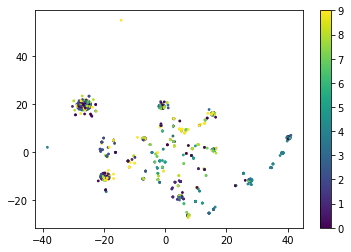

In [37]:
from sklearn.manifold import TSNE
dr=TSNE()
embed_attentions=dr.fit_transform(attentions)

%matplotlib inline
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_attentions[:,0], embed_attentions[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## Dense model

In [19]:
n_feat = train_data.shape[1]
n_attention = 10 #Reduced from 20 to 10. 10 works better
n_attention_hidden=40
n_attention_out=1
n_concat_hidden=128
n_hidden1 =64
n_hidden2 = 64
momentum=0.8
# learning_rate=0.01
learning_rate=0.001

n_batch=8

label="SynthData"

save_folder=os.path.join(time.strftime("%y%m%d_TrainingDense",
                                       time.localtime()))
checkpoint_path = os.path.join(save_folder, 
                               "Dense_{}".format(label),
                               )

try: 
    os.mkdir(save_folder) 
except OSError as error: 
    print(error) 
    
try:
    os.mkdir(checkpoint_path)
except OSError as error:
    print(error)

from tensorflow.keras.initializers import VarianceScaling
concat_activation="selu"
attention_hidden_activation="selu"
attention_output_activation="sigmoid"
kernel_initializer=VarianceScaling()
hidden_activation="selu"

[WinError 183] Cannot create a file when that file already exists: '210222_TrainingDense'
[WinError 183] Cannot create a file when that file already exists: '210222_TrainingDense\\Dense_SynthData'


In [20]:
from algorithms import attention_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.losses import BinaryCrossentropy

np.random.seed(0)

input_layer=Input(shape=(n_feat, ))

dense_layer0=Dense(n_attention_hidden*n_attention,
                   activation="sigmoid", 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(input_layer)
# attentions_layer=attention_model.ConcatAttentions(
#     n_attention=n_attention,
#     n_attention_hidden=n_attention_hidden,
#     n_attention_out=n_attention_out,
#     n_feat=n_feat,
#     n_hidden=n_concat_hidden,
#     activation=concat_activation, 
#     kernel_initializer=kernel_initializer,
#     kernel_regularizer=l2(1E-5),
#     bias_regularizer=l2(1E-5),
#     attention_initializer=kernel_initializer,
#     attention_hidden_activation=attention_hidden_activation,
#     attention_output_activation=attention_output_activation,
#     batch_norm_kwargs={"trainable":False, "renorm":False},
# )(input_layer)
##Removed dropout for attentions_layer because of Batch normalization
# dropout0=Dropout(0.1)(attentions_layer)
dense_layer1=Dense(n_hidden1, 
                   activation=hidden_activation, 
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5),
                  )(dense_layer0)
# dropout1=Dropout(0.1)(dense_layer1)
dense_layer2=Dense(n_hidden2,
                   activation=hidden_activation,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2(1E-5),
                   bias_regularizer=l2(1E-5)
                  )(dense_layer1)
# dropout2=Dropout(0.1)(dense_layer2)
output_layer=Dense(1, activation="sigmoid")(dense_layer2)

dense_model=Model(inputs=input_layer, 
                  outputs=output_layer
                 )

weights_dicts=get_weights_dicts(np.expand_dims(train_targets,1))
loss_fn=BinaryCrossEntropyIgnoreNaN(weights_dicts=weights_dicts)

# loss_fn=tf.nn.sigmoid_cross_entropy_with_logits

dense_model.compile(loss=loss_fn,
    #loss=BinaryCrossentropy(from_logits=False, 
#                                             reduction=tf.keras.losses.Reduction.AUTO,
#                                            ), 
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy','AUC']
             )

In [27]:
dense_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                25664     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 34,289
Trainable params: 34,289
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 mode='max',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

csv_filename = os.path.join(checkpoint_path,
                            "training_log.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

n_epoch=2000


dense_model.fit(train_data, 
                train_targets, 
                epochs=n_epoch,
                batch_size=n_batch,
                validation_data=(test_data, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Epoch 1/2000
113/113 - 2s - loss: 0.7573 - accuracy: 0.5500 - auc: 0.5663 - val_loss: 0.6715 - val_accuracy: 0.5800 - val_auc: 0.6409

Epoch 00001: val_auc improved from -inf to 0.64085, saving model to 210222_TrainingDense\Dense_SynthData
Epoch 2/2000
113/113 - 1s - loss: 0.6989 - accuracy: 0.5667 - auc: 0.5780 - val_loss: 0.6599 - val_accuracy: 0.6300 - val_auc: 0.6562

Epoch 00002: val_auc improved from 0.64085 to 0.65619, saving model to 210222_TrainingDense\Dense_SynthData
Epoch 3/2000
113/113 - 1s - loss: 0.7105 - accuracy: 0.5578 - auc: 0.5736 - val_loss: 0.6545 - val_accuracy: 0.6400 - val_auc: 0.6869

Epoch 00003: val_auc improved from 0.65619 to 0.68685, saving model to 210222_TrainingDense\Dense_SynthData
Epoch 4/2000
113/113 - 1s - loss: 0.7018 - accuracy: 0.5167 - auc: 0.5582 - val_loss: 0.6905 - val_accuracy: 0.7700 - val_auc: 0.6663

Epoch 00004: val_auc did not improve from 0.68685
Epoch 5/2000
113/113 - 1s - loss: 0.7025 - accuracy: 0.5356 - auc: 0.5763 - val_loss: 0.7

113/113 - 1s - loss: 0.5656 - accuracy: 0.6967 - auc: 0.7777 - val_loss: 0.6701 - val_accuracy: 0.6500 - val_auc: 0.7027

Epoch 00043: val_auc did not improve from 0.73129
Epoch 44/2000
113/113 - 1s - loss: 0.5517 - accuracy: 0.7033 - auc: 0.7935 - val_loss: 0.6760 - val_accuracy: 0.6800 - val_auc: 0.7027

Epoch 00044: val_auc did not improve from 0.73129
Epoch 45/2000
113/113 - 1s - loss: 0.5398 - accuracy: 0.7122 - auc: 0.8069 - val_loss: 0.8058 - val_accuracy: 0.5800 - val_auc: 0.6533

Epoch 00045: val_auc did not improve from 0.73129
Epoch 46/2000
113/113 - 1s - loss: 0.5401 - accuracy: 0.7200 - auc: 0.8047 - val_loss: 0.7706 - val_accuracy: 0.6500 - val_auc: 0.6440

Epoch 00046: val_auc did not improve from 0.73129
Epoch 47/2000
113/113 - 1s - loss: 0.5369 - accuracy: 0.7200 - auc: 0.8059 - val_loss: 0.7611 - val_accuracy: 0.5700 - val_auc: 0.6575

Epoch 00047: val_auc did not improve from 0.73129
Epoch 48/2000
113/113 - 1s - loss: 0.5280 - accuracy: 0.7144 - auc: 0.8162 - val_los


Epoch 00087: val_auc did not improve from 0.73129
Epoch 88/2000
113/113 - 1s - loss: 0.2164 - accuracy: 0.9178 - auc: 0.9763 - val_loss: 1.1923 - val_accuracy: 0.7100 - val_auc: 0.6936

Epoch 00088: val_auc did not improve from 0.73129
Epoch 89/2000
113/113 - 1s - loss: 0.2201 - accuracy: 0.9122 - auc: 0.9760 - val_loss: 1.1362 - val_accuracy: 0.6600 - val_auc: 0.6863

Epoch 00089: val_auc did not improve from 0.73129
Epoch 90/2000
113/113 - 1s - loss: 0.1873 - accuracy: 0.9289 - auc: 0.9851 - val_loss: 1.2514 - val_accuracy: 0.7000 - val_auc: 0.7087

Epoch 00090: val_auc did not improve from 0.73129
Epoch 91/2000
113/113 - 1s - loss: 0.1746 - accuracy: 0.9411 - auc: 0.9866 - val_loss: 1.3302 - val_accuracy: 0.7000 - val_auc: 0.6967

Epoch 00091: val_auc did not improve from 0.73129
Epoch 92/2000
113/113 - 1s - loss: 0.1733 - accuracy: 0.9444 - auc: 0.9866 - val_loss: 1.3388 - val_accuracy: 0.7200 - val_auc: 0.7063

Epoch 00092: val_auc did not improve from 0.73129
Epoch 93/2000
113/1

113/113 - 1s - loss: 0.0339 - accuracy: 0.9989 - auc: 1.0000 - val_loss: 2.1767 - val_accuracy: 0.7400 - val_auc: 0.6889

Epoch 00131: val_auc did not improve from 0.75052
Epoch 132/2000
113/113 - 1s - loss: 0.0331 - accuracy: 0.9989 - auc: 1.0000 - val_loss: 2.1928 - val_accuracy: 0.7300 - val_auc: 0.7004

Epoch 00132: val_auc did not improve from 0.75052
Epoch 133/2000
113/113 - 1s - loss: 0.0489 - accuracy: 0.9922 - auc: 0.9988 - val_loss: 2.0580 - val_accuracy: 0.7600 - val_auc: 0.7014

Epoch 00133: val_auc did not improve from 0.75052
Epoch 134/2000
113/113 - 1s - loss: 0.0311 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.1748 - val_accuracy: 0.7200 - val_auc: 0.6900

Epoch 00134: val_auc did not improve from 0.75052
Epoch 135/2000
113/113 - 1s - loss: 0.0302 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.2868 - val_accuracy: 0.7400 - val_auc: 0.6856

Epoch 00135: val_auc did not improve from 0.75052
Epoch 136/2000
113/113 - 1s - loss: 0.0292 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0230 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.5004 - val_accuracy: 0.7300 - val_auc: 0.6920

Epoch 00175: val_auc did not improve from 0.75052
Epoch 176/2000
113/113 - 1s - loss: 0.0231 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.4550 - val_accuracy: 0.7100 - val_auc: 0.6918

Epoch 00176: val_auc did not improve from 0.75052
Epoch 177/2000
113/113 - 1s - loss: 0.0226 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.5406 - val_accuracy: 0.7200 - val_auc: 0.6892

Epoch 00177: val_auc did not improve from 0.75052
Epoch 178/2000
113/113 - 1s - loss: 0.0223 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.5470 - val_accuracy: 0.7100 - val_auc: 0.6894

Epoch 00178: val_auc did not improve from 0.75052
Epoch 179/2000
113/113 - 1s - loss: 0.0447 - accuracy: 0.9956 - auc: 0.9975 - val_loss: 2.1869 - val_accuracy: 0.6700 - val_auc: 0.7152

Epoch 00179: val_auc did not improve from 0.75052
Epoch 180/2000
113/113 - 1s - loss: 0.6987 - accuracy: 0.8422 - auc: 0.9047 - va

113/113 - 1s - loss: 0.0215 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8001 - val_accuracy: 0.7500 - val_auc: 0.6884

Epoch 00219: val_auc did not improve from 0.75052
Epoch 220/2000
113/113 - 1s - loss: 0.0214 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7504 - val_accuracy: 0.7300 - val_auc: 0.6913

Epoch 00220: val_auc did not improve from 0.75052
Epoch 221/2000
113/113 - 1s - loss: 0.0308 - accuracy: 0.9944 - auc: 0.9999 - val_loss: 3.4743 - val_accuracy: 0.7400 - val_auc: 0.6307

Epoch 00221: val_auc did not improve from 0.75052
Epoch 222/2000
113/113 - 1s - loss: 0.7929 - accuracy: 0.8144 - auc: 0.8803 - val_loss: 2.1663 - val_accuracy: 0.6900 - val_auc: 0.6998

Epoch 00222: val_auc did not improve from 0.75052
Epoch 223/2000
113/113 - 1s - loss: 0.3422 - accuracy: 0.8800 - auc: 0.9568 - val_loss: 2.2236 - val_accuracy: 0.7500 - val_auc: 0.6928

Epoch 00223: val_auc did not improve from 0.75052
Epoch 224/2000
113/113 - 1s - loss: 0.0945 - accuracy: 0.9756 - auc: 0.9964 - va

113/113 - 1s - loss: 0.0207 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.6814 - val_accuracy: 0.7400 - val_auc: 0.7058

Epoch 00263: val_auc did not improve from 0.75052
Epoch 264/2000
113/113 - 1s - loss: 0.0208 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7637 - val_accuracy: 0.7500 - val_auc: 0.6949

Epoch 00264: val_auc did not improve from 0.75052
Epoch 265/2000
113/113 - 1s - loss: 0.0206 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7323 - val_accuracy: 0.7100 - val_auc: 0.6952

Epoch 00265: val_auc did not improve from 0.75052
Epoch 266/2000
113/113 - 1s - loss: 0.0207 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7197 - val_accuracy: 0.7300 - val_auc: 0.7027

Epoch 00266: val_auc did not improve from 0.75052
Epoch 267/2000
113/113 - 1s - loss: 0.0205 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9021 - val_accuracy: 0.7200 - val_auc: 0.6538

Epoch 00267: val_auc did not improve from 0.75052
Epoch 268/2000
113/113 - 1s - loss: 0.0203 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0203 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7579 - val_accuracy: 0.7200 - val_auc: 0.6554

Epoch 00307: val_auc did not improve from 0.75052
Epoch 308/2000
113/113 - 1s - loss: 0.0202 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8379 - val_accuracy: 0.7300 - val_auc: 0.6601

Epoch 00308: val_auc did not improve from 0.75052
Epoch 309/2000
113/113 - 1s - loss: 0.0201 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8503 - val_accuracy: 0.7100 - val_auc: 0.6603

Epoch 00309: val_auc did not improve from 0.75052
Epoch 310/2000
113/113 - 1s - loss: 0.0200 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7966 - val_accuracy: 0.7200 - val_auc: 0.6710

Epoch 00310: val_auc did not improve from 0.75052
Epoch 311/2000
113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8608 - val_accuracy: 0.7200 - val_auc: 0.6606

Epoch 00311: val_auc did not improve from 0.75052
Epoch 312/2000
113/113 - 1s - loss: 0.0198 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0206 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8417 - val_accuracy: 0.7600 - val_auc: 0.6661

Epoch 00351: val_auc did not improve from 0.75052
Epoch 352/2000
113/113 - 1s - loss: 0.0204 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7981 - val_accuracy: 0.7300 - val_auc: 0.6606

Epoch 00352: val_auc did not improve from 0.75052
Epoch 353/2000
113/113 - 1s - loss: 0.0203 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8336 - val_accuracy: 0.7400 - val_auc: 0.6648

Epoch 00353: val_auc did not improve from 0.75052
Epoch 354/2000
113/113 - 1s - loss: 0.0202 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9012 - val_accuracy: 0.7400 - val_auc: 0.6739

Epoch 00354: val_auc did not improve from 0.75052
Epoch 355/2000
113/113 - 1s - loss: 0.0201 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8440 - val_accuracy: 0.7400 - val_auc: 0.6635

Epoch 00355: val_auc did not improve from 0.75052
Epoch 356/2000
113/113 - 1s - loss: 0.0200 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0201 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0213 - val_accuracy: 0.7700 - val_auc: 0.6692

Epoch 00395: val_auc did not improve from 0.75052
Epoch 396/2000
113/113 - 1s - loss: 0.0200 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0546 - val_accuracy: 0.7700 - val_auc: 0.6718

Epoch 00396: val_auc did not improve from 0.75052
Epoch 397/2000
113/113 - 1s - loss: 0.0200 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9774 - val_accuracy: 0.7600 - val_auc: 0.6894

Epoch 00397: val_auc did not improve from 0.75052
Epoch 398/2000
113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0850 - val_accuracy: 0.7600 - val_auc: 0.6718

Epoch 00398: val_auc did not improve from 0.75052
Epoch 399/2000
113/113 - 1s - loss: 0.0198 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0684 - val_accuracy: 0.7600 - val_auc: 0.6746

Epoch 00399: val_auc did not improve from 0.75052
Epoch 400/2000
113/113 - 1s - loss: 0.0197 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9653 - val_accuracy: 0.7500 - val_auc: 0.6525

Epoch 00439: val_auc did not improve from 0.75052
Epoch 440/2000
113/113 - 1s - loss: 0.0199 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9936 - val_accuracy: 0.7400 - val_auc: 0.6531

Epoch 00440: val_auc did not improve from 0.75052
Epoch 441/2000
113/113 - 1s - loss: 0.0198 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9650 - val_accuracy: 0.7500 - val_auc: 0.6523

Epoch 00441: val_auc did not improve from 0.75052
Epoch 442/2000
113/113 - 1s - loss: 0.0197 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9576 - val_accuracy: 0.7400 - val_auc: 0.6549

Epoch 00442: val_auc did not improve from 0.75052
Epoch 443/2000
113/113 - 1s - loss: 0.0196 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0058 - val_accuracy: 0.7500 - val_auc: 0.6528

Epoch 00443: val_auc did not improve from 0.75052
Epoch 444/2000
113/113 - 1s - loss: 0.0195 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0196 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0250 - val_accuracy: 0.7400 - val_auc: 0.6637

Epoch 00483: val_auc did not improve from 0.75052
Epoch 484/2000
113/113 - 1s - loss: 0.0195 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0472 - val_accuracy: 0.7400 - val_auc: 0.6632

Epoch 00484: val_auc did not improve from 0.75052
Epoch 485/2000
113/113 - 1s - loss: 0.0195 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0610 - val_accuracy: 0.7400 - val_auc: 0.6642

Epoch 00485: val_auc did not improve from 0.75052
Epoch 486/2000
113/113 - 1s - loss: 0.0194 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0615 - val_accuracy: 0.7400 - val_auc: 0.6637

Epoch 00486: val_auc did not improve from 0.75052
Epoch 487/2000
113/113 - 1s - loss: 0.0193 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0400 - val_accuracy: 0.7300 - val_auc: 0.6611

Epoch 00487: val_auc did not improve from 0.75052
Epoch 488/2000
113/113 - 1s - loss: 0.0193 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.1321 - accuracy: 0.9600 - auc: 0.9914 - val_loss: 2.6643 - val_accuracy: 0.7900 - val_auc: 0.6694

Epoch 00527: val_auc did not improve from 0.75052
Epoch 528/2000
113/113 - 1s - loss: 0.0714 - accuracy: 0.9789 - auc: 0.9975 - val_loss: 2.3626 - val_accuracy: 0.7700 - val_auc: 0.6692

Epoch 00528: val_auc did not improve from 0.75052
Epoch 529/2000
113/113 - 1s - loss: 0.0327 - accuracy: 0.9956 - auc: 1.0000 - val_loss: 2.6761 - val_accuracy: 0.7700 - val_auc: 0.6562

Epoch 00529: val_auc did not improve from 0.75052
Epoch 530/2000
113/113 - 1s - loss: 0.0242 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7148 - val_accuracy: 0.7600 - val_auc: 0.6471

Epoch 00530: val_auc did not improve from 0.75052
Epoch 531/2000
113/113 - 1s - loss: 0.0228 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.7755 - val_accuracy: 0.7500 - val_auc: 0.6492

Epoch 00531: val_auc did not improve from 0.75052
Epoch 532/2000
113/113 - 1s - loss: 0.0217 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1486 - val_accuracy: 0.7400 - val_auc: 0.6619

Epoch 00571: val_auc did not improve from 0.75052
Epoch 572/2000
113/113 - 1s - loss: 0.0168 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1159 - val_accuracy: 0.7300 - val_auc: 0.6463

Epoch 00572: val_auc did not improve from 0.75052
Epoch 573/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0993 - val_accuracy: 0.7300 - val_auc: 0.6473

Epoch 00573: val_auc did not improve from 0.75052
Epoch 574/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1081 - val_accuracy: 0.7300 - val_auc: 0.6484

Epoch 00574: val_auc did not improve from 0.75052
Epoch 575/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1960 - val_accuracy: 0.7200 - val_auc: 0.6440

Epoch 00575: val_auc did not improve from 0.75052
Epoch 576/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0171 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9063 - val_accuracy: 0.7300 - val_auc: 0.6486

Epoch 00615: val_auc did not improve from 0.75052
Epoch 616/2000
113/113 - 1s - loss: 0.0170 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9064 - val_accuracy: 0.7200 - val_auc: 0.6492

Epoch 00616: val_auc did not improve from 0.75052
Epoch 617/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9479 - val_accuracy: 0.7300 - val_auc: 0.6492

Epoch 00617: val_auc did not improve from 0.75052
Epoch 618/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9583 - val_accuracy: 0.7300 - val_auc: 0.6486

Epoch 00618: val_auc did not improve from 0.75052
Epoch 619/2000
113/113 - 1s - loss: 0.0168 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9219 - val_accuracy: 0.7200 - val_auc: 0.6463

Epoch 00619: val_auc did not improve from 0.75052
Epoch 620/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0172 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8551 - val_accuracy: 0.7500 - val_auc: 0.6359

Epoch 00659: val_auc did not improve from 0.75052
Epoch 660/2000
113/113 - 1s - loss: 0.0171 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8531 - val_accuracy: 0.7500 - val_auc: 0.6380

Epoch 00660: val_auc did not improve from 0.75052
Epoch 661/2000
113/113 - 1s - loss: 0.0170 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8542 - val_accuracy: 0.7600 - val_auc: 0.6367

Epoch 00661: val_auc did not improve from 0.75052
Epoch 662/2000
113/113 - 1s - loss: 0.0170 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8375 - val_accuracy: 0.7500 - val_auc: 0.6367

Epoch 00662: val_auc did not improve from 0.75052
Epoch 663/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8750 - val_accuracy: 0.7600 - val_auc: 0.6367

Epoch 00663: val_auc did not improve from 0.75052
Epoch 664/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.0175 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9488 - val_accuracy: 0.7400 - val_auc: 0.6567

Epoch 00703: val_auc did not improve from 0.75052
Epoch 704/2000
113/113 - 1s - loss: 0.0174 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9772 - val_accuracy: 0.7400 - val_auc: 0.6570

Epoch 00704: val_auc did not improve from 0.75052
Epoch 705/2000
113/113 - 1s - loss: 0.0173 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9869 - val_accuracy: 0.7400 - val_auc: 0.6572

Epoch 00705: val_auc did not improve from 0.75052
Epoch 706/2000
113/113 - 1s - loss: 0.0172 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9873 - val_accuracy: 0.7400 - val_auc: 0.6572

Epoch 00706: val_auc did not improve from 0.75052
Epoch 707/2000
113/113 - 1s - loss: 0.0171 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9861 - val_accuracy: 0.7400 - val_auc: 0.6567

Epoch 00707: val_auc did not improve from 0.75052
Epoch 708/2000
113/113 - 1s - loss: 0.0171 - accuracy: 1.0000 - auc: 1.0000 - va

113/113 - 1s - loss: 0.2304 - accuracy: 0.9044 - auc: 0.9708 - val_loss: 1.9678 - val_accuracy: 0.7300 - val_auc: 0.6463

Epoch 00747: val_auc did not improve from 0.75052
Epoch 748/2000
113/113 - 1s - loss: 0.1634 - accuracy: 0.9378 - auc: 0.9859 - val_loss: 1.9714 - val_accuracy: 0.7500 - val_auc: 0.6377

Epoch 00748: val_auc did not improve from 0.75052
Epoch 749/2000
113/113 - 1s - loss: 0.1067 - accuracy: 0.9667 - auc: 0.9950 - val_loss: 1.8944 - val_accuracy: 0.7600 - val_auc: 0.6804

Epoch 00749: val_auc did not improve from 0.75052
Epoch 750/2000
113/113 - 1s - loss: 0.0966 - accuracy: 0.9733 - auc: 0.9957 - val_loss: 1.9840 - val_accuracy: 0.7500 - val_auc: 0.6684

Epoch 00750: val_auc did not improve from 0.75052
Epoch 751/2000
113/113 - 1s - loss: 0.0629 - accuracy: 0.9867 - auc: 0.9991 - val_loss: 2.1730 - val_accuracy: 0.7400 - val_auc: 0.6445

Epoch 00751: val_auc did not improve from 0.75052
Epoch 752/2000
113/113 - 1s - loss: 0.0535 - accuracy: 0.9878 - auc: 0.9997 - va

113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0601 - val_accuracy: 0.7300 - val_auc: 0.6991

Epoch 00791: val_auc did not improve from 0.75052
Epoch 792/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1654 - val_accuracy: 0.7500 - val_auc: 0.6817

Epoch 00792: val_auc did not improve from 0.75052
Epoch 793/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1240 - val_accuracy: 0.7400 - val_auc: 0.6876

Epoch 00793: val_auc did not improve from 0.75052
Epoch 794/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0788 - val_accuracy: 0.7500 - val_auc: 0.6881

Epoch 00794: val_auc did not improve from 0.75052
Epoch 795/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1372 - val_accuracy: 0.7400 - val_auc: 0.6993

Epoch 00795: val_auc did not improve from 0.75052
Epoch 796/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - auc: 1.0000 - va


Epoch 00834: val_auc did not improve from 0.77833
Epoch 835/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8894 - val_accuracy: 0.7600 - val_auc: 0.6907

Epoch 00835: val_auc did not improve from 0.77833
Epoch 836/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8943 - val_accuracy: 0.7600 - val_auc: 0.6837

Epoch 00836: val_auc did not improve from 0.77833
Epoch 837/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9529 - val_accuracy: 0.7600 - val_auc: 0.6897

Epoch 00837: val_auc did not improve from 0.77833
Epoch 838/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9272 - val_accuracy: 0.7600 - val_auc: 0.6967

Epoch 00838: val_auc did not improve from 0.77833
Epoch 839/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8611 - val_accuracy: 0.7600 - val_auc: 0.6897

Epoch 00839: val_auc did not improve from 0.77833
Epoch 840/2000


Epoch 00878: val_auc did not improve from 0.77833
Epoch 879/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1428 - val_accuracy: 0.7300 - val_auc: 0.6655

Epoch 00879: val_auc did not improve from 0.77833
Epoch 880/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1844 - val_accuracy: 0.7300 - val_auc: 0.6523

Epoch 00880: val_auc did not improve from 0.77833
Epoch 881/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2108 - val_accuracy: 0.7300 - val_auc: 0.6536

Epoch 00881: val_auc did not improve from 0.77833
Epoch 882/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1993 - val_accuracy: 0.7400 - val_auc: 0.6507

Epoch 00882: val_auc did not improve from 0.77833
Epoch 883/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2052 - val_accuracy: 0.7500 - val_auc: 0.6538

Epoch 00883: val_auc did not improve from 0.77833
Epoch 884/2000


Epoch 00922: val_auc did not improve from 0.77833
Epoch 923/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9119 - val_accuracy: 0.7800 - val_auc: 0.6959

Epoch 00923: val_auc did not improve from 0.77833
Epoch 924/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9626 - val_accuracy: 0.8000 - val_auc: 0.6957

Epoch 00924: val_auc did not improve from 0.77833
Epoch 925/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9589 - val_accuracy: 0.7900 - val_auc: 0.6975

Epoch 00925: val_auc did not improve from 0.77833
Epoch 926/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9405 - val_accuracy: 0.7900 - val_auc: 0.6933

Epoch 00926: val_auc did not improve from 0.77833
Epoch 927/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9933 - val_accuracy: 0.8000 - val_auc: 0.6920

Epoch 00927: val_auc did not improve from 0.77833
Epoch 928/2000


Epoch 00966: val_auc did not improve from 0.77833
Epoch 967/2000
113/113 - 1s - loss: 0.0185 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9188 - val_accuracy: 0.7700 - val_auc: 0.6765

Epoch 00967: val_auc did not improve from 0.77833
Epoch 968/2000
113/113 - 1s - loss: 0.0181 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9111 - val_accuracy: 0.7700 - val_auc: 0.6785

Epoch 00968: val_auc did not improve from 0.77833
Epoch 969/2000
113/113 - 1s - loss: 0.0178 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8882 - val_accuracy: 0.7700 - val_auc: 0.6757

Epoch 00969: val_auc did not improve from 0.77833
Epoch 970/2000
113/113 - 1s - loss: 0.0176 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9577 - val_accuracy: 0.7700 - val_auc: 0.6819

Epoch 00970: val_auc did not improve from 0.77833
Epoch 971/2000
113/113 - 1s - loss: 0.0174 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9593 - val_accuracy: 0.7600 - val_auc: 0.6811

Epoch 00971: val_auc did not improve from 0.77833
Epoch 972/2000


Epoch 01010: val_auc did not improve from 0.77833
Epoch 1011/2000
113/113 - 1s - loss: 0.1699 - accuracy: 0.9411 - auc: 0.9837 - val_loss: 2.2272 - val_accuracy: 0.7100 - val_auc: 0.6733

Epoch 01011: val_auc did not improve from 0.77833
Epoch 1012/2000
113/113 - 1s - loss: 0.0614 - accuracy: 0.9856 - auc: 0.9989 - val_loss: 2.3988 - val_accuracy: 0.7400 - val_auc: 0.6824

Epoch 01012: val_auc did not improve from 0.77833
Epoch 1013/2000
113/113 - 1s - loss: 0.0353 - accuracy: 0.9967 - auc: 0.9999 - val_loss: 2.5207 - val_accuracy: 0.7300 - val_auc: 0.6835

Epoch 01013: val_auc did not improve from 0.77833
Epoch 1014/2000
113/113 - 1s - loss: 0.0309 - accuracy: 0.9967 - auc: 1.0000 - val_loss: 2.6996 - val_accuracy: 0.7500 - val_auc: 0.6965

Epoch 01014: val_auc did not improve from 0.77833
Epoch 1015/2000
113/113 - 1s - loss: 0.0238 - accuracy: 0.9989 - auc: 1.0000 - val_loss: 2.7645 - val_accuracy: 0.7400 - val_auc: 0.6967

Epoch 01015: val_auc did not improve from 0.77833
Epoch 101


Epoch 01054: val_auc did not improve from 0.77833
Epoch 1055/2000
113/113 - 1s - loss: 0.0458 - accuracy: 0.9933 - auc: 0.9969 - val_loss: 3.6121 - val_accuracy: 0.6900 - val_auc: 0.6305

Epoch 01055: val_auc did not improve from 0.77833
Epoch 1056/2000
113/113 - 1s - loss: 1.0118 - accuracy: 0.7800 - auc: 0.8542 - val_loss: 2.0548 - val_accuracy: 0.6700 - val_auc: 0.6933

Epoch 01056: val_auc did not improve from 0.77833
Epoch 1057/2000
113/113 - 1s - loss: 0.2600 - accuracy: 0.9233 - auc: 0.9719 - val_loss: 2.3217 - val_accuracy: 0.7000 - val_auc: 0.6744

Epoch 01057: val_auc did not improve from 0.77833
Epoch 1058/2000
113/113 - 1s - loss: 0.1736 - accuracy: 0.9489 - auc: 0.9832 - val_loss: 2.7102 - val_accuracy: 0.6600 - val_auc: 0.6263

Epoch 01058: val_auc did not improve from 0.77833
Epoch 1059/2000
113/113 - 1s - loss: 0.0706 - accuracy: 0.9756 - auc: 0.9973 - val_loss: 2.8895 - val_accuracy: 0.7700 - val_auc: 0.6907

Epoch 01059: val_auc did not improve from 0.77833
Epoch 106


Epoch 01098: val_auc did not improve from 0.77833
Epoch 1099/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0885 - val_accuracy: 0.7400 - val_auc: 0.6967

Epoch 01099: val_auc did not improve from 0.77833
Epoch 1100/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1004 - val_accuracy: 0.7600 - val_auc: 0.7019

Epoch 01100: val_auc did not improve from 0.77833
Epoch 1101/2000
113/113 - 1s - loss: 0.0149 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0578 - val_accuracy: 0.7600 - val_auc: 0.6970

Epoch 01101: val_auc did not improve from 0.77833
Epoch 1102/2000
113/113 - 1s - loss: 0.0148 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1342 - val_accuracy: 0.7600 - val_auc: 0.6993

Epoch 01102: val_auc did not improve from 0.77833
Epoch 1103/2000
113/113 - 1s - loss: 0.0148 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1117 - val_accuracy: 0.7500 - val_auc: 0.6991

Epoch 01103: val_auc did not improve from 0.77833
Epoch 110


Epoch 01142: val_auc did not improve from 0.77833
Epoch 1143/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2996 - val_accuracy: 0.7300 - val_auc: 0.6744

Epoch 01143: val_auc did not improve from 0.77833
Epoch 1144/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.3016 - val_accuracy: 0.7400 - val_auc: 0.6775

Epoch 01144: val_auc did not improve from 0.77833
Epoch 1145/2000
113/113 - 1s - loss: 0.0153 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2658 - val_accuracy: 0.7400 - val_auc: 0.6757

Epoch 01145: val_auc did not improve from 0.77833
Epoch 1146/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2919 - val_accuracy: 0.7400 - val_auc: 0.6720

Epoch 01146: val_auc did not improve from 0.77833
Epoch 1147/2000
113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2838 - val_accuracy: 0.7400 - val_auc: 0.6762

Epoch 01147: val_auc did not improve from 0.77833
Epoch 114


Epoch 01186: val_auc did not improve from 0.77833
Epoch 1187/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2905 - val_accuracy: 0.7600 - val_auc: 0.6593

Epoch 01187: val_auc did not improve from 0.77833
Epoch 1188/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2739 - val_accuracy: 0.7500 - val_auc: 0.6590

Epoch 01188: val_auc did not improve from 0.77833
Epoch 1189/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.3122 - val_accuracy: 0.7600 - val_auc: 0.6601

Epoch 01189: val_auc did not improve from 0.77833
Epoch 1190/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.3050 - val_accuracy: 0.7300 - val_auc: 0.6598

Epoch 01190: val_auc did not improve from 0.77833
Epoch 1191/2000
113/113 - 1s - loss: 0.0154 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2599 - val_accuracy: 0.7400 - val_auc: 0.6593

Epoch 01191: val_auc did not improve from 0.77833
Epoch 119


Epoch 01230: val_auc did not improve from 0.77833
Epoch 1231/2000
113/113 - 1s - loss: 0.0158 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2859 - val_accuracy: 0.7300 - val_auc: 0.6538

Epoch 01231: val_auc did not improve from 0.77833
Epoch 1232/2000
113/113 - 1s - loss: 0.0157 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.3335 - val_accuracy: 0.7400 - val_auc: 0.6533

Epoch 01232: val_auc did not improve from 0.77833
Epoch 1233/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2900 - val_accuracy: 0.7300 - val_auc: 0.6525

Epoch 01233: val_auc did not improve from 0.77833
Epoch 1234/2000
113/113 - 1s - loss: 0.0156 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.3249 - val_accuracy: 0.7300 - val_auc: 0.6572

Epoch 01234: val_auc did not improve from 0.77833
Epoch 1235/2000
113/113 - 1s - loss: 0.0155 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.3027 - val_accuracy: 0.7200 - val_auc: 0.6559

Epoch 01235: val_auc did not improve from 0.77833
Epoch 123


Epoch 01274: val_auc did not improve from 0.77833
Epoch 1275/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9974 - val_accuracy: 0.7300 - val_auc: 0.6918

Epoch 01275: val_auc did not improve from 0.77833
Epoch 1276/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9990 - val_accuracy: 0.7300 - val_auc: 0.6892

Epoch 01276: val_auc did not improve from 0.77833
Epoch 1277/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9707 - val_accuracy: 0.7300 - val_auc: 0.6892

Epoch 01277: val_auc did not improve from 0.77833
Epoch 1278/2000
113/113 - 1s - loss: 0.0161 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0023 - val_accuracy: 0.7300 - val_auc: 0.6871

Epoch 01278: val_auc did not improve from 0.77833
Epoch 1279/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0654 - val_accuracy: 0.7300 - val_auc: 0.6894

Epoch 01279: val_auc did not improve from 0.77833
Epoch 128


Epoch 01318: val_auc did not improve from 0.77833
Epoch 1319/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0994 - val_accuracy: 0.7300 - val_auc: 0.6481

Epoch 01319: val_auc did not improve from 0.77833
Epoch 1320/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1135 - val_accuracy: 0.7300 - val_auc: 0.6468

Epoch 01320: val_auc did not improve from 0.77833
Epoch 1321/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1213 - val_accuracy: 0.7300 - val_auc: 0.6331

Epoch 01321: val_auc did not improve from 0.77833
Epoch 1322/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1126 - val_accuracy: 0.7300 - val_auc: 0.6473

Epoch 01322: val_auc did not improve from 0.77833
Epoch 1323/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1573 - val_accuracy: 0.7400 - val_auc: 0.6320

Epoch 01323: val_auc did not improve from 0.77833
Epoch 132


Epoch 01362: val_auc did not improve from 0.77833
Epoch 1363/2000
113/113 - 1s - loss: 0.3133 - accuracy: 0.8922 - auc: 0.9553 - val_loss: 2.3616 - val_accuracy: 0.6100 - val_auc: 0.6653

Epoch 01363: val_auc did not improve from 0.77833
Epoch 1364/2000
113/113 - 1s - loss: 0.1653 - accuracy: 0.9411 - auc: 0.9856 - val_loss: 2.2856 - val_accuracy: 0.7200 - val_auc: 0.6856

Epoch 01364: val_auc did not improve from 0.77833
Epoch 1365/2000
113/113 - 1s - loss: 0.0800 - accuracy: 0.9722 - auc: 0.9978 - val_loss: 2.5540 - val_accuracy: 0.7100 - val_auc: 0.6671

Epoch 01365: val_auc did not improve from 0.77833
Epoch 1366/2000
113/113 - 1s - loss: 0.0418 - accuracy: 0.9933 - auc: 0.9999 - val_loss: 2.6417 - val_accuracy: 0.7200 - val_auc: 0.6879

Epoch 01366: val_auc did not improve from 0.77833
Epoch 1367/2000
113/113 - 1s - loss: 0.0382 - accuracy: 0.9922 - auc: 0.9998 - val_loss: 2.7674 - val_accuracy: 0.7500 - val_auc: 0.6804

Epoch 01367: val_auc did not improve from 0.77833
Epoch 136


Epoch 01406: val_auc did not improve from 0.77833
Epoch 1407/2000
113/113 - 1s - loss: 0.0144 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1319 - val_accuracy: 0.7500 - val_auc: 0.6957

Epoch 01407: val_auc did not improve from 0.77833
Epoch 1408/2000
113/113 - 1s - loss: 0.0144 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1854 - val_accuracy: 0.7600 - val_auc: 0.6889

Epoch 01408: val_auc did not improve from 0.77833
Epoch 1409/2000
113/113 - 1s - loss: 0.0143 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1860 - val_accuracy: 0.7600 - val_auc: 0.6866

Epoch 01409: val_auc did not improve from 0.77833
Epoch 1410/2000
113/113 - 1s - loss: 0.0142 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1759 - val_accuracy: 0.7600 - val_auc: 0.6824

Epoch 01410: val_auc did not improve from 0.77833
Epoch 1411/2000
113/113 - 1s - loss: 0.0142 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1812 - val_accuracy: 0.7500 - val_auc: 0.6770

Epoch 01411: val_auc did not improve from 0.77833
Epoch 141


Epoch 01450: val_auc did not improve from 0.77833
Epoch 1451/2000
113/113 - 1s - loss: 0.0168 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9336 - val_accuracy: 0.7500 - val_auc: 0.6798

Epoch 01451: val_auc did not improve from 0.77833
Epoch 1452/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9391 - val_accuracy: 0.7500 - val_auc: 0.6944

Epoch 01452: val_auc did not improve from 0.77833
Epoch 1453/2000
113/113 - 1s - loss: 0.0166 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9304 - val_accuracy: 0.7600 - val_auc: 0.6946

Epoch 01453: val_auc did not improve from 0.77833
Epoch 1454/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9769 - val_accuracy: 0.7500 - val_auc: 0.6827

Epoch 01454: val_auc did not improve from 0.77833
Epoch 1455/2000
113/113 - 1s - loss: 0.0164 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9559 - val_accuracy: 0.7500 - val_auc: 0.6959

Epoch 01455: val_auc did not improve from 0.77833
Epoch 145


Epoch 01494: val_auc did not improve from 0.77833
Epoch 1495/2000
113/113 - 1s - loss: 0.6592 - accuracy: 0.8522 - auc: 0.9167 - val_loss: 1.8142 - val_accuracy: 0.7100 - val_auc: 0.6752

Epoch 01495: val_auc did not improve from 0.77833
Epoch 1496/2000
113/113 - 1s - loss: 0.5358 - accuracy: 0.8311 - auc: 0.9021 - val_loss: 2.3409 - val_accuracy: 0.7300 - val_auc: 0.6845

Epoch 01496: val_auc did not improve from 0.77833
Epoch 1497/2000
113/113 - 1s - loss: 0.2370 - accuracy: 0.9211 - auc: 0.9720 - val_loss: 1.9128 - val_accuracy: 0.7600 - val_auc: 0.7134

Epoch 01497: val_auc did not improve from 0.77833
Epoch 1498/2000
113/113 - 1s - loss: 0.0977 - accuracy: 0.9711 - auc: 0.9961 - val_loss: 2.2964 - val_accuracy: 0.7300 - val_auc: 0.7069

Epoch 01498: val_auc did not improve from 0.77833
Epoch 1499/2000
113/113 - 1s - loss: 0.0559 - accuracy: 0.9889 - auc: 0.9990 - val_loss: 2.1080 - val_accuracy: 0.7200 - val_auc: 0.7313

Epoch 01499: val_auc did not improve from 0.77833
Epoch 150


Epoch 01538: val_auc did not improve from 0.77833
Epoch 1539/2000
113/113 - 1s - loss: 0.0145 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2011 - val_accuracy: 0.7300 - val_auc: 0.6518

Epoch 01539: val_auc did not improve from 0.77833
Epoch 1540/2000
113/113 - 1s - loss: 0.0145 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1723 - val_accuracy: 0.7100 - val_auc: 0.6471

Epoch 01540: val_auc did not improve from 0.77833
Epoch 1541/2000
113/113 - 1s - loss: 0.0144 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1482 - val_accuracy: 0.7300 - val_auc: 0.6473

Epoch 01541: val_auc did not improve from 0.77833
Epoch 1542/2000
113/113 - 1s - loss: 0.0143 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0724 - val_accuracy: 0.7400 - val_auc: 0.6494

Epoch 01542: val_auc did not improve from 0.77833
Epoch 1543/2000
113/113 - 1s - loss: 0.0142 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1601 - val_accuracy: 0.7300 - val_auc: 0.6473

Epoch 01543: val_auc did not improve from 0.77833
Epoch 154


Epoch 01582: val_auc did not improve from 0.77833
Epoch 1583/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9734 - val_accuracy: 0.7600 - val_auc: 0.6666

Epoch 01583: val_auc did not improve from 0.77833
Epoch 1584/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9686 - val_accuracy: 0.7500 - val_auc: 0.6684

Epoch 01584: val_auc did not improve from 0.77833
Epoch 1585/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9562 - val_accuracy: 0.7500 - val_auc: 0.6694

Epoch 01585: val_auc did not improve from 0.77833
Epoch 1586/2000
113/113 - 1s - loss: 0.0149 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9689 - val_accuracy: 0.7600 - val_auc: 0.6603

Epoch 01586: val_auc did not improve from 0.77833
Epoch 1587/2000
113/113 - 1s - loss: 0.0148 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9609 - val_accuracy: 0.7600 - val_auc: 0.6728

Epoch 01587: val_auc did not improve from 0.77833
Epoch 158

113/113 - 1s - loss: 0.0152 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9205 - val_accuracy: 0.7300 - val_auc: 0.6616

Epoch 01626: val_auc did not improve from 0.80509
Epoch 1627/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8834 - val_accuracy: 0.7300 - val_auc: 0.6596

Epoch 01627: val_auc did not improve from 0.80509
Epoch 1628/2000
113/113 - 1s - loss: 0.0151 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9846 - val_accuracy: 0.7400 - val_auc: 0.6710

Epoch 01628: val_auc did not improve from 0.80509
Epoch 1629/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9716 - val_accuracy: 0.7400 - val_auc: 0.6710

Epoch 01629: val_auc did not improve from 0.80509
Epoch 1630/2000
113/113 - 1s - loss: 0.0150 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9737 - val_accuracy: 0.7300 - val_auc: 0.6650

Epoch 01630: val_auc did not improve from 0.80509
Epoch 1631/2000
113/113 - 1s - loss: 0.0149 - accuracy: 1.0000 - auc: 1.0000


Epoch 01669: val_auc did not improve from 0.80509
Epoch 1670/2000
113/113 - 1s - loss: 0.0186 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8473 - val_accuracy: 0.7300 - val_auc: 0.6739

Epoch 01670: val_auc did not improve from 0.80509
Epoch 1671/2000
113/113 - 1s - loss: 0.0174 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.8845 - val_accuracy: 0.7300 - val_auc: 0.6801

Epoch 01671: val_auc did not improve from 0.80509
Epoch 1672/2000
113/113 - 1s - loss: 0.0167 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9509 - val_accuracy: 0.7300 - val_auc: 0.6692

Epoch 01672: val_auc did not improve from 0.80509
Epoch 1673/2000
113/113 - 1s - loss: 0.0163 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9364 - val_accuracy: 0.7300 - val_auc: 0.6668

Epoch 01673: val_auc did not improve from 0.80509
Epoch 1674/2000
113/113 - 1s - loss: 0.0160 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9930 - val_accuracy: 0.7300 - val_auc: 0.6702

Epoch 01674: val_auc did not improve from 0.80509
Epoch 167


Epoch 01713: val_auc did not improve from 0.80509
Epoch 1714/2000
113/113 - 1s - loss: 0.0134 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2313 - val_accuracy: 0.7400 - val_auc: 0.6681

Epoch 01714: val_auc did not improve from 0.80509
Epoch 1715/2000
113/113 - 1s - loss: 0.0134 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1664 - val_accuracy: 0.7400 - val_auc: 0.6840

Epoch 01715: val_auc did not improve from 0.80509
Epoch 1716/2000
113/113 - 1s - loss: 0.0133 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1275 - val_accuracy: 0.7400 - val_auc: 0.6551

Epoch 01716: val_auc did not improve from 0.80509
Epoch 1717/2000
113/113 - 1s - loss: 0.0133 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2119 - val_accuracy: 0.7400 - val_auc: 0.6767

Epoch 01717: val_auc did not improve from 0.80509
Epoch 1718/2000
113/113 - 1s - loss: 0.0132 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1224 - val_accuracy: 0.7300 - val_auc: 0.6746

Epoch 01718: val_auc did not improve from 0.80509
Epoch 171


Epoch 01757: val_auc did not improve from 0.80509
Epoch 1758/2000
113/113 - 1s - loss: 0.0138 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9664 - val_accuracy: 0.7400 - val_auc: 0.6692

Epoch 01758: val_auc did not improve from 0.80509
Epoch 1759/2000
113/113 - 1s - loss: 0.0138 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9957 - val_accuracy: 0.7400 - val_auc: 0.6728

Epoch 01759: val_auc did not improve from 0.80509
Epoch 1760/2000
113/113 - 1s - loss: 0.0138 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9781 - val_accuracy: 0.7400 - val_auc: 0.6788

Epoch 01760: val_auc did not improve from 0.80509
Epoch 1761/2000
113/113 - 1s - loss: 0.0137 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9699 - val_accuracy: 0.7200 - val_auc: 0.6707

Epoch 01761: val_auc did not improve from 0.80509
Epoch 1762/2000
113/113 - 1s - loss: 0.0137 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0506 - val_accuracy: 0.7500 - val_auc: 0.6778

Epoch 01762: val_auc did not improve from 0.80509
Epoch 176


Epoch 01801: val_auc did not improve from 0.80509
Epoch 1802/2000
113/113 - 1s - loss: 0.0141 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0741 - val_accuracy: 0.7300 - val_auc: 0.6739

Epoch 01802: val_auc did not improve from 0.80509
Epoch 1803/2000
113/113 - 1s - loss: 0.0141 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1160 - val_accuracy: 0.7300 - val_auc: 0.6783

Epoch 01803: val_auc did not improve from 0.80509
Epoch 1804/2000
113/113 - 1s - loss: 0.0141 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0797 - val_accuracy: 0.7300 - val_auc: 0.6749

Epoch 01804: val_auc did not improve from 0.80509
Epoch 1805/2000
113/113 - 1s - loss: 0.0140 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1262 - val_accuracy: 0.7300 - val_auc: 0.6848

Epoch 01805: val_auc did not improve from 0.80509
Epoch 1806/2000
113/113 - 1s - loss: 0.0140 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1158 - val_accuracy: 0.7400 - val_auc: 0.6837

Epoch 01806: val_auc did not improve from 0.80509
Epoch 180


Epoch 01845: val_auc did not improve from 0.80509
Epoch 1846/2000
113/113 - 1s - loss: 0.0149 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0521 - val_accuracy: 0.7500 - val_auc: 0.6663

Epoch 01846: val_auc did not improve from 0.80509
Epoch 1847/2000
113/113 - 1s - loss: 0.0147 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0818 - val_accuracy: 0.7500 - val_auc: 0.6674

Epoch 01847: val_auc did not improve from 0.80509
Epoch 1848/2000
113/113 - 1s - loss: 0.0147 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0737 - val_accuracy: 0.7500 - val_auc: 0.6697

Epoch 01848: val_auc did not improve from 0.80509
Epoch 1849/2000
113/113 - 1s - loss: 0.0146 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0941 - val_accuracy: 0.7500 - val_auc: 0.6661

Epoch 01849: val_auc did not improve from 0.80509
Epoch 1850/2000
113/113 - 1s - loss: 0.0145 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1856 - val_accuracy: 0.7600 - val_auc: 0.6692

Epoch 01850: val_auc did not improve from 0.80509
Epoch 185


Epoch 01889: val_auc did not improve from 0.80509
Epoch 1890/2000
113/113 - 1s - loss: 0.0177 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9373 - val_accuracy: 0.7500 - val_auc: 0.6866

Epoch 01890: val_auc did not improve from 0.80509
Epoch 1891/2000
113/113 - 1s - loss: 0.0169 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9153 - val_accuracy: 0.7500 - val_auc: 0.6856

Epoch 01891: val_auc did not improve from 0.80509
Epoch 1892/2000
113/113 - 1s - loss: 0.0165 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 2.9625 - val_accuracy: 0.7400 - val_auc: 0.6791

Epoch 01892: val_auc did not improve from 0.80509
Epoch 1893/2000
113/113 - 1s - loss: 0.0162 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0098 - val_accuracy: 0.7600 - val_auc: 0.6892

Epoch 01893: val_auc did not improve from 0.80509
Epoch 1894/2000
113/113 - 1s - loss: 0.0159 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0284 - val_accuracy: 0.7600 - val_auc: 0.6830

Epoch 01894: val_auc did not improve from 0.80509
Epoch 189


Epoch 01933: val_auc did not improve from 0.80509
Epoch 1934/2000
113/113 - 1s - loss: 0.0129 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.2650 - val_accuracy: 0.7300 - val_auc: 0.6746

Epoch 01934: val_auc did not improve from 0.80509
Epoch 1935/2000
113/113 - 1s - loss: 0.0129 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1944 - val_accuracy: 0.7300 - val_auc: 0.6676

Epoch 01935: val_auc did not improve from 0.80509
Epoch 1936/2000
113/113 - 1s - loss: 0.3094 - accuracy: 0.9300 - auc: 0.9720 - val_loss: 2.3331 - val_accuracy: 0.6500 - val_auc: 0.6726

Epoch 01936: val_auc did not improve from 0.80509
Epoch 1937/2000
113/113 - 1s - loss: 0.7096 - accuracy: 0.7911 - auc: 0.8801 - val_loss: 2.4420 - val_accuracy: 0.7300 - val_auc: 0.7160

Epoch 01937: val_auc did not improve from 0.80509
Epoch 1938/2000
113/113 - 1s - loss: 0.2367 - accuracy: 0.9256 - auc: 0.9720 - val_loss: 2.3589 - val_accuracy: 0.7400 - val_auc: 0.7053

Epoch 01938: val_auc did not improve from 0.80509
Epoch 193


Epoch 01977: val_auc did not improve from 0.80509
Epoch 1978/2000
113/113 - 1s - loss: 0.0134 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0779 - val_accuracy: 0.7300 - val_auc: 0.6762

Epoch 01978: val_auc did not improve from 0.80509
Epoch 1979/2000
113/113 - 1s - loss: 0.0133 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.0560 - val_accuracy: 0.7300 - val_auc: 0.6767

Epoch 01979: val_auc did not improve from 0.80509
Epoch 1980/2000
113/113 - 1s - loss: 0.0133 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1095 - val_accuracy: 0.7400 - val_auc: 0.6806

Epoch 01980: val_auc did not improve from 0.80509
Epoch 1981/2000
113/113 - 1s - loss: 0.0133 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1027 - val_accuracy: 0.7400 - val_auc: 0.6798

Epoch 01981: val_auc did not improve from 0.80509
Epoch 1982/2000
113/113 - 1s - loss: 0.0132 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 3.1249 - val_accuracy: 0.7400 - val_auc: 0.6827

Epoch 01982: val_auc did not improve from 0.80509
Epoch 198

In [12]:
dense_model.load_weights(os.path.join("210216_TrainingDense",
                                      "Dense_label"
                                     ))

In [14]:
hidden=dense_model.layers[1](train_data).numpy() 

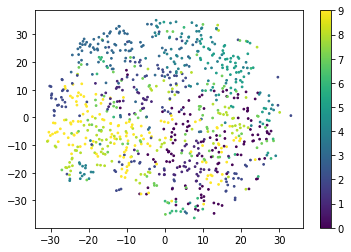

In [17]:
%matplotlib inline

from sklearn.manifold import TSNE
dr=TSNE()
embed_hidden=dr.fit_transform(hidden)
                              
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

scatter=ax.scatter(embed_hidden[:,0], embed_hidden[:,1],
                   c=cluster_labels_train,
                   s=3
                  )

plt.colorbar(scatter)

## Plot

In [22]:
#Data processed in excel by combining training and validation accuracy columns from individual training_log.csv"
import pandas as pd
df=pd.read_csv(os.path.join("SynthData_10dim_clusternoise_unbalanced_results.csv"),
               index_col=False)

In [23]:
df.head()

,Epoch,LLDLwFW_valauc,LLDLwoFW_valauc,DenseModel_valauc,LLDLwFW_valacc,LLDLwoFW_valacc,DenseModel_valacc,LLDLwFW_trainauc,LLDLwoFW_trainauc,DenseModel_trainauc,LLDLwFW_trainacc,LLDLwoFW_trainacc,DenseModel_trainacc
0,0,0.853430,0.436331,0.640852,0.83,0.52,0.58,0.736274,0.518808,0.566268,0.687778,0.527778,0.550000
1,1,0.843555,0.561331,0.656185,0.77,0.67,0.63,0.849413,0.514055,0.577993,0.775556,0.516667,0.566667
2,2,0.863306,0.535083,0.686850,0.77,0.65,0.64,0.860970,0.571409,0.573583,0.773333,0.560000,0.557778
3,3,0.913721,0.606289,0.666320,0.82,0.33,0.77,0.898602,0.523845,0.558189,0.824444,0.526667,0.516667
4,4,0.893971,0.345894,0.695686,0.81,0.48,0.74,0.906574,0.514873,0.576295,0.827778,0.508889,0.535556


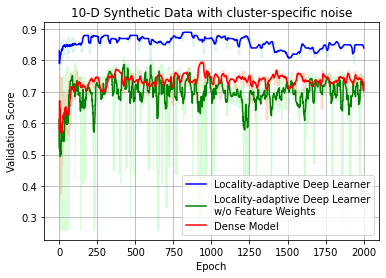

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch']+1)
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, i in enumerate(["LLDLwFW_valacc",
          "LLDLwoFW_valacc", 
          "DenseModel_valacc"
         ]):
    x_plot=df['Epoch']+1
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", "Locality-adaptive Deep Learner\nw/o Feature Weights", "Dense Model"], 
#           bbox_to_anchor=(1,1)
         loc="lower right"
         )
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

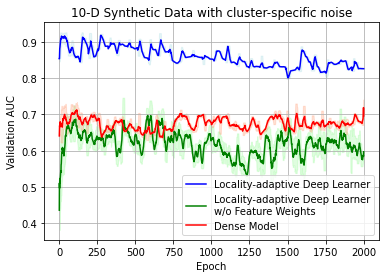

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch']+1)
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, i in enumerate(["LLDLwFW_valauc",
          "LLDLwoFW_valauc", 
          "DenseModel_valauc"
         ]):
    x_plot=df['Epoch']+1
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Validation AUC")
# ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", "Locality-adaptive Deep Learner\nw/o Feature Weights", "Dense Model"], 
#           bbox_to_anchor=(1,1)
         loc="lower right"
         )
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

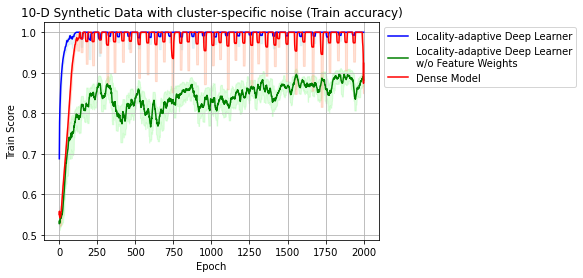

In [34]:
%matplotlib inline

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch']+1)
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, i in enumerate(["LLDLwFW_trainacc",
          "LLDLwoFW_trainacc", 
          "DenseModel_trainacc"
         ]):
    x_plot=df['Epoch']+1
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Train Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", "Locality-adaptive Deep Learner\nw/o Feature Weights", "Dense Model"], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise (Train accuracy)")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

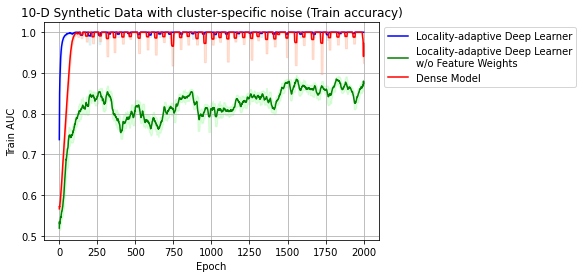

In [35]:
%matplotlib inline

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch']+1)
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, i in enumerate(["LLDLwFW_trainauc",
          "LLDLwoFW_trainauc", 
          "DenseModel_trainauc"
         ]):
    x_plot=df['Epoch']+1
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Train AUC")
# ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", "Locality-adaptive Deep Learner\nw/o Feature Weights", "Dense Model"], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise (Train accuracy)")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

## Random Forest

In [29]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
n_estimators_list=[200,500,1000]
n_repeats=10
random_seeds=range(n_repeats)
min_samples_list=list(range(1,11))
RF_results=[]

for n_estimator in n_estimators_list:
    for min_samples in min_samples_list:
        for i in range(n_repeats):
            np.random.seed(random_seeds[i])
            clf=ExtraTreesClassifier(n_estimators=n_estimator, 
                                     min_samples_leaf=min_samples,
                                     bootstrap=True, 
                                     oob_score=True, 
                                     class_weight="balanced_subsample")
            clf.fit(X_train, y_train)
            train_score=clf.score(X_train, y_train)
            test_score=clf.score(X_test, y_test)
            predict_proba_train=clf.predict_proba(X_train)[:,1]
            predict_proba_test=clf.predict_proba(X_test)[:,1]
            train_auc=roc_auc_score(y_train, predict_proba_train)
            test_auc=roc_auc_score(y_test, predict_proba_test)
            RF_results.append([n_estimator, min_samples, "train_accuracy", train_score])
            RF_results.append([n_estimator, min_samples, "test_accuracy", test_score])
            RF_results.append([n_estimator, min_samples, "train_auc", train_auc])
            RF_results.append([n_estimator, min_samples, "test_auc", test_auc])        
RF_results=pd.DataFrame(RF_results, columns=["n_estimator", "min_samples_leaf", "metric", "score"])

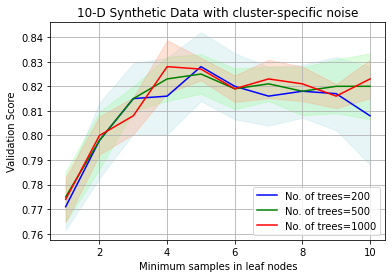

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=RF_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='min_samples_leaf',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Minimum samples in leaf nodes")
ax.set_ylabel("Validation Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

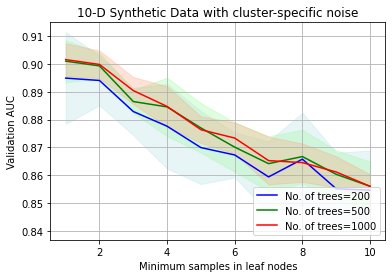

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=RF_results.query("n_estimator == @n_estimator & metric == 'test_auc' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='min_samples_leaf',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Minimum samples in leaf nodes")
ax.set_ylabel("Validation AUC")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

## XGBoost

In [32]:
from xgboost import XGBClassifier
n_estimators_list=[200,500,1000]
n_repeats=3
random_seeds=range(n_repeats)
gamma_list=[0.00001,0.00003,0.0001,0.0003, 0.001, 0.003, 0.01,0.03, 0.1,0.3]
xgb_results=[]
scale_pos_weight= (len(y_train)-np.sum(y_train))/np.sum(y_train) #Ratio of number of negatives to number of positives


for n_estimators in n_estimators_list:
    for gamma in gamma_list:
        for i in range(n_repeats):
            xgb_clf=XGBClassifier(n_estimators=n_estimators,
                                  gamma=gamma,
                                  max_depth=20,
                                  scale_pos_weight=scale_pos_weight,
                                  use_label_encoder=False, 
                                  eval_metric='logloss',
                                  seed=random_seeds[i]
                                 )
            xgb_clf.fit(X_train, y_train)
            train_score=xgb_clf.score(X_train, y_train)
            test_score=xgb_clf.score(X_test, y_test)
            train_predict_proba=xgb_clf.predict_proba(X_train)[:,1]
            test_predict_proba=xgb_clf.predict_proba(X_test)[:,1]
            train_auc=roc_auc_score(y_train, train_predict_proba)
            test_auc=roc_auc_score(y_test, test_predict_proba)
            xgb_results.append([n_estimators, gamma, "train_accuracy", train_score])
            xgb_results.append([n_estimators, gamma, "test_accuracy", test_score])
            xgb_results.append([n_estimators, gamma, "train_auc", train_auc])
            xgb_results.append([n_estimators, gamma, "test_auc", test_auc])            
            del xgb_clf
xgb_results=pd.DataFrame(xgb_results, columns=["n_estimator", "gamma", "metric", "score"])

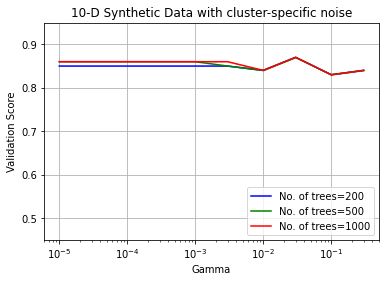

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=xgb_results.query("n_estimator == @n_estimator & metric == 'test_accuracy' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='gamma',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Gamma")
ax.set_ylabel("Validation Score")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

ax.set_xscale("log")
ax.set_ylim((0.45,0.95))
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

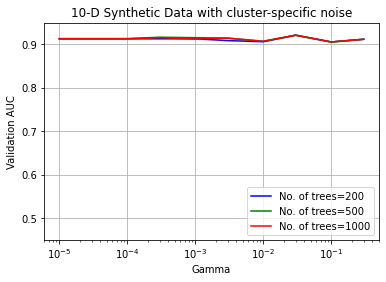

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_ave_LUbounds(df, x_col_name, percentiles=(10,90)):
    l,u=percentiles[0], percentiles[1]
    x_plot=np.unique(df[x_col_name])
    ave=[]
    lower=[]
    upper=[]
    if percentiles=='std':
        for x in x_plot:
            out=df[df[x_col_name]==x]['score']
            mean, std=np.mean(out), np.std(out)
            ave.append(mean)
            lower.append(mean-std)
            upper.append(mean+std)
        return x_plot, ave, lower, upper
    for x in x_plot:
        out=df[df[x_col_name]==x]['score']
        ave.append(np.mean(out))
        lower.append(np.percentile(out, l))
        upper.append(np.percentile(out, u))
    return x_plot, ave, lower, upper

fig,ax=plt.subplots()

colors1=["b","g","r"]
colors2=["powderblue","palegreen","lightsalmon"]
for idx, n_estimator in enumerate(n_estimators_list):
    out_df=xgb_results.query("n_estimator == @n_estimator & metric == 'test_auc' ")
    x_plot, ave, lower, upper=get_ave_LUbounds(out_df, x_col_name='gamma',
                                               percentiles='std'
                                              )
    ax.plot(x_plot, ave, c=colors1[idx])
    ax.fill_between(x_plot, lower, upper, color=colors2[idx], alpha=0.3)

ax.set_xlabel("Gamma")
ax.set_ylabel("Validation AUC")
# ax.set_ylim([0.45, 0.95])
ax.legend(["No. of trees="+str(i) for i in n_estimators_list], 
          loc=("lower right"))
ax.set_title("10-D Synthetic Data with cluster-specific noise")

ax.set_xscale("log")
ax.set_ylim((0.45,0.95))
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_RF")
# plt.savefig(savefile)

In [40]:
xgb_results[xgb_results['metric']=="test_accuracy"]

,n_estimator,gamma,metric,score
1,200,0.00001,test_accuracy,0.85
3,200,0.00001,test_accuracy,0.85
5,200,0.00001,test_accuracy,0.85
7,200,0.00003,test_accuracy,0.85
9,200,0.00003,test_accuracy,0.85
...,...,...,...,...
171,1000,0.10000,test_accuracy,0.83
173,1000,0.10000,test_accuracy,0.83
175,1000,0.30000,test_accuracy,0.84
177,1000,0.30000,test_accuracy,0.84


# Trying out Similarity Batching 

In [39]:
from SimBatch import SimilarityBatchingDataset

Fitted 20 clusters with distribution [232 104  93  80  76  66  59  51  41  36  30  16   5   4   2   1   1   1
   1   1]


In [61]:
LSwFW_model.optimizer.lr.assign(0.001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.001>

In [47]:
np.random.seed(0)

#For a trained LSwFW_model (n_epochs=200; shuffling) 
checkpoint_path=os.path.join("210216_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" )
LSwFW_model.load_weights(checkpoint_path)

simbatched_checkpoint_path=os.path.join("210216_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_simBatched" )
try:
    os.mkdir(simbatched_checkpoint_path)
except:
    pass

#Set callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simbatched_checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                     
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_filename = os.path.join(simbatched_checkpoint_path,
                            "training_log_simBatched.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

#Assign learning rate
LSwFW_model.optimizer.lr.assign(0.001)

n_epoch=1000
for i in range(n_epoch):

    #Set training tensors
    attentions=LSwFW_model.layers[1](train_tensor).numpy()
    simbatched=SimilarityBatchingDataset(
        train_tensor,
        train_targets,
        attentions,
    )
    rearranged_train_tensor, rearranged_train_targets=simbatched.get_rearranged_tensor()
    
    #Fit model
    LSwFW_model.fit(rearranged_train_tensor, 
                rearranged_train_targets,
                epochs=1,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

Fitted 20 clusters with distribution [217 125  87  85  85  69  62  48  31  28  23   8   8   7   7   5   2   1
   1   1]
113/113 - 5s - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.6600 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from -inf to 0.89000, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
Fitted 20 clusters with distribution [221 126 104  79  73  68  62  48  29  28  24   8   7   6   5   5   4   1
   1   1]
113/113 - 5s - loss: 0.0153 - accuracy: 0.9978 - val_loss: 0.6964 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from 0.89000 to 0.90000, saving model to 210216_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
Fitted 20 clusters with distribution [217 121  97  80  78  68  62  48  32  28  26   8   8   7   7   5   5   1
   1   1]
113/113 - 5s - loss: 0.0102 - accuracy: 0.9989 - val_loss: 0.7294 - val_accuracy: 0.9000

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distri

113/113 - 5s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0090 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 125 108  70  62  60  52  46  32  30  28  25  11   9   7   7   5   2
   1   1]
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0106 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 125 108  70  62  60  52  46  32  30  28  25  11   9   7   7   5   2
   1   1]
113/113 - 5s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0191 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 122 108  70  62  60  52  46  32  30  28  28  11   9   7   7   5   2
   1   1]
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0205 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 122 108  70  62  6

113/113 - 5s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1702 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [218 125  84  81  72  62  61  56  50  28  24  11   7   7   6   3   2   1
   1   1]
113/113 - 4s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.1707 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [221 144  84  81  72  61  56  50  43  28  24  11   7   6   4   3   2   1
   1   1]
113/113 - 4s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.1725 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [221 125  84  81  72  62  61  56  50  28  24  11   7   6   4   3   2   1
   1   1]
113/113 - 5s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.1894 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [218 125  81  69  62  6

113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.1959 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [225 119  91  83  72  70  67  52  51  27  11  11   6   5   3   2   2   1
   1   1]
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.2049 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [277 119  83  72  72  70  67  51  27  21  11   9   6   5   3   2   2   1
   1   1]
113/113 - 5s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.2165 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [225 119  79  78  72  70  67  52  51  27  21  11   9   6   5   3   2   1
   1   1]
113/113 - 5s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2253 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [225 119  79  78  72  7

113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3606 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 122  84  83  67  64  63  53  52  27  23  11  10   7   6   5   1   1
   1   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3797 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 122  91  67  64  63  53  52  50  34  27  23  11   7   6   5   3   1
   1   1]
113/113 - 5s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3953 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 121  91  82  67  63  63  53  52  27  23  11   7   6   5   4   3   1
   1   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3816 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [219 121  91  82  67  6

113/113 - 4s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.0052 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 121 103  84  71  68  59  54  53  44  27  22  15  12  11   5   3   2
   2   1]
113/113 - 4s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.0047 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 121 103  84  71  68  59  54  53  44  27  22  15  12  11   5   3   2
   2   1]
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0021 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 121 103  84  71  68  59  54  53  44  27  22  15  12  11   5   3   2
   2   1]
113/113 - 4s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0132 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [227 121  82  74  71  6

113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.1552 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [221 124 121  82  79  68  48  31  31  26  24  12  10   7   5   4   2   2
   2   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.1446 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [221 124 121  82  80  68  47  31  31  26  24  12  10   7   5   4   2   2
   2   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.1558 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [221 124 121  84  80  68  47  31  29  26  24  12  10   7   5   4   2   2
   2   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.1648 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [269 121  84  71  68  5

113/113 - 4s - loss: 0.0763 - accuracy: 0.9756 - val_loss: 0.8812 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [266 116  83  81  78  71  69  33  31  24  19   7   5   4   4   3   2   2
   1   1]
113/113 - 4s - loss: 0.0347 - accuracy: 0.9900 - val_loss: 0.7364 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [268 101  94  80  69  67  52  43  35  24  21  14  12   7   5   3   2   1
   1   1]
113/113 - 4s - loss: 0.0128 - accuracy: 0.9989 - val_loss: 0.8183 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [268  98  91  82  68  59  56  52  34  34  17  11   8   7   5   4   2   2
   1   1]
113/113 - 4s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.7854 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [269  98  82  81  77  7

113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0778 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [220 117  88  83  69  68  52  46  34  32  29  24  10   8   7   5   3   2
   2   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0826 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [220 117  88  83  69  68  52  46  34  32  29  24  10   8   7   5   3   2
   2   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0875 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [220 117  88  84  69  67  52  46  34  32  29  24  10   8   7   5   3   2
   2   1]
113/113 - 4s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0942 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [220 117  88  84  69  6

113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2527 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [268 117  82  76  73  71  67  45  34  24  12   9   8   5   3   2   1   1
   1   1]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2682 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [268 117  82  76  73  71  67  45  34  24  12   9   8   5   3   2   1   1
   1   1]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2660 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [269 117  81  81  73  67  66  45  33  26   9   9   8   5   3   3   2   1
   1   1]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2709 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [268 117  82  81  73  6

113/113 - 4s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.1422 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256 117  68  67  50  48  44  43  35  35  32  29  28  16  11   8   6   3
   2   2]
113/113 - 4s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1489 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256 116  93  71  67  48  44  35  33  32  28  19  16  11  10   8   6   3
   2   2]
113/113 - 4s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1538 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256 116  93  71  67  45  44  38  33  32  28  19  16  11  10   8   6   3
   2   2]
113/113 - 4s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.1608 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256 116  87  71  49  4

113/113 - 5s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2863 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [257 106  76  76  71  60  44  38  36  33  28  19  15  11   9   8   5   3
   3   2]
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2943 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [257  99  90  76  71  63  44  36  28  27  24  19  19  15  11   8   5   3
   3   2]
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2978 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256  99  86  76  71  63  44  36  30  28  27  20  19  15  11   8   5   3
   2   1]
113/113 - 4s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.3050 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256 125  76  71  63  5

113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3907 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [269 131  89  86  73  71  43  26  22  20  18  17  12   8   5   3   2   2
   2   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.4146 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [247 119  89  86  80  68  43  31  27  25  22  19  12  11   8   5   3   2
   2   1]
113/113 - 4s - loss: 0.0257 - accuracy: 0.9978 - val_loss: 1.9804 - val_accuracy: 0.8200

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [231 102  86  78  72  68  63  54  48  32  27  10   9   6   5   2   2   2
   2   1]
113/113 - 4s - loss: 0.6439 - accuracy: 0.8911 - val_loss: 1.1379 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [232 120  86  64  62  5

113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1366 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [235 131  98  85  66  51  41  37  35  34  27  21  18   6   6   2   2   2
   2   1]
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1399 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [235 131  98  85  66  51  41  37  35  34  27  21  18   6   6   2   2   2
   2   1]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1474 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [235 131  98  85  66  51  41  37  35  34  27  21  18   6   6   2   2   2
   2   1]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1507 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [235 131  98  85  66  5

113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.2752 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [248 138  95  76  70  54  41  35  30  27  23  20  12  11   6   6   3   2
   2   1]
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.2749 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [248 139  95  75  70  54  41  35  30  27  23  20  12  11   6   6   3   2
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2703 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [248 138  95  76  70  54  41  35  30  27  23  20  12  11   6   6   3   2
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2834 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [248 106  98  89  78  7

113/113 - 4s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.9102 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [152 119 100  88  80  72  62  55  34  29  28  28  24  11   6   5   2   2
   2   1]
113/113 - 4s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.9220 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [152 119 100  88  80  72  62  55  34  29  28  28  24  11   6   5   2   2
   2   1]
113/113 - 4s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.9321 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [152 119 100  88  80  72  62  55  34  29  28  28  24  11   6   5   2   2
   2   1]
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.9439 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [152 119 100  88  80  7

113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1719 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [152 121 100  89  86  74  72  62  35  29  26  21  11   6   6   3   2   2
   2   1]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1752 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [136 132 121  89  86  72  62  46  35  29  28  21  13  11   6   4   3   2
   2   2]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [136 132 121  89  86  72  62  46  35  29  28  21  13  11   6   4   3   2
   2   2]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1864 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [136 132 119  89  86  7

113/113 - 4s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.2785 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [138 136  91  88  87  72  71  67  36  29  27  23  11  11   3   2   2   2
   2   2]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2854 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [138 132  91  88  87  76  71  67  36  29  27  23  11  11   3   2   2   2
   2   2]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2974 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [138 132  92  88  86  76  71  66  37  29  27  23  11  11   3   2   2   2
   2   2]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2981 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [138 132  91  88  86  7

113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0837 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233  91  83  82  72  57  56  45  37  27  27  26  20  11   9   7   6   5
   3   3]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.0910 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233  91  83  82  72  57  56  45  37  27  27  26  20  11   9   7   6   5
   3   3]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.0964 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233  91  82  72  70  57  56  45  43  30  27  26  20  11  10   9   7   5
   3   3]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1029 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233  91  82  72  70  5

113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2035 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233 120  74  72  63  58  56  44  43  31  27  27  19  11   8   5   3   3
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2080 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233 120  74  72  62  58  57  44  37  31  27  27  19  11   9   8   5   3
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2124 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233 120  74  72  62  58  57  44  37  31  27  27  19  11   9   8   5   3
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2191 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233 120  74  72  62  6

113/113 - 4s - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.9325 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [251 101  84  72  61  53  51  43  34  34  27  27  22  13  10   9   3   3
   1   1]
113/113 - 4s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.9409 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [251 101  82  72  63  53  51  43  34  34  27  23  22  13  13  10   3   3
   1   1]
113/113 - 4s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.9511 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [251 101  82  72  63  53  51  43  34  34  27  23  22  13  13  10   3   3
   1   1]
113/113 - 4s - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.9519 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [251 101  82  72  59  5

113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0816 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [252 110 101  73  62  53  51  43  33  28  23  22  13  11  10   7   3   3
   1   1]
113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0863 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 101  90  74  62  53  51  43  31  28  27  23  22  13  11  10   3   3
   1   1]
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0904 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 101  90  74  62  53  51  43  29  28  27  26  22  12  11  10   3   3
   1   1]
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0971 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 101  82  74  62  5

113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.1909 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 134  91  83  71  45  43  34  32  27  24  22  13  12   6   3   2   2
   2   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.1908 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 134  83  71  48  45  43  43  34  32  27  24  22  13  12   6   4   3
   2   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2010 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 134  83  71  48  45  43  43  34  32  27  24  22  13  12   6   4   3
   2   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.1925 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [233 115 101  71  70  4

113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0760 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [237  83  78  76  71  66  48  45  38  37  27  27  23  15  12  10   2   2
   2   1]
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0789 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [237  83  78  76  71  66  48  45  38  37  27  26  23  15  13  10   2   2
   2   1]
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0909 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [237  83  78  76  71  66  48  45  38  37  27  26  23  15  13  10   2   2
   2   1]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.0945 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [236  83  78  76  71  6

113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1990 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [238  94  81  75  66  59  52  48  42  34  27  23  18  13  10   9   6   2
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1914 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [238  94  81  75  66  59  52  48  42  34  27  23  18  13  10   9   6   2
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2049 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [238  94  81  75  66  59  52  48  42  34  27  23  18  13  10   9   6   2
   2   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2000 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [238  76  74  66  59  5

113/113 - 4s - loss: 0.0591 - accuracy: 0.9867 - val_loss: 0.8592 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [249 122  82  82  67  63  53  51  29  25  23  19  10   9   6   3   2   2
   2   1]
113/113 - 4s - loss: 0.0305 - accuracy: 0.9944 - val_loss: 0.9412 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [241 134  87  82  75  66  35  32  32  31  28  28   8   7   6   3   2   1
   1   1]
113/113 - 4s - loss: 0.0331 - accuracy: 0.9922 - val_loss: 0.9520 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [256 128 107  92  82  47  37  31  28  23  19  16  13   7   6   3   2   1
   1   1]
113/113 - 4s - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.9463 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [259 133  82  71  70  6

113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1091 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [258 119  86  83  69  62  51  37  28  28  27  17  14   7   5   3   2   2
   1   1]
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1129 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [258 120  86  81  69  62  51  37  30  25  24  20  14  11   3   3   2   2
   1   1]
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1174 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [258 120  86  81  69  62  51  37  30  25  24  20  14  11   3   3   2   2
   1   1]
113/113 - 5s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1233 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [258 103  93  81  69  6

113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2571 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [258 154  80  75  71  69  61  28  27  23  17  12   6   6   5   2   2   2
   1   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2673 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [259 149  80  75  71  68  61  29  28  27  17  12   6   6   5   2   2   1
   1   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2633 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [259 149  80  75  71  68  61  29  28  27  17  12   6   6   5   2   2   1
   1   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2754 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [259 149  80  71  68  6

113/113 - 5s - loss: 0.0059 - accuracy: 0.9989 - val_loss: 1.2032 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [146 133 126  83  73  64  57  55  44  30  27  18  12  11   7   6   3   3
   1   1]
113/113 - 4s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.2159 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [146 126 125  73  66  64  56  56  39  30  29  27  27  12   7   6   4   3
   3   1]
113/113 - 4s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.2186 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [146 125 118  73  66  64  56  56  39  30  28  27  27  12  11   8   6   4
   3   1]
113/113 - 4s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 1.2212 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [146 125 125  87  73  6

113/113 - 4s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.3164 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 130 118  81  72  65  61  51  45  32  28  27  12  11   9   6   4   2
   2   1]
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3147 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 130 118  87  82  72  65  44  32  28  27  25  12  11   9   6   4   2
   2   1]
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3242 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 130 118  87  82  72  65  44  32  28  27  25  12  11   9   6   4   2
   2   1]
113/113 - 4s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3232 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [143 130 119  87  82  7

113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3826 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [142 138 130  80  72  64  60  53  46  31  27  14  12  12   8   3   3   2
   2   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3755 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [142 138 130  80  72  64  60  53  46  31  27  14  12  12   8   3   3   2
   2   1]
113/113 - 4s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3657 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [142 138 131  80  68  64  60  53  46  34  27  14  12  12   8   3   3   2
   2   1]
113/113 - 4s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3750 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [253 138  80  68  64  6

113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2419 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [239 137 112  68  63  61  52  51  38  37  19  12   3   2   1   1   1   1
   1   1]
113/113 - 4s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.2484 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [239 137 112  68  63  61  52  51  37  33  19  12   6   3   2   1   1   1
   1   1]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2523 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [239 137 112  68  63  61  52  51  37  33  19  12   6   3   2   1   1   1
   1   1]
113/113 - 4s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.2580 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [239 137 112  68  63  6

113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3566 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [209 136 114  63  63  63  51  48  37  32  32  19  14   6   4   3   2   2
   1   1]
113/113 - 5s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3631 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [209 136 114  63  63  63  52  51  37  37  32  20   6   5   3   3   2   2
   1   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3678 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [209 145  94  83  64  63  52  42  37  37  32  19   6   5   3   3   2   2
   1   1]
113/113 - 4s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3760 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
Fitted 20 clusters with distribution [209 145 115  64  63  6

In [65]:
np.random.seed(0)

#For a trained LSwFW_model (n_epochs=200; shuffling) 
checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_label" )
LSwFW_model.load_weights(checkpoint_path)

simbatched_checkpoint_path=os.path.join("210210_TrainingLocalitySensitivewFW",
                                      "LocalitySensitivewFW_simBatched" )
try:
    os.mkdir(simbatched_checkpoint_path)
except:
    pass

#Set callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=simbatched_checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='max',
                     
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
csv_filename = os.path.join(simbatched_checkpoint_path,
                            "training_log_NosimBatched_lr_0_001.csv"
                            )
csvlogger_callback = tf.keras.callbacks.CSVLogger(filename=csv_filename, append=True)

#Assign learning rate
LSwFW_model.optimizer.lr.assign(0.001)

n_epoch=1000
for i in range(n_epoch):
    #No rearranging of tensors
    #Fit model
    LSwFW_model.fit(train_tensor, 
                train_targets,
                epochs=1,
                batch_size=n_batch,
                validation_data=(test_tensor, test_targets),
                shuffle=True,
                verbose=2, 
                callbacks=[csvlogger_callback,
                           cp_callback
                          ]
               )

29/29 - 1s - loss: 0.0545 - accuracy: 0.9867 - val_loss: 0.9221 - val_accuracy: 0.8900

Epoch 00001: val_accuracy improved from -inf to 0.89000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatched
29/29 - 1s - loss: 0.0433 - accuracy: 0.9933 - val_loss: 0.9312 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0396 - accuracy: 0.9933 - val_loss: 0.9443 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0388 - accuracy: 0.9933 - val_loss: 0.9630 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0372 - accuracy: 0.9933 - val_loss: 0.9682 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0357 - accuracy: 0.9956 - val_loss: 0.9714 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0341 - accuracy: 0.9944 - val_loss:

29/29 - 1s - loss: 0.0227 - accuracy: 0.9989 - val_loss: 1.1696 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0225 - accuracy: 0.9989 - val_loss: 1.1744 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0225 - accuracy: 0.9989 - val_loss: 1.1793 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.1820 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1843 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9989 - val_loss: 1.1886 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0220 - accuracy: 0.9989 - val_loss: 1.1906 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.2900 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.2909 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0175 - accuracy: 1.0000 - val_loss: 1.2921 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.2930 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0173 - accuracy: 1.0000 - val_loss: 1.2966 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0172 - accuracy: 1.0000 - val_loss: 1.2975 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 1.2949 - val_accuracy: 0.8600

29/29 - 1s - loss: 0.0125 - accuracy: 1.0000 - val_loss: 1.3388 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.3425 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0123 - accuracy: 1.0000 - val_loss: 1.3408 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 1.3397 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0121 - accuracy: 1.0000 - val_loss: 1.3351 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0120 - accuracy: 1.0000 - val_loss: 1.3390 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 1.3358 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1468 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1482 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.1507 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 1.1531 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1557 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1571 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0094 - accuracy: 1.0000 - val_loss: 1.1595 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.2232 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 1.2215 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2235 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2289 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.2283 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2282 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 1.2334 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.1874 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 1.1955 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.1988 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2026 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.2146 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2120 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.2180 - val_accuracy: 0.8500

29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3245 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3295 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3290 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3300 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3291 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.3289 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.3311 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.89000


Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.0373 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0416 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 1.0448 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0598 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.0625 - val_accuracy: 0.8900

Epoch 00001: val_accuracy did not improve from 0.89000
29/29 - 1s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 1.0652 - val_accuracy: 0.9000

Epoch 00001: val_accuracy improved from 0.89000 to 0.90000, saving model to 210210_TrainingLocalitySensitivewFW\LocalitySensitivewFW_simBatch


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1560 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1539 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1542 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1558 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1553 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1555 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.1653 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1666 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1685 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1705 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1594 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1681 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1676 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.1679 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0135 - accuracy: 0.9956 - val_loss: 1.1348 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 1.1429 - val_accuracy: 0.8800

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0113 - accuracy: 0.9967 - val_loss: 1.1764 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0222 - accuracy: 0.9944 - val_loss: 1.1309 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0166 - accuracy: 0.9944 - val_loss: 1.1327 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0085 - accuracy: 0.9989 - val_loss: 1.1477 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0078 - accuracy: 0.9989 - val_loss: 1.1641 - val_accuracy: 0.8500

29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3623 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3624 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3632 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3625 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.3638 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3662 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.3678 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.4265 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3791 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3644 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3662 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3710 - val_accuracy: 0.8700

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.3666 - val_accuracy: 0.8700

29/29 - 1s - loss: 0.0197 - accuracy: 0.9944 - val_loss: 1.1070 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0123 - accuracy: 0.9989 - val_loss: 1.1795 - val_accuracy: 0.8300

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0094 - accuracy: 0.9989 - val_loss: 1.1520 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0070 - accuracy: 0.9989 - val_loss: 1.1511 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0051 - accuracy: 0.9989 - val_loss: 1.1380 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.1247 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.1376 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2203 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2246 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2250 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2317 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2304 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2296 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2290 - val_accuracy: 0.8600

29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2863 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2818 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2864 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2864 - val_accuracy: 0.8600

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2718 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2826 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2895 - val_accuracy: 0.8500

Epoch 00001: val_accuracy did not improve from 0.90000


Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3559 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3526 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3648 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3544 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3592 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3601 - val_accuracy: 0.8400

Epoch 00001: val_accuracy did not improve from 0.90000
29/29 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.3518 - val_accuracy: 0.8400

In [73]:
#Data processed in excel by combining training and validation accuracy columns from individual training_log.csv"
import pandas as pd
SynthDataFolder="SynthData_10dim_clusternoise_AddBN"
df=pd.read_csv(os.path.join("SynthData10dim_results.csv"),
               index_col=False)

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


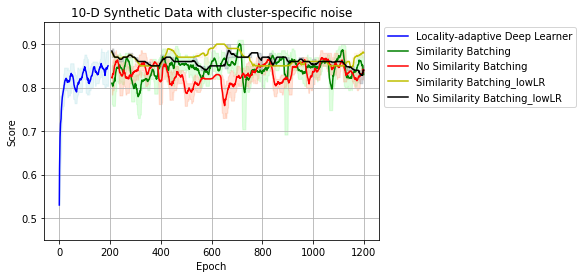

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r","y","k"]
colors2=["powderblue","palegreen","lightsalmon","bisque","lightslategray"]
for idx, i in enumerate(["LLDLwFW_valacc",
#           "LLDLwoFW_valacc", 
#           "DenseModel_valacc"
                         "LLDLwFW_simBatched_valacc",
                         "LLDLwFW_NosimBatched_valacc",
                         "LLDLwFW_simBatched_lr_0_001_valacc",
                         "LLDLwFW_NosimBatched_lr_0_001_valacc"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", 
           "Similarity Batching",
           "No Similarity Batching",
           "Similarity Batching_lowLR",
           "No Similarity Batching_lowLR"
          ], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

In [ ]:
#Try turning learning rate down to 0.001

In [ ]:
#Try on unbalanced dataset

c:\users\cavio\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


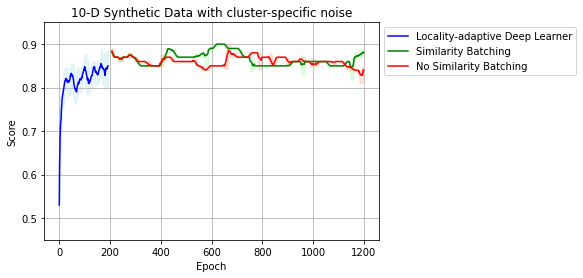

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
fig,ax=plt.subplots()
df['logEpoch']=np.log10(df['Epoch'])
# sns.lineplot('Step', 'AttentionModelwFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'AttentionModelwoFeatWeights_val', data=att_model_df, ax=ax)
# sns.lineplot('Step', 'DenseModel_val', data=att_model_df, ax=ax)

def get_mov_ave(y, window_size=3, percentiles=(10,90)):
    assert window_size%2 ==1
    w=int(window_size/2)
    out=[]
    lower=[]
    upper=[]
    l,u=percentiles[0],percentiles[1]
    for i in range(w, len(y)-w):
        out.append(np.average(y[i-w:i+w+1]))
        lower.append(np.percentile(y[i-w:i+w+1],l))
        upper.append(np.percentile(y[i-w:i+w+1],u))

    while w>0:
        w=w-1
        win_size=w*2+1
        out.insert(0, np.average(y[:win_size]))
        lower.insert(0, np.percentile(y[:win_size], l))
        upper.insert(0, np.percentile(y[:win_size], u))
        out.append(np.average(y[len(y)-win_size:]))
        lower.append(np.percentile(y[len(y)-win_size:], l))
        upper.append(np.percentile(y[len(y)-win_size:], u))
    return out, lower, upper

def get_min_max(mov_ave, y):
    assert len(mov_ave)==len(y)
    mins=np.min(np.vstack([mov_ave, y]), axis=0)
    maxs=np.max(np.vstack([mov_ave,y]), axis=0)
    return mins, maxs

colors1=["b","g","r","y","k"]
colors2=["powderblue","palegreen","lightsalmon","bisque","lightslategray"]
for idx, i in enumerate(["LLDLwFW_valacc",
#           "LLDLwoFW_valacc", 
#           "DenseModel_valacc"
#                          "LLDLwFW_simBatched_valacc",
#                          "LLDLwFW_NosimBatched_valacc",
                         "LLDLwFW_simBatched_lr_0_001_valacc",
                         "LLDLwFW_NosimBatched_lr_0_001_valacc"
         ]):
    x_plot=df['Epoch']
    y_plot=df[i]
    mov_ave, lower, upper=get_mov_ave(y_plot, window_size=15)
    plt.plot(x_plot, mov_ave, c=colors1[idx])
    #mins,maxs=get_min_max(mov_ave, get_mov_ave(y_plot, window_size=3))
    plt.fill_between(x_plot,lower, upper, color=colors2[idx], alpha=0.3)


ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_ylim([0.45, 0.95])
ax.legend(["Locality-adaptive Deep Learner", 
#            "Similarity Batching",
#            "No Similarity Batching",
           "Similarity Batching",
           "No Similarity Batching"
          ], 
          bbox_to_anchor=(1,1))
ax.set_title("10-D Synthetic Data with cluster-specific noise")
plt.grid()
# savefile=os.path.join(SynthDataFolder, "SynthData_10dim_LocallyAdaptiveDeepLearner")
# plt.savefig(savefile)

In [ ]:
#What happens if I add dropout?